# Objective

To define supply thresholds based on demand

# Import Packages

In [1]:
import pandas as pd
import glob
import numpy as np

import math
from datetime import datetime

from pyhive import presto

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Configs

In [2]:
city = 'Hyderabad'
service = 'Link'
start_date = '20230710'
end_date = '20230723'

#PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/lchf_super_clusters/dse-demand-analysis/'

# Connection 

In [3]:
# conn = presto.connect(host='prime-trino.serving.data.production.internal',
#                       port=80,
#                       username='pallavi.chandra@rapido.bike')

# conn = presto.connect(host='presto.yoda.run',
#                       port=8080,
#                       username='pallavi.chandra@rapido.bike')


conn = presto.connect(
        host='presto-gateway.serving.data.production.internal',
        port=80,
        protocol='http',
        catalog='hive',
        username='manoj.ravirajan@rapido.bike'
)

# SQL Queries

In [5]:
fe_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service_name}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        COUNT(distinct order_id) AS rr_count,
        COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END) AS net_count
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service_name}')
        AND city_name = '{city}'

    GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        COALESCE(rr_tbl.rr_count,0) AS rr_count,
        COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        SUM(fe_count) AS fe_count,
        SUM(rr_count) AS rr_count,
        SUM(net_count) AS net_count,
        100.0*SUM(rr_count)/SUM(fe_count) AS FE2RR,
        100.0*SUM(net_count)/SUM(rr_count) AS G2N,
        100.0*SUM(net_count)/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where fe_count > 0 
    and rr_count > 0 
    GROUP BY 
        1,2,3,4,5
)

SELECT * FROM order_stat ORDER BY 1,2,3,4
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service_name = service,
    city = city)

In [6]:
print(fe_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Hyderabad'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
     

# Read SQL Queries

In [6]:
#rr_data = pd.read_sql(rr_query, conn)

#rr_data = pd.read_csv('~/Downloads/rr_Hyd_20220905_20221128.csv')

fe_data = pd.read_sql(fe_query, conn)

fe_data

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36512/2899097727.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fe_data = pd.read_sql(fe_query, conn)


city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0       Hyderabad  20230710  2023-07-10                        0130        23   
1       Hyderabad  20230710  2023-07-10                        0245         8   
2       Hyderabad  20230710  2023-07-10                        2100        60   
3       Hyderabad  20230710  2023-07-10                        1400        66   
4       Hyderabad  20230710  2023-07-10                        0000        65   
...           ...       ...         ...            ...          ...       ...   
240044  Hyderabad  20230723  2023-07-23    shilparamam         1815       128   
240045  Hyderabad  20230723  2023-07-23    shilparamam         0745        26   
240046  Hyderabad  20230723  2023-07-23    shilparamam         1215       174   
240047  Hyderabad  20230723  2023-07-23    shilparamam         0915        71   
240048  Hyderabad  20230723  2023-07-23    shilparamam         1300       112   

        rr_count  net_count  FE2RR   G2N  FE2Net  
0              3          1   13.0  33.3     4.3  
1              1          0   12.5   0.0     0.0  
2             16         10   26.7  62.5    16.7  
3             14         11   21.2  78.6    16.7  
4              7          2   10.8  28.6     3.1  
...          ...        ...    ...   ...     ...  
240044        18         17   14.1  94.4    13.3  
240045         6          4   23.1  66.7    15.4  
240046        21         16   12.1  76.2     9.2  
240047        13         10   18.3  76.9    14.1  
240048        13         10   11.6  76.9     8.9  

[240049 rows x 11 columns]

In [9]:
fe_data.to_csv('/Users/rapido/local-datasets/non-peak-demand/raw/fe_data_{}_{}_non_peak_analysis_{}_to_{}.csv' \
               .format(city, service,start_date,end_date), index = False)

In [7]:
fe_data = pd.read_csv('/Users/rapido/local-datasets/non-peak-demand/raw/fe_data_{}_{}_non_peak_analysis_{}_to_{}.csv' \
               .format(city, service,start_date,end_date))
fe_data.head()

city  yyyymmdd   orderdate pickup_cluster  quarter_hour  fe_count  \
0  Hyderabad  20230710  2023-07-10            NaN           130        23   
1  Hyderabad  20230710  2023-07-10            NaN           245         8   
2  Hyderabad  20230710  2023-07-10            NaN          2100        60   
3  Hyderabad  20230710  2023-07-10            NaN          1400        66   
4  Hyderabad  20230710  2023-07-10            NaN             0        65   

   rr_count  net_count  FE2RR   G2N  FE2Net  
0         3          1   13.0  33.3     4.3  
1         1          0   12.5   0.0     0.0  
2        16         10   26.7  62.5    16.7  
3        14         11   21.2  78.6    16.7  
4         7          2   10.8  28.6     3.1

## Get time period

In [8]:
def get_period(hour):
    hour = int(hour)
    if (hour >= 8 and hour <= 11):
        return "morning_peak"
    elif (hour >= 17 and hour <= 21):
        return "evening_peak"
    elif (hour > 11 and hour < 17):
        return "afternoon"
    else:
        return "rest"

In [9]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['time_period'] = fe_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

In [10]:
fe_data['week_period'] = fe_data['yyyymmdd'].map(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A')
)

fe_data

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0       Hyderabad  20230710  2023-07-10            NaN         0130        23   
1       Hyderabad  20230710  2023-07-10            NaN         0245         8   
2       Hyderabad  20230710  2023-07-10            NaN         2100        60   
3       Hyderabad  20230710  2023-07-10            NaN         1400        66   
4       Hyderabad  20230710  2023-07-10            NaN         0000        65   
...           ...       ...         ...            ...          ...       ...   
240044  Hyderabad  20230723  2023-07-23    shilparamam         1815       128   
240045  Hyderabad  20230723  2023-07-23    shilparamam         0745        26   
240046  Hyderabad  20230723  2023-07-23    shilparamam         1215       174   
240047  Hyderabad  20230723  2023-07-23    shilparamam         0915        71   
240048  Hyderabad  20230723  2023-07-23    shilparamam         1300       112   

        rr_count  net_count  FE2RR   G2N  FE2Net   time_period week_period  
0              3          1   13.0  33.3     4.3          rest      Monday  
1              1          0   12.5   0.0     0.0          rest      Monday  
2             16         10   26.7  62.5    16.7  evening_peak      Monday  
3             14         11   21.2  78.6    16.7     afternoon      Monday  
4              7          2   10.8  28.6     3.1          rest      Monday  
...          ...        ...    ...   ...     ...           ...         ...  
240044        18         17   14.1  94.4    13.3  evening_peak      Sunday  
240045         6          4   23.1  66.7    15.4          rest      Sunday  
240046        21         16   12.1  76.2     9.2     afternoon      Sunday  
240047        13         10   18.3  76.9    14.1  morning_peak      Sunday  
240048        13         10   11.6  76.9     8.9     afternoon      Sunday  

[240049 rows x 13 columns]

In [11]:
fe_data_filtered = fe_data[fe_data['time_period'] != 'rest']

In [12]:
fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
fe_data_filtered['pickup_cluster'] = fe_data_filtered['pickup_cluster'].astype(str)

fe_data_filtered = fe_data_filtered.fillna(0)
fe_data_filtered = fe_data_filtered.dropna()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/3015189938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/3015189938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/3015189938.py:3: SettingWithCopyWarning

In [13]:
fe_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0  Hyderabad  20230710  2023-07-10            NaN         0130        23   
1  Hyderabad  20230710  2023-07-10            NaN         0245         8   
2  Hyderabad  20230710  2023-07-10            NaN         2100        60   
3  Hyderabad  20230710  2023-07-10            NaN         1400        66   
4  Hyderabad  20230710  2023-07-10            NaN         0000        65   

   rr_count  net_count  FE2RR   G2N  FE2Net   time_period week_period  
0         3          1   13.0  33.3     4.3          rest      Monday  
1         1          0   12.5   0.0     0.0          rest      Monday  
2        16         10   26.7  62.5    16.7  evening_peak      Monday  
3        14         11   21.2  78.6    16.7     afternoon      Monday  
4         7          2   10.8  28.6     3.1          rest      Monday

In [14]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['quarter_hour'] = fe_data['quarter_hour'].astype(str)

fe_data['hour'] = fe_data['quarter_hour'].str[0:2]

In [15]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')

In [16]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

In [17]:
cluster_temporal_stats.head()

pickup_cluster hour week_period  total_fe_count  total_rr_count  \
0          AOC Centre   00      Friday             139              28   
17184  Madhapur Metro   00      Monday             394              51   
3964      Basheerbagh   00      Friday              73              17   
3965      Basheerbagh   00      Monday             215              32   
3966      Basheerbagh   00    Saturday              87              27   

       total_net_orders  fe_rr_ratio  g2n_ratio  
0                    11    20.000000  37.931034  
17184                16    12.911392  30.769231  
3964                 12    22.972973  66.666667  
3965                 14    14.814815  42.424242  
3966                 17    30.681818  60.714286

In [18]:
fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [19]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'time_period', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('pickup_cluster')


cluster_temporal_stats.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0      AOC Centre   afternoon      Friday            4440             779   
27     AOC Centre        rest   Wednesday            2415             515   
26     AOC Centre        rest     Tuesday            4482             610   
25     AOC Centre        rest    Thursday            3342             440   
24     AOC Centre        rest      Sunday            2370             425   

    total_net_orders  
0                559  
27               205  
26               137  
25               184  
24               201

In [20]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [21]:
lower_quantile_threshold_list = [0.25, 0.20, 0.15, 0.12, 0.1]
higher_quantile_threshold_list = [0.75, 0.80, 0.85, 0.87, 0.9]
temporal_stats_for_threshold = pd.DataFrame({})

In [22]:
## check 
temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.25)),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.75)),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.20)),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.80))
    ).reset_index()
    
temporal_stats_for_each_threshold.head()

pickup_cluster   time_period  lower_g2n_threshold  higher_g2n_threshold  \
0     AOC Centre     afternoon            57.789183             73.059140   
1     AOC Centre  evening_peak            52.233000             70.947285   
2     AOC Centre  morning_peak            46.332998             67.306741   
3     AOC Centre          rest            40.726019             51.118145   
4          Abids     afternoon            43.808022             72.149064   

   lower_fe2rr_threshold  higher_fe2rr_threshold  
0              11.939002               16.445904  
1              13.709367               18.693174  
2              13.633243               18.446981  
3              14.470553               22.785746  
4              18.082177               23.462167

In [31]:
temporal_stats_for_threshold = pd.DataFrame()

for i in range(0, len(lower_quantile_threshold_list), 1):
    
    lower_g2n_threshold_str = 'lower_g2n_threshold_' + str(lower_quantile_threshold_list[i])
    higher_g2n_threshold_str = 'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])
    lower_fe2rr_threshold_str = 'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])
    higher_fe2rr_threshold_str = 'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])
    print(lower_quantile_threshold_list[i])

    temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i])),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i]))
    ).reset_index()

    temporal_stats_for_each_threshold.rename(
        columns={'lower_g2n_threshold': lower_g2n_threshold_str, 
                 'higher_g2n_threshold': higher_g2n_threshold_str,
                 'lower_fe2rr_threshold': lower_fe2rr_threshold_str,
                 'higher_fe2rr_threshold': higher_fe2rr_threshold_str}, 
        inplace=True)
    
    #print(temporal_stats_for_each_threshold.head())
    
    #temporal_stats_for_threshold = pd.concat([temporal_stats_for_threshold, temporal_stats_for_each_threshold], axis=1)
    
    temporal_stats_for_each_threshold.to_csv(
        '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/temporal_stats_for_each_threshold_hyderabad_link_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv', index=False)
    
filepath = "/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/"
filenames = glob.glob(filepath + "/*.csv")


li = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
    print(li)

frame = pd.concat(li, axis=1)

        


0.25
0.2
0.15
0.12
0.1
[    pickup_cluster   time_period  lower_g2n_threshold_0.25  \
0       AOC Centre     afternoon                 57.789183   
1       AOC Centre  evening_peak                 52.233000   
2       AOC Centre  morning_peak                 46.332998   
3       AOC Centre          rest                 40.726019   
4            Abids     afternoon                 43.808022   
..             ...           ...                       ...   
843     sainikpuri          rest                 39.563602   
844    shilparamam     afternoon                 64.554073   
845    shilparamam  evening_peak                 53.350037   
846    shilparamam  morning_peak                 64.601271   
847    shilparamam          rest                 51.085377   

     higher_g2n_threshold_0.75  lower_fe2rr_threshold_0.25  \
0                    73.059140                   12.357335   
1                    70.947285                   14.385137   
2                    67.306741               

In [32]:
frame.describe()

lower_g2n_threshold_0.25  higher_g2n_threshold_0.75  \
count                848.000000                 848.000000   
mean                  45.651135                  64.024628   
std                   12.460790                  13.114543   
min                    0.000000                   0.000000   
25%                   39.114033                  58.654444   
50%                   46.290020                  67.014527   
75%                   53.580778                  72.453894   
max                   74.696926                  84.611111   

       lower_fe2rr_threshold_0.25  higher_fe2rr_threshold_0.75  \
count                  848.000000                   848.000000   
mean                    16.797845                    21.032597   
std                      4.803665                     6.168297   
min                      7.457099                     9.578365   
25%                     13.710333                    17.055863   
50%                     16.193657                    20.302244   
75%                     19.221528                    24.034375   
max                     66.666667                    66.666667   

       lower_g2n_threshold_0.1  higher_g2n_threshold_0.9  \
count               848.000000                848.000000   
mean                 40.301797                 67.913913   
std                  12.128783                 12.603976   
min                   0.000000                  0.000000   
25%                  33.835091                 63.072270   
50%                  40.452783                 70.553852   
75%                  47.963705                 76.325797   
max                  69.857164                 87.597960   

       lower_fe2rr_threshold_0.1  higher_fe2rr_threshold_0.9  \
count                 848.000000                  848.000000   
mean                   14.834291                   22.648684   
std                     4.206100                    7.000563   
min                     6.541992                   10.424515   
25%                    12.257622                   18.242764   
50%                    14.505362                   21.674056   
75%                    16.894041                   25.686589   
max                    66.666667                   85.000000   

       lower_g2n_threshold_0.15  higher_g2n_threshold_0.85  \
count                848.000000                 848.000000   
mean                  42.009765                  66.801885   
std                   12.213996                  12.912017   
min                    0.000000                   0.000000   
25%                   35.273369                  61.554331   
50%                   42.159903                  69.659453   
75%                   49.825470                  75.266389   
max                   72.303369                  87.317992   

       lower_fe2rr_threshold_0.15  higher_fe2rr_threshold_0.85  \
count                  848.000000                   848.000000   
mean                    15.618099                    22.050305   
std                      4.491590                     6.708344   
min                      6.554479                    10.369174   
25%                     12.849026                    17.761804   
50%                     15.101710                    21.149364   
75%                     17.743866                    24.994686   
max                     66.666667                    77.500000   

       lower_g2n_threshold_0.2  higher_g2n_threshold_0.8  \
count               848.000000                848.000000   
mean                 43.806835                 65.476017   
std                  12.290483                 12.998102   
min                   0.000000                  0.000000   
25%                  37.294064                 60.532400   
50%                  44.248552                 68.500255   
75%                  51.743252                 73.859280   
max                  73.219191                 85.435473   

       lower_fe2rr_threshold_0.2  higher

In [33]:
frame.head(100)

pickup_cluster   time_period  lower_g2n_threshold_0.25  \
0        AOC Centre     afternoon                 57.789183   
1        AOC Centre  evening_peak                 52.233000   
2        AOC Centre  morning_peak                 46.332998   
3        AOC Centre          rest                 40.726019   
4             Abids     afternoon                 43.808022   
..              ...           ...                       ...   
95  Banjara Hills 2          rest                 47.894966   
96      Basheerbagh     afternoon                 48.090637   
97      Basheerbagh  evening_peak                 40.660983   
98      Basheerbagh  morning_peak                 64.728682   
99      Basheerbagh          rest                 52.625276   

    higher_g2n_threshold_0.75  lower_fe2rr_threshold_0.25  \
0                   73.059140                   12.357335   
1                   70.947285                   14.385137   
2                   67.306741                   13.848433   
3                   51.118145                   15.765943   
4                   72.149064                   18.153719   
..                        ...                         ...   
95                  63.131170                   20.955675   
96                  75.651550                   15.596587   
97                  62.364831                   15.889847   
98                  82.548780                   20.926582   
99                  65.387524                   18.676854   

    higher_fe2rr_threshold_0.75   pickup_cluster   time_period  \
0                     15.810411       AOC Centre     afternoon   
1                     18.503537       AOC Centre  evening_peak   
2                     17.460736       AOC Centre  morning_peak   
3                     22.734201       AOC Centre          rest   
4                     23.024350            Abids     afternoon   
..                          ...              ...           ...   
95                    25.067108  Banjara Hills 2          rest   
96                    20.219743      Basheerbagh     afternoon   
97                    19.129913      Basheerbagh  evening_peak   
98                    26.522882      Basheerbagh  morning_peak   
99                    22.766998      Basheerbagh          rest   

    lower_g2n_threshold_0.1  higher_g2n_threshold_0.9  ...  \
0                 55.327221                 74.922684  ...   
1                 50.764706                 71.916364  ...   
2                 42.220002                 73.306270  ...   
3                 32.806113                 59.733762  ...   
4                 40.971542                 75.374039  ...   
..                      ...                       ...  ...   
95                40.564107                 66.796371  ...   
96                46.583334                 76.142899  ...   
97                35.687039                 65.731641  ...   
98                55.099247                 84.830380  ...   
99                45.805335                 71.169832  ...   

    lower_g2n_threshold_0.2  higher_g2n_threshold_0.8  \
0                 57.411448                 73.894624   
1                 51.657906                 71.089620   
2                 45.033698                 70.740430   
3                 40.127617                 53.479173   
4                 42.222349                 73.969115   
..                      ...                       ...   
95                45.787667                 64.336975   
96                48.017981                 75.717804   
97                38.843190                 63.797107   
98                59.224806                 83.419512   
99                50.287399                 68.724842   

   lower_fe2rr_threshold_0.2 higher_fe2rr_threshold_0.8   pickup_cluster  \
0                  11.939002                  16.445904       AOC Centre   
1                  13.709367                  18.693174       AOC Centre   
2                  13.633243                  18.446981       AO

In [34]:
frame.columns

Index(['pickup_cluster', 'time_period', 'lower_g2n_threshold_0.25',
       'higher_g2n_threshold_0.75', 'lower_fe2rr_threshold_0.25',
       'higher_fe2rr_threshold_0.75', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.1', 'higher_g2n_threshold_0.9',
       'lower_fe2rr_threshold_0.1', 'higher_fe2rr_threshold_0.9',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.15',
       'higher_g2n_threshold_0.85', 'lower_fe2rr_threshold_0.15',
       'higher_fe2rr_threshold_0.85', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.2', 'higher_g2n_threshold_0.8',
       'lower_fe2rr_threshold_0.2', 'higher_fe2rr_threshold_0.8',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.12',
       'higher_g2n_threshold_0.87', 'lower_fe2rr_threshold_0.12',
       'higher_fe2rr_threshold_0.87'],
      dtype='object')

In [35]:
temporal_stats_for_threshold = frame.copy()

temporal_stats_for_threshold_filtered = temporal_stats_for_threshold[[
    'pickup_cluster','time_period','lower_g2n_threshold_0.1','higher_g2n_threshold_0.9',
    'lower_fe2rr_threshold_0.1','higher_fe2rr_threshold_0.9',
    'lower_g2n_threshold_0.12','higher_g2n_threshold_0.87','lower_fe2rr_threshold_0.12',
    'higher_fe2rr_threshold_0.87','lower_g2n_threshold_0.2','higher_g2n_threshold_0.8',
    'lower_fe2rr_threshold_0.2','higher_fe2rr_threshold_0.8','lower_g2n_threshold_0.15',
    'higher_g2n_threshold_0.85','lower_fe2rr_threshold_0.15','higher_fe2rr_threshold_0.85',
    'lower_g2n_threshold_0.25','higher_g2n_threshold_0.75','lower_fe2rr_threshold_0.25',
    'higher_fe2rr_threshold_0.75']]

temporal_stats_for_threshold_filtered.head()

pickup_cluster pickup_cluster pickup_cluster pickup_cluster pickup_cluster  \
0     AOC Centre     AOC Centre     AOC Centre     AOC Centre     AOC Centre   
1     AOC Centre     AOC Centre     AOC Centre     AOC Centre     AOC Centre   
2     AOC Centre     AOC Centre     AOC Centre     AOC Centre     AOC Centre   
3     AOC Centre     AOC Centre     AOC Centre     AOC Centre     AOC Centre   
4          Abids          Abids          Abids          Abids          Abids   

    time_period   time_period   time_period   time_period   time_period  ...  \
0     afternoon     afternoon     afternoon     afternoon     afternoon  ...   
1  evening_peak  evening_peak  evening_peak  evening_peak  evening_peak  ...   
2  morning_peak  morning_peak  morning_peak  morning_peak  morning_peak  ...   
3          rest          rest          rest          rest          rest  ...   
4     afternoon     afternoon     afternoon     afternoon     afternoon  ...   

   lower_fe2rr_threshold_0.2  higher_fe2rr_threshold_0.8  \
0                  11.939002                   16.445904   
1                  13.709367                   18.693174   
2                  13.633243                   18.446981   
3                  14.470553                   22.785746   
4                  18.082177                   23.462167   

   lower_g2n_threshold_0.15  higher_g2n_threshold_0.85  \
0                 56.701524                  74.569381   
1                 51.147059                  71.367474   
2                 43.680624                  73.098735   
3                 37.998040                  56.223334   
4                 41.116811                  75.230371   

   lower_fe2rr_threshold_0.15  higher_fe2rr_threshold_0.85  \
0                   11.565048                    16.936718   
1                   13.198806                    18.824587   
2                   12.943496                    19.391266   
3                   13.562447                    22.873093   
4                   17.969419                    23.835960   

   lower_g2n_threshold_0.25  higher_g2n_threshold_0.75  \
0                 57.789183                  73.059140   
1                 52.233000                  70.947285   
2                 46.332998                  67.306741   
3                 40.726019                  51.118145   
4                 43.808022                  72.149064   

   lower_fe2rr_threshold_0.25  higher_fe2rr_threshold_0.75  
0                   12.357335                    15.810411  
1                   14.385137                    18.503537  
2                   13.848433                    17.460736  
3                   15.765943                    22.734201  
4                   18.153719                    23.024350  

[5 rows x 30 columns]

In [36]:
# drop duplicate column names
temporal_stats_for_threshold_filtered2 = temporal_stats_for_threshold_filtered.T.drop_duplicates().T

temporal_stats_for_threshold_filtered2.head()

pickup_cluster   time_period lower_g2n_threshold_0.1  \
0     AOC Centre     afternoon               55.327221   
1     AOC Centre  evening_peak               50.764706   
2     AOC Centre  morning_peak               42.220002   
3     AOC Centre          rest               32.806113   
4          Abids     afternoon               40.971542   

  higher_g2n_threshold_0.9 lower_fe2rr_threshold_0.1  \
0                74.922684                 11.279855   
1                71.916364                 13.018666   
2                 73.30627                 11.304636   
3                59.733762                 13.428908   
4                75.374039                 17.774229   

  higher_fe2rr_threshold_0.9 lower_g2n_threshold_0.12  \
0                  17.138177                55.876942   
1                   18.83955                50.917647   
2                  20.251633                42.804251   
3                  23.032041                34.882884   
4                  24.081702                41.029649   

  higher_g2n_threshold_0.87 lower_fe2rr_threshold_0.12  \
0                 74.710702                  11.393932   
1                  71.58703                  13.090722   
2                 73.181749                   11.96018   
3                 57.627505                  13.482324   
4                 75.287838                  17.852305   

  higher_fe2rr_threshold_0.87  ... lower_fe2rr_threshold_0.2  \
0                   17.017302  ...                 11.939002   
1                   18.830572  ...                 13.709367   
2                   19.735413  ...                 13.633243   
3                   22.936672  ...                 14.470553   
4                   23.934257  ...                 18.082177   

  higher_fe2rr_threshold_0.8 lower_g2n_threshold_0.15  \
0                  16.445904                56.701524   
1                  18.693174                51.147059   
2                  18.446981                43.680624   
3                  22.785746                 37.99804   
4                  23.462167                41.116811   

  higher_g2n_threshold_0.85 lower_fe2rr_threshold_0.15  \
0                 74.569381                  11.565048   
1                 71.367474                  13.198806   
2                 73.098735                  12.943496   
3                 56.223334                  13.562447   
4                 75.230371                  17.969419   

  higher_fe2rr_threshold_0.85 lower_g2n_threshold_0.25  \
0                   16.936718                57.789183   
1                   18.824587                   52.233   
2                   19.391266                46.332998   
3                   22.873093                40.726019   
4                    23.83596                43.808022   

  higher_g2n_threshold_0.75 lower_fe2rr_threshold_0.25  \
0                  73.05914                  12.357335   
1                 70.947285                  14.385137   
2                 67.306741                  13.848433   
3                 51.118145                  15.765943   
4                 72.149064                  18.153719   

  higher_fe2rr_threshold_0.75  
0                   15.810411  
1                   18.503537  
2                   17.460736  
3                   22.734201  
4                    23.02435  

[5 rows x 22 columns]

In [37]:
cluster_temporal_stats_with_threshold = pd.merge(
    cluster_temporal_stats, temporal_stats_for_threshold_filtered2, left_on = [
    'pickup_cluster', 'time_period'], right_on = [
    'pickup_cluster', 'time_period'], how = 'left')

cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     AOC Centre   afternoon      Friday            4440             779   
1     AOC Centre        rest   Wednesday            2415             515   
2     AOC Centre        rest     Tuesday            4482             610   
3     AOC Centre        rest    Thursday            3342             440   
4     AOC Centre        rest      Sunday            2370             425   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               559    17.541094  71.666667               55.327221   
1               205    21.316225  39.728682               32.806113   
2               137    13.606960  22.422259               32.806113   
3               184    13.161831  41.723356               32.806113   
4               201    17.924926  47.183099               32.806113   

  higher_g2n_threshold_0.9  ... lower_fe2rr_threshold_0.2  \
0                74.922684  ...                 11.939002   
1                59.733762  ...                 14.470553   
2                59.733762  ...                 14.470553   
3                59.733762  ...                 14.470553   
4                59.733762  ...                 14.470553   

  higher_fe2rr_threshold_0.8 lower_g2n_threshold_0.15  \
0                  16.445904                56.701524   
1                  22.785746                 37.99804   
2                  22.785746                 37.99804   
3                  22.785746                 37.99804   
4                  22.785746                 37.99804   

  higher_g2n_threshold_0.85 lower_fe2rr_threshold_0.15  \
0                 74.569381                  11.565048   
1                 56.223334                  13.562447   
2                 56.223334                  13.562447   
3                 56.223334                  13.562447   
4                 56.223334                  13.562447   

  higher_fe2rr_threshold_0.85 lower_g2n_threshold_0.25  \
0                   16.936718                57.789183   
1                   22.873093                40.726019   
2                   22.873093                40.726019   
3                   22.873093                40.726019   
4                   22.873093                40.726019   

  higher_g2n_threshold_0.75 lower_fe2rr_threshold_0.25  \
0                  73.05914                  12.357335   
1                 51.118145                  15.765943   
2                 51.118145                  15.765943   
3                 51.118145                  15.765943   
4                 51.118145                  15.765943   

  higher_fe2rr_threshold_0.75  
0                   15.810411  
1                   22.734201  
2                   22.734201  
3                   22.734201  
4                   22.734201  

[5 rows x 28 columns]

In [38]:
cluster_temporal_stats_with_threshold.shape, cluster_temporal_stats.shape

((5902, 28), (5902, 8))

In [39]:
px.box(y = cluster_temporal_stats_with_threshold['fe_rr_ratio'])

In [40]:
px.box(y = cluster_temporal_stats_with_threshold['g2n_ratio'])

## Conclusion

We have list of thresholds that are at cluster, week_period, time_period level. 

In [41]:
lower_quantile_threshold_list, higher_quantile_threshold_list

([0.25, 0.2, 0.15, 0.12, 0.1], [0.75, 0.8, 0.85, 0.87, 0.9])

In [42]:
    for i in range(0, len(lower_quantile_threshold_list), 1):
        conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])
        fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])

        cluster_temporal_stats_with_threshold.loc[
            cluster_temporal_stats_with_threshold['fe_rr_ratio'] < cluster_temporal_stats_with_threshold[
                'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])], conversion_category_str] = 'low'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.fe_rr_ratio) > (
            cluster_temporal_stats_with_threshold[
                'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])]), conversion_category_str] = 'high'

        cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.fe_rr_ratio) <= (
            cluster_temporal_stats_with_threshold[
                'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])])) & ((
                (cluster_temporal_stats_with_threshold.fe_rr_ratio) >= (
            cluster_temporal_stats_with_threshold[
                'lower_fe2rr_threshold_' + str(
                    lower_quantile_threshold_list[i])]))), conversion_category_str] = 'medium'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) < (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'low'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) > (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'high'

        cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.g2n_ratio) <= (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])])) & (
                                                      ((cluster_temporal_stats_with_threshold.g2n_ratio) >= (
                                                          cluster_temporal_stats_with_threshold[
                                                              'lower_g2n_threshold_' + str(
                                                                  lower_quantile_threshold_list[
                                                                      i])]))), fulfilment_category_str] = 'medium'

        cluster_temporal_stats_with_threshold['cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])] = (
                cluster_temporal_stats_with_threshold[
                    'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                        higher_quantile_threshold_list[i])] + '-' +
                cluster_temporal_stats_with_threshold[
                    'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                        higher_quantile_threshold_list[i])]
        )
        print(cluster_temporal_stats_with_threshold.shape)
        print(cluster_temporal_stats_with_threshold[conversion_category_str].value_counts())
        print(cluster_temporal_stats_with_threshold[fulfilment_category_str].value_counts())
        print('----------------------')


(5902, 31)
medium    2535
low       1684
high      1683
Name: conversion_category_0.25_0.75, dtype: int64
medium    2550
high      1682
low       1670
Name: fulfil_category_0.25_0.75, dtype: int64
----------------------
(5902, 34)
medium    2543
low       1681
high      1678
Name: conversion_category_0.2_0.8, dtype: int64
medium    2556
high      1678
low       1668
Name: fulfil_category_0.2_0.8, dtype: int64
----------------------
(5902, 37)
medium    4215
low        845
high       842
Name: conversion_category_0.15_0.85, dtype: int64
medium    4227
high       842
low        833
Name: fulfil_category_0.15_0.85, dtype: int64
----------------------
(5902, 40)
medium    4215
low        845
high       842
Name: conversion_category_0.12_0.87, dtype: int64
medium    4227
high       842
low        833
Name: fulfil_category_0.12_0.87, dtype: int64
----------------------
(5902, 43)
medium    4215
low        845
high       842
Name: conversion_category_0.1_0.9, dtype: int64
medium    4227
high 

In [43]:
cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     AOC Centre   afternoon      Friday            4440             779   
1     AOC Centre        rest   Wednesday            2415             515   
2     AOC Centre        rest     Tuesday            4482             610   
3     AOC Centre        rest    Thursday            3342             440   
4     AOC Centre        rest      Sunday            2370             425   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               559    17.541094  71.666667               55.327221   
1               205    21.316225  39.728682               32.806113   
2               137    13.606960  22.422259               32.806113   
3               184    13.161831  41.723356               32.806113   
4               201    17.924926  47.183099               32.806113   

  higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
0                74.922684  ...         high-medium   
1                59.733762  ...          medium-low   
2                59.733762  ...             low-low   
3                59.733762  ...          low-medium   
4                59.733762  ...       medium-medium   

  conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
0                          high                    medium   
1                        medium                    medium   
2                        medium                       low   
3                           low                    medium   
4                        medium                    medium   

  cf_category_0.15_0.85 conversion_category_0.12_0.87  \
0           high-medium                          high   
1         medium-medium                        medium   
2            medium-low                        medium   
3            low-medium                           low   
4         medium-medium                        medium   

  fulfil_category_0.12_0.87 cf_category_0.12_0.87 conversion_category_0.1_0.9  \
0                    medium           high-medium                        high   
1                    medium         medium-medium                      medium   
2                       low            medium-low                      medium   
3                    medium            low-medium                         low   
4                    medium         medium-medium                      medium   

  fulfil_category_0.1_0.9 cf_category_0.1_0.9  
0                  medium         high-medium  
1                  medium       medium-medium  
2                     low          medium-low  
3                  medium          low-medium  
4                  medium       medium-medium  

[5 rows x 43 columns]

In [44]:
cluster_temporal_stats_with_threshold.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/cluster_temporal_stats_with_threshold_cf_category_{}_{}_{}_{}.csv'\
    .format(city, service, start_date, end_date))

## Conclusion

Categories created

In [60]:
for i in range(0, len(lower_quantile_threshold_list), 1):
    conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    cf_category_str = 'cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])

    category_wise_stats = cluster_temporal_stats_with_threshold.groupby(
        [cf_category_str, conversion_category_str, fulfilment_category_str]).agg(
        total_gross_orders=pd.NamedAgg('total_rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('total_net_orders', 'sum'),
        total_fe_count=pd.NamedAgg('total_fe_count', 'sum')
    ).reset_index()

    print('Total Unique Clusters: ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
    print(cluster_temporal_stats_with_threshold.pickup_cluster.nunique())

    print('Check count: time period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))
    
    print('Unique Clusters ')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        unique_clusters=pd.NamedAgg('pickup_cluster', lambda x: x.nunique())))
    

    print('Check count: time period, week period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period', 'week_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))

    print('Category Wise Stats')
    print('-----------------------------------')
    print(category_wise_stats.shape)
    print(category_wise_stats[conversion_category_str].value_counts())
    print(category_wise_stats[fulfilment_category_str].value_counts())

    total_gross_orders_all_cats = category_wise_stats['total_gross_orders'].sum()
    total_net_orders_all_cats = category_wise_stats['total_net_orders'].sum()
    total_fe_count_all_cats = category_wise_stats['total_fe_count'].sum()

    print('Gross orders Summary')
    print('Total Gross Orders: ', total_gross_orders_all_cats)
    print('Total Net Orders: ', total_net_orders_all_cats)
    print('Total FE count: ', total_fe_count_all_cats)
    print('------------------------------------------------')

    # Put in log
    category_wise_stats['fe_contribution'] = category_wise_stats['total_fe_count'] / total_fe_count_all_cats
    category_wise_stats['gross_order_contribution'] = category_wise_stats[
                                                          'total_gross_orders'] / total_gross_orders_all_cats
    category_wise_stats['net_order_contribution'] = category_wise_stats[
                                                        'total_net_orders'] / total_net_orders_all_cats

    category_wise_stats.to_csv(
        '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/category_ws_stats/category_wise_stats_hyderabad_link_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv'.format(city=city, service=service), index=False)
    
filepath = "/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/category_ws_stats/"
filenames = glob.glob(filepath + "/*.csv")

category_ws_file_list = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    category_ws_file_list.append(df)
    
    print(category_ws_file_list)

category_ws_stats = pd.concat(category_ws_file_list, axis=1)

#     print('Gross orders Contribution Summary')
#     print('Gross Order Contribution: ', total_gross_orders_all_cats)
#     print('Net Orders Contribution: ', total_net_orders_all_cats)
#     print('FE Contribution: ', total_fe_count_all_cats)
#     print('------------------------------------------------')

Total Unique Clusters:  212
212
Check count: time period level
                                    count_combinations
cf_category_0.25_0.75 time_period                     
high-high             afternoon                    218
                      evening_peak                 178
                      morning_peak                 182
                      rest                         173
high-low              afternoon                     22
                      evening_peak                 101
                      morning_peak                  19
                      rest                         113
high-medium           afternoon                    182
                      evening_peak                 142
                      morning_peak                 220
                      rest                         133
low-high              afternoon                     36
                      evening_peak                  36
                      morning_peak                  79
  

[  cf_category_0.15_0.85 conversion_category_0.15_0.85  \
0             high-high                          high   
1              high-low                          high   
2           high-medium                          high   
3              low-high                           low   
4               low-low                           low   
5            low-medium                           low   
6           medium-high                        medium   
7            medium-low                        medium   
8         medium-medium                        medium   

  fulfil_category_0.15_0.85  total_gross_orders  total_net_orders  \
0                      high              123261             91838   
1                       low               11452              3811   
2                    medium              331433            195158   
3                      high                2353              1627   
4                       low               97598             39173   
5             

In [61]:
category_wise_stats.head()

cf_category_0.1_0.9 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
0           high-high                        high                    high   
1            high-low                        high                     low   
2         high-medium                        high                  medium   
3            low-high                         low                    high   
4             low-low                         low                     low   

   total_gross_orders  total_net_orders  total_fe_count  fe_contribution  \
0              123261             91838          575279         0.030584   
1               11452              3811           60425         0.003212   
2              331433            195158         1533075         0.081505   
3                2353              1627           19870         0.001056   
4               97598             39173          781349         0.041540   

   gross_order_contribution  net_order_contribution  
0                  0.039575                0.053381  
1                  0.003677                0.002215  
2                  0.106412                0.113437  
3                  0.000755                0.000946  
4                  0.031336                0.022769

In [62]:
category_ws_stats.head()

cf_category_0.15_0.85 conversion_category_0.15_0.85  \
0             high-high                          high   
1              high-low                          high   
2           high-medium                          high   
3              low-high                           low   
4               low-low                           low   

  fulfil_category_0.15_0.85  total_gross_orders  total_net_orders  \
0                      high              123261             91838   
1                       low               11452              3811   
2                    medium              331433            195158   
3                      high                2353              1627   
4                       low               97598             39173   

   total_fe_count  fe_contribution gross_order_contribution  \
0          575279         0.030584                 0.039575   
1           60425         0.003212                 0.003677   
2         1533075         0.081505                 0.106412   
3           19870         0.001056                 0.000755   
4          781349         0.041540                 0.031336   

  net_order_contribution cf_category_0.25_0.75  ... net_order_contribution  \
0               0.053381             high-high  ...               0.156881   
1               0.002215              high-low  ...               0.028945   
2               0.113437           high-medium  ...               0.141914   
3               0.000946              low-high  ...               0.018466   
4               0.022769               low-low  ...               0.103260   

  cf_category_0.1_0.9  conversion_category_0.1_0.9  fulfil_category_0.1_0.9  \
0           high-high                         high                     high   
1            high-low                         high                      low   
2         high-medium                         high                   medium   
3            low-high                          low                     high   
4             low-low                          low                      low   

   total_gross_orders  total_net_orders  total_fe_count  fe_contribution  \
0              123261             91838          575279         0.030584   
1               11452              3811           60425         0.003212   
2              331433            195158         1533075         0.081505   
3                2353              1627           19870         0.001056   
4               97598             39173          781349         0.041540   

  gross_order_contribution net_order_contribution  
0                 0.039575               0.053381  
1                 0.003677               0.002215  
2                 0.106412               0.113437  
3                 0.000755               0.000946  
4                 0.031336               0.022769  

[5 rows x 45 columns]

In [63]:
lh_segments = cluster_temporal_stats_with_threshold[(cluster_temporal_stats_with_threshold[
    'cf_category_0.25_0.75'] == 'low-high') & (cluster_temporal_stats_with_threshold[
    'time_period'] == 'afternoon')]

lh_segments.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
298  Ashok Nagar 2   afternoon      Sunday            1317             215   
326        Attapur   afternoon    Saturday             636              68   
327        Attapur   afternoon      Sunday             807              69   
466     Bachupally   afternoon    Saturday            1052              88   
522   Balaji Nagar   afternoon      Sunday            2413             228   

     total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
298               163    16.312595  75.462963               39.461603   
326                44    10.675039  63.768116               45.732323   
327                45     8.539604  64.285714               45.732323   
466                47     8.357075  52.808989               37.622378   
522               147     9.444905  64.192140               45.016173   

    higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
298                72.467064  ...            low-high   
326                63.975155  ...            low-high   
327                63.975155  ...            low-high   
466                52.961989  ...            low-high   
522                63.837775  ...            low-high   

    conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
298                        medium                      high   
326                        medium                    medium   
327                           low                      high   
466                        medium                    medium   
522                           low                      high   

    cf_category_0.15_0.85 conversion_category_0.12_0.87  \
298           medium-high                        medium   
326         medium-medium                        medium   
327              low-high                           low   
466         medium-medium                        medium   
522              low-high                           low   

    fulfil_category_0.12_0.87 cf_category_0.12_0.87  \
298                      high           medium-high   
326                    medium         medium-medium   
327                      high              low-high   
466                    medium         medium-medium   
522                      high              low-high   

    conversion_category_0.1_0.9 fulfil_category_0.1_0.9 cf_category_0.1_0.9  
298                      medium                    high         medium-high  
326                      medium                  medium       medium-medium  
327                         low                    high            low-high  
466                      medium                  medium       medium-medium  
522                         low                    high            low-high  

[5 rows x 43 columns]

In [64]:
cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     AOC Centre   afternoon      Friday            4440             779   
1     AOC Centre        rest   Wednesday            2415             515   
2     AOC Centre        rest     Tuesday            4482             610   
3     AOC Centre        rest    Thursday            3342             440   
4     AOC Centre        rest      Sunday            2370             425   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               559    17.541094  71.666667               55.327221   
1               205    21.316225  39.728682               32.806113   
2               137    13.606960  22.422259               32.806113   
3               184    13.161831  41.723356               32.806113   
4               201    17.924926  47.183099               32.806113   

  higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
0                74.922684  ...         high-medium   
1                59.733762  ...          medium-low   
2                59.733762  ...             low-low   
3                59.733762  ...          low-medium   
4                59.733762  ...       medium-medium   

  conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
0                          high                    medium   
1                        medium                    medium   
2                        medium                       low   
3                           low                    medium   
4                        medium                    medium   

  cf_category_0.15_0.85 conversion_category_0.12_0.87  \
0           high-medium                          high   
1         medium-medium                        medium   
2            medium-low                        medium   
3            low-medium                           low   
4         medium-medium                        medium   

  fulfil_category_0.12_0.87 cf_category_0.12_0.87 conversion_category_0.1_0.9  \
0                    medium           high-medium                        high   
1                    medium         medium-medium                      medium   
2                       low            medium-low                      medium   
3                    medium            low-medium                         low   
4                    medium         medium-medium                      medium   

  fulfil_category_0.1_0.9 cf_category_0.1_0.9  
0                  medium         high-medium  
1                  medium       medium-medium  
2                     low          medium-low  
3                  medium          low-medium  
4                  medium       medium-medium  

[5 rows x 43 columns]

In [65]:
lh_segments.to_csv('/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/lh_segments/lh_segments_{}_{}_{}_{}.csv'.format(city, service, start_date, end_date))

In [66]:
lh_segments.pickup_cluster.nunique()

33

---

## Defining supply thresholds

In [67]:
cluster_temporal_stats_hour_level = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level['fe_rr_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_rr_count'] / (cluster_temporal_stats_hour_level['total_fe_count'] + 1)
)

cluster_temporal_stats_hour_level['g2n_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_net_orders'] / (cluster_temporal_stats_hour_level['total_rr_count'] + 1)
)

## Mismatch query

to get demand and supply

In [217]:
mismatch_g2n_query = '''
    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
              AND ols.service_obj_service_name = '{service}'
              AND city_name = '{city}'              
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1, 2, 3, 4, 5
        ),
             mismatch AS (
                 SELECT nm.service_detail_id, 
                        nm.yyyymmdd,
                        nm.quarter_hour,
                        nm.hex_id,
                        service_level,
                        nm.rr_counts           as demand,
                        nm.idle_captain_counts_probabilistic as supply
                 FROM hive.datasets.marketplace_mismatch_realtime nm
                          JOIN datasets.city_cluster_hex cch ON cch.hex_id = nm.hex_id
                     AND cch.city = '{city}'
                 WHERE 
                   yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
                   AND service_level = '{service}'
             )
        SELECT
               CASE WHEN m.service_detail_id IS NOT NULL THEN m.service_detail_id ELSE o.service_detail_id END service_detail_id,
               CASE WHEN m.yyyymmdd IS NOT NULL THEN m.yyyymmdd ELSE o.yyyymmdd END             yyyymmdd,
               CASE WHEN m.quarter_hour IS NOT NULL THEN m.quarter_hour ELSE o.quarter_hour END quarter_hour,
               CASE WHEN m.hex_id IS NOT NULL THEN m.hex_id ELSE o.hex_id END                   hex_id,
               CASE WHEN o.gross_orders IS NOT NULL THEN o.gross_orders ELSE 0 END              gross_orders,
               CASE WHEN o.net_orders IS NOT NULL THEN o.net_orders ELSE 0 END                  net_orders,
               CASE WHEN o.mean_distance IS NOT NULL THEN o.mean_distance ELSE 0 END            mean_distance,
               CASE WHEN m.demand IS NOT NULL THEN m.demand ELSE 0 END                          demand,
               CASE WHEN m.supply IS NOT NULL THEN m.supply ELSE 0 END                          supply
        FROM orders o
                FULL OUTER JOIN mismatch m ON o.service_detail_id = m.service_detail_id
            AND o.yyyymmdd = m.yyyymmdd
            AND o.quarter_hour = m.quarter_hour
            AND o.hex_id = m.hex_id
            AND o.service_level = m.service_level
    )

    SELECT * from counts
    '''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )

print(mismatch_g2n_query)


    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '20230710' AND '20230723'
              AND ols.service_obj_service_name = 'Link'
              AND city_name = 'Hyderabad'              
            GROUP BY 1, 2, 3, 4, 5
         

In [218]:
def get_cluster_hex_mapping(city):
    print('Downloading Cluster Hex Mapping')
    
    cluster_hex_query = """

        SELECT
            cluster,
            hex_id,
            executiondate
        FROM 
            datasets.city_cluster_hex
        WHERE
            city = '{city}'
            AND resolution = 8

        """.format(
        city=city)

    cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
    print('----------------------------------------')
    print('Cluster Hex Mapping Download Completed!')
    print('----------------------------------------')
    max_date = cluster_hex_mapping['executiondate'].max()
    cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
    cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

    return cluster_hex_mapping

In [219]:
mismatch_g2n_df = pd.read_sql(mismatch_g2n_query, conn)

    
cluster_hex_mapping = get_cluster_hex_mapping(city)

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/962947382.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



KeyboardInterrupt: 

In [ ]:
mismatch_g2n_df.head()

In [ ]:
mismatch_g2n_df = mismatch_g2n_df[mismatch_g2n_df.isin(['574013f14fdf4798208bba26'])]

In [ ]:
mismatch_g2n_df.service_detail_id.unique()

In [ ]:
mismatch_g2n_df

In [ ]:


mismatch_g2n_df.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/mismatch/mismatch_g2n_df_{}_{}_{}_{}.csv'.format(
        city, service, start_date, end_date))

cluster_hex_mapping.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/cluster_hex_mapping_{}_{}_{}_{}.csv'.format(
        city, service, start_date, end_date))

In [220]:

mismatch_g2n_df = pd.read_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/mismatch/mismatch_g2n_df_{}_{}_{}_{}.csv'.format(
        city, service, start_date, end_date))

cluster_hex_mapping = pd.read_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/cluster_hex_mapping_{}_{}_{}_{}.csv'.format(
        city, service, start_date, end_date))


In [221]:
mismatch_g2n_df.shape

(1001494, 10)

In [222]:
mismatch_g2n_df.service_detail_id.unique()

array(['574013f14fdf4798208bba26', '6102cf4a57bbccea008efa58',
       '5d4412fc219fda1f7ae7bd32', '5a6b23725cecc70e41e35ac1',
       '5d4416bc639d28229edd23a3', '5c7524194666ec5e4fe6126c',
       '5c679c9e345d705fbf8d1438', '5c30996565063a53a4c4e785',
       '5a6b238b5cecc70e41e35ac9', '57370b61a6855d70057417d1',
       '5d440cf9b49917181c158a6c', '5bed473f1278885df4ea9d57',
       '5c124a1e0241913903a42fe1', '5ccd3a7fda3fce04c2502230',
       '5b18fd2d1fbf2d58a37dfe08', '5c4317d8487a78564f91f4c7',
       '5da4660028af187d8d52cc3c', '5d25c4df465ef760745f539d',
       '5d440cc9e63140173ee1beea', '5c74d7b56b1a155d29143f18',
       '5c077c49b9f36b5798937f47', '5ab38dd30b74f15b1984ee09',
       '5d440c6cd28aea1783de1985', '5ba1f6d0be5b826084cc7202',
       '5cbd854e6686db3e3a3c3b6c', '5d440d694a488d16fc5a53d8',
       '5c7582324666ec5e4fe61276', '5aacda8bdd58db2b11598d0b',
       '5c7456d827dd21496ab1d2b7', '5ab393770b74f15b1984ee11',
       '5f74dc7cc398e30007564335', '5c758e774666ec5e4fe

In [223]:
mismatch_g2n_df.isna().sum()

Unnamed: 0           0
service_detail_id    0
yyyymmdd             0
quarter_hour         0
hex_id               0
gross_orders         0
net_orders           0
mean_distance        0
demand               0
supply               0
dtype: int64

In [224]:
mismatch_g2n_df.head()

Unnamed: 0         service_detail_id  yyyymmdd  quarter_hour  \
0           0  574013f14fdf4798208bba26  20230710             0   
1           1  574013f14fdf4798208bba26  20230710             0   
2           2  574013f14fdf4798208bba26  20230710             0   
3           3  574013f14fdf4798208bba26  20230710             0   
4           4  574013f14fdf4798208bba26  20230710             0   

            hex_id  gross_orders  net_orders  mean_distance  demand  supply  
0  8860a24909fffff             1           1       4.199000     0.0     0.0  
1  8860a24a2dfffff             3           1       5.395000     2.0     3.0  
2  8860a24a63fffff             9           4      10.229273     6.0     3.0  
3  8860a24b1dfffff             1           1       9.105000     3.0     1.0  
4  8860a24b33fffff             1           1       7.995000     0.0     0.0

In [207]:
# mismatch_g2n_df = mismatch_g2n_df[mismatch_g2n_df.isin(['574013f14fdf4798208bba26'])]

In [225]:
mismatch_g2n_df.isna().sum()

Unnamed: 0           0
service_detail_id    0
yyyymmdd             0
quarter_hour         0
hex_id               0
gross_orders         0
net_orders           0
mean_distance        0
demand               0
supply               0
dtype: int64

In [226]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df.set_index('hex_id').join(
    cluster_hex_mapping[['cluster', 'hex_id']].set_index('hex_id')
).reset_index()

In [227]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df_with_cluster.dropna()

cluster_mismatch_g2n = mismatch_g2n_df_with_cluster.groupby(['service_detail_id','yyyymmdd', 'quarter_hour', 'cluster']).agg(
    gross_orders=pd.NamedAgg('gross_orders', 'sum'),
    net_orders=pd.NamedAgg('net_orders', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    demand=pd.NamedAgg('demand', 'sum'),
    supply=pd.NamedAgg('supply', 'sum')
).reset_index()

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].apply(lambda x: str(x).zfill(4))
cluster_mismatch_g2n['time_period'] = cluster_mismatch_g2n['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].astype(str)

cluster_mismatch_g2n['hour'] = cluster_mismatch_g2n['quarter_hour'].str[0:2]

cluster_mismatch_g2n['yyyymmdd'] = cluster_mismatch_g2n['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))

print('Gross to Net Summary')
print('------------------------')
print(cluster_mismatch_g2n['gross_orders'].sum())
print(cluster_mismatch_g2n['net_orders'].sum())
print(cluster_mismatch_g2n.shape)


Gross to Net Summary
------------------------
2728587
1720494
(268163, 11)


In [228]:
cluster_mismatch_g2n.head()

service_detail_id    yyyymmdd quarter_hour       cluster  \
0  57370b61a6855d70057417d1  2023-07-10         0000  Mehedipatnam   
1  57370b61a6855d70057417d1  2023-07-10         0030   Hitech City   
2  57370b61a6855d70057417d1  2023-07-10         0030  Mehedipatnam   
3  57370b61a6855d70057417d1  2023-07-10         0045     Balanagar   
4  57370b61a6855d70057417d1  2023-07-10         0045  Mehedipatnam   

   gross_orders  net_orders  mean_distance  demand  supply time_period hour  
0             0           0            0.0     0.0     0.0        rest   00  
1             0           0            0.0     0.0     0.0        rest   00  
2             0           0            0.0     0.0     0.0        rest   00  
3             0           0            0.0     0.0     0.0        rest   00  
4             0           0            0.0     0.0     0.0        rest   00

In [229]:
cluster_mismatch_g2n.rename(columns = {'yyyymmdd': 'orderdate','cluster': 'pickup_cluster'}, inplace = True)

In [230]:
cluster_mismatch_g2n = cluster_mismatch_g2n[cluster_mismatch_g2n['time_period'] != 'rest']
fe_data_wo_rest = fe_data[fe_data['pickup_cluster'] != 'rest']

In [231]:
dcf_data = pd.merge(cluster_mismatch_g2n, fe_data_wo_rest, on = ['orderdate','pickup_cluster','quarter_hour',
                                                                 'hour','time_period'], how = 'inner')

dcf_data.head()

service_detail_id   orderdate quarter_hour  \
0  57370b61a6855d70057417d1  2023-07-10         0800   
1  574013f14fdf4798208bba26  2023-07-10         0800   
2  57370b61a6855d70057417d1  2023-07-10         0815   
3  574013f14fdf4798208bba26  2023-07-10         0815   
4  57370b61a6855d70057417d1  2023-07-10         0815   

              pickup_cluster  gross_orders  net_orders  mean_distance  demand  \
0  Wipro Nanakramguda Circle             0           0       0.000000     0.0   
1  Wipro Nanakramguda Circle            10           8       5.376625     1.0   
2                Bahadurguda             0           0       0.000000     0.0   
3                Bahadurguda            19          19       6.914500    17.0   
4                  Balanagar             0           0       0.000000     0.0   

   supply   time_period hour       city  yyyymmdd  fe_count  rr_count  \
0     0.0  morning_peak   08  Hyderabad  20230710        22        12   
1    78.0  morning_peak   08  Hyderabad  20230710        22        12   
2     0.0  morning_peak   08  Hyderabad  20230710        85        20   
3    10.0  morning_peak   08  Hyderabad  20230710        85        20   
4     0.0  morning_peak   08  Hyderabad  20230710       227        54   

   net_count  FE2RR   G2N  FE2Net week_period  
0          8   54.5  66.7    36.4      Monday  
1          8   54.5  66.7    36.4      Monday  
2         19   23.5  95.0    22.4      Monday  
3         19   23.5  95.0    22.4      Monday  
4         37   23.8  68.5    16.3      Monday

In [232]:
fe_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0  Hyderabad  20230710  2023-07-10            NaN         0130        23   
1  Hyderabad  20230710  2023-07-10            NaN         0245         8   
2  Hyderabad  20230710  2023-07-10            NaN         2100        60   
3  Hyderabad  20230710  2023-07-10            NaN         1400        66   
4  Hyderabad  20230710  2023-07-10            NaN         0000        65   

   rr_count  net_count  FE2RR   G2N  FE2Net   time_period week_period hour  
0         3          1   13.0  33.3     4.3          rest      Monday   01  
1         1          0   12.5   0.0     0.0          rest      Monday   02  
2        16         10   26.7  62.5    16.7  evening_peak      Monday   21  
3        14         11   21.2  78.6    16.7     afternoon      Monday   14  
4         7          2   10.8  28.6     3.1          rest      Monday   00

In [233]:
cluster_temporal_stats_hour_level = dcf_data.groupby(
    ['pickup_cluster', 'hour', 'week_period']).agg(
    total_fe_count=pd.NamedAgg('fe_count', 'sum'),
    total_rr_count=pd.NamedAgg('rr_count', 'sum'),
    total_net_orders=pd.NamedAgg('net_count', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    total_demand=pd.NamedAgg('demand', 'sum'),
    total_supply=pd.NamedAgg('supply', 'sum'),
).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level.head()

pickup_cluster hour week_period  total_fe_count  \
0                         AOC Centre   08      Friday             995   
4837                      Gachibowli   08     Tuesday            1650   
4838                      Gachibowli   08   Wednesday            1231   
18364  Timber Lake Colony Gachibowli   08      Friday             242   
18365  Timber Lake Colony Gachibowli   08      Monday             282   

       total_rr_count  total_net_orders  mean_distance  total_demand  \
0                 225               145       4.455692         200.0   
4837              326               111       3.777864         170.0   
4838              424               174       3.935397         185.0   
18364              86                57       4.311397          56.0   
18365             104                57       4.063515          57.0   

       total_supply  
0              66.0  
4837         1812.0  
4838         1600.0  
18364         144.0  
18365         214.0

In [234]:
for each_hour in cluster_temporal_stats_hour_level['hour'].unique():
    each_hour_cluster_stats = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['hour'] == each_hour]

    print('Descriptive stats for total demand for the hour of --- ', str(each_hour.upper()))
    print('')

    print(each_hour_cluster_stats['total_demand'].describe(percentiles=[0.10, 0.12, 0.15, 0.20, 0.25]))

    hour_ws_std = each_hour_cluster_stats['total_demand'].std()

    cluster_temporal_stats_hour_level.loc[
        cluster_temporal_stats_hour_level.hour == each_hour, 'std'] = hour_ws_std

    print('')

print('Number of unique stds. cluster_temporal_stats_hour_level: ',
      cluster_temporal_stats_hour_level['std'].nunique())

print('Check the quarter level std for demand ')
print(cluster_temporal_stats_hour_level[cluster_temporal_stats_hour_level['hour'] == '01'])

cluster_temporal_stats_hour_level['tot_demand_hour_level'] = cluster_temporal_stats_hour_level[
                                                                   'total_demand'] + \
                                                               cluster_temporal_stats_hour_level['std']

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] >= cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 1

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] < cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 0

print(cluster_temporal_stats_hour_level['idle_captain_flag'].value_counts())

cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x)
)

idle_captain_threshold_dict = {}
for each_time_period in cluster_temporal_stats_hour_level.time_period.unique():
    time_period_ws_stats_df = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['time_period'] == each_time_period]

    print('Time period: ', each_time_period.upper())
    print('------------------------------------------')

    total_supply_gr_est_demand = time_period_ws_stats_df[time_period_ws_stats_df['idle_captain_flag'] == 1]

    num_of_observations = total_supply_gr_est_demand.shape[0]

    print('')
    print('Number of observations: ', num_of_observations)

    idle_captain_threshold = total_supply_gr_est_demand['total_supply'].sum() / num_of_observations

    idle_captain_threshold_dict[each_time_period] = idle_captain_threshold

    print('Idle captain Threshold: ', idle_captain_threshold)
    print('--------------------END-------------------')
    print('')
print('Idle captain threshold dict...')
print(idle_captain_threshold_dict)


Descriptive stats for total demand for the hour of ---  08

count    1466.000000
mean      102.346521
std       120.325179
min         0.000000
10%        11.000000
12%        13.000000
15%        18.000000
20%        25.000000
25%        32.000000
50%        67.000000
max      1526.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  09

count    1467.000000
mean      142.286980
std       202.845401
min         0.000000
10%        15.000000
12%        19.000000
15%        25.000000
20%        33.200000
25%        42.000000
50%        88.000000
max      3294.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  10

count    1463.000000
mean      146.228982
std       206.990874
min         0.000000
10%        17.200000
12%        24.000000
15%        29.000000
20%        39.000000
25%        49.000000
50%        98.000000
max      3884.000000
Name: total_demand, dtype: float64

Descriptive stats f

In [235]:
print(idle_captain_threshold_dict)

{'morning_peak': 1441.885593220339, 'afternoon': 387.12348178137654, 'evening_peak': 639.0961538461538}


In [236]:
cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     AOC Centre   afternoon      Friday            4440             779   
1     AOC Centre        rest   Wednesday            2415             515   
2     AOC Centre        rest     Tuesday            4482             610   
3     AOC Centre        rest    Thursday            3342             440   
4     AOC Centre        rest      Sunday            2370             425   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               559    17.541094  71.666667               55.327221   
1               205    21.316225  39.728682               32.806113   
2               137    13.606960  22.422259               32.806113   
3               184    13.161831  41.723356               32.806113   
4               201    17.924926  47.183099               32.806113   

  higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
0                74.922684  ...         high-medium   
1                59.733762  ...          medium-low   
2                59.733762  ...             low-low   
3                59.733762  ...          low-medium   
4                59.733762  ...       medium-medium   

  conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
0                          high                    medium   
1                        medium                    medium   
2                        medium                       low   
3                           low                    medium   
4                        medium                    medium   

  cf_category_0.15_0.85 conversion_category_0.12_0.87  \
0           high-medium                          high   
1         medium-medium                        medium   
2            medium-low                        medium   
3            low-medium                           low   
4         medium-medium                        medium   

  fulfil_category_0.12_0.87 cf_category_0.12_0.87 conversion_category_0.1_0.9  \
0                    medium           high-medium                        high   
1                    medium         medium-medium                      medium   
2                       low            medium-low                      medium   
3                    medium            low-medium                         low   
4                    medium         medium-medium                      medium   

  fulfil_category_0.1_0.9 cf_category_0.1_0.9  
0                  medium         high-medium  
1                  medium       medium-medium  
2                     low          medium-low  
3                  medium          low-medium  
4                  medium       medium-medium  

[5 rows x 43 columns]

In [237]:
cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_temporal_stats_hour_level.head()

pickup_cluster hour week_period  total_fe_count  \
0                         AOC Centre   08      Friday             995   
4837                      Gachibowli   08     Tuesday            1650   
4838                      Gachibowli   08   Wednesday            1231   
18364  Timber Lake Colony Gachibowli   08      Friday             242   
18365  Timber Lake Colony Gachibowli   08      Monday             282   

       total_rr_count  total_net_orders  mean_distance  total_demand  \
0                 225               145       4.455692         200.0   
4837              326               111       3.777864         170.0   
4838              424               174       3.935397         185.0   
18364              86                57       4.311397          56.0   
18365             104                57       4.063515          57.0   

       total_supply         std  tot_demand_hour_level  idle_captain_flag  \
0              66.0  120.325179             320.325179                0.0   
4837         1812.0  120.325179             290.325179                1.0   
4838         1600.0  120.325179             305.325179                1.0   
18364         144.0  120.325179             176.325179                0.0   
18365         214.0  120.325179             177.325179                1.0   

        time_period  
0      morning_peak  
4837   morning_peak  
4838   morning_peak  
18364  morning_peak  
18365  morning_peak

In [238]:
idle_captain_threshold_data = pd.DataFrame(columns=['time_period', 'idle_captain_threshold'])
for each_time_period in cluster_temporal_stats_with_threshold.time_period.unique():
    idle_captain_threshold_value = idle_captain_threshold_dict.get(each_time_period)

    idle_captain_threshold_data = idle_captain_threshold_data.append(
        {'time_period': each_time_period, 'idle_captain_threshold': idle_captain_threshold_value},
        ignore_index=True)

    print('idle_captain_threshold_data')
    print(idle_captain_threshold_data.columns)

idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')


/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [239]:
idle_captain_threshold_data.head()

time_period  idle_captain_threshold
0     afternoon              387.123482
1          rest                     NaN
2  morning_peak             1441.885593
3  evening_peak              639.096154

In [240]:
cluster_temporal_stats_with_idle_captain_threshold = cluster_temporal_stats_with_threshold.set_index(
            ['time_period']).join(idle_captain_threshold_data.set_index(['time_period'])).reset_index()

In [241]:
cluster_temporal_stats_with_idle_captain_threshold.head()

time_period pickup_cluster week_period  total_fe_count  total_rr_count  \
0   afternoon     AOC Centre      Friday            4440             779   
1   afternoon     AOC Centre    Saturday            5446             774   
2   afternoon     AOC Centre      Sunday            6671             871   
3   afternoon     AOC Centre    Thursday            5848             682   
4   afternoon     AOC Centre     Tuesday            5768             851   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               559    17.541094  71.666667               55.327221   
1               577    14.209657  74.451613               55.327221   
2               588    13.054556  67.431193               55.327221   
3               399    11.660113  58.418741               55.327221   
4               487    14.751257  57.159624               55.327221   

  higher_g2n_threshold_0.9  ... conversion_category_0.15_0.85  \
0                74.922684  ...                          high   
1                74.922684  ...                        medium   
2                74.922684  ...                        medium   
3                74.922684  ...                        medium   
4                74.922684  ...                        medium   

  fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
0                    medium           high-medium   
1                    medium         medium-medium   
2                    medium         medium-medium   
3                    medium         medium-medium   
4                    medium         medium-medium   

  conversion_category_0.12_0.87 fulfil_category_0.12_0.87  \
0                          high                    medium   
1                        medium                    medium   
2                        medium                    medium   
3                        medium                    medium   
4                        medium                    medium   

  cf_category_0.12_0.87 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
0           high-medium                        high                  medium   
1         medium-medium                      medium                  medium   
2         medium-medium                      medium                  medium   
3         medium-medium                      medium                  medium   
4         medium-medium                      medium                  medium   

  cf_category_0.1_0.9 idle_captain_threshold  
0         high-medium             387.123482  
1       medium-medium             387.123482  
2       medium-medium             387.123482  
3       medium-medium             387.123482  
4       medium-medium             387.123482  

[5 rows x 44 columns]

In [242]:
cluster_temporal_stats_hour_level_with_all_thresholds = pd.merge(
    cluster_temporal_stats_hour_level, cluster_temporal_stats_with_idle_captain_threshold, on = [
        'pickup_cluster', 'week_period','time_period'], how = 'left', suffixes = ('_hour_level','_tp_level'))

cluster_temporal_stats_hour_level_with_all_thresholds.head()

pickup_cluster hour week_period  total_fe_count_hour_level  \
0                     AOC Centre   08      Friday                        995   
1                     Gachibowli   08     Tuesday                       1650   
2                     Gachibowli   08   Wednesday                       1231   
3  Timber Lake Colony Gachibowli   08      Friday                        242   
4  Timber Lake Colony Gachibowli   08      Monday                        282   

   total_rr_count_hour_level  total_net_orders_hour_level  mean_distance  \
0                        225                          145       4.455692   
1                        326                          111       3.777864   
2                        424                          174       3.935397   
3                         86                           57       4.311397   
4                        104                           57       4.063515   

   total_demand  total_supply         std  ...  conversion_category_0.15_0.85  \
0         200.0          66.0  120.325179  ...                         medium   
1         170.0        1812.0  120.325179  ...                         medium   
2         185.0        1600.0  120.325179  ...                         medium   
3          56.0         144.0  120.325179  ...                         medium   
4          57.0         214.0  120.325179  ...                           high   

   fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
0                     medium         medium-medium   
1                        low            medium-low   
2                     medium         medium-medium   
3                     medium         medium-medium   
4                     medium           high-medium   

   conversion_category_0.12_0.87  fulfil_category_0.12_0.87  \
0                         medium                     medium   
1                         medium                        low   
2                         medium                     medium   
3                         medium                     medium   
4                           high                     medium   

   cf_category_0.12_0.87  conversion_category_0.1_0.9  \
0          medium-medium                       medium   
1             medium-low                       medium   
2          medium-medium                       medium   
3          medium-medium                       medium   
4            high-medium                         high   

   fulfil_category_0.1_0.9 cf_category_0.1_0.9 idle_captain_threshold  
0                   medium       medium-medium            1441.885593  
1                      low          medium-low            1441.885593  
2                   medium       medium-medium            1441.885593  
3                   medium       medium-medium            1441.885593  
4                   medium         high-medium            1441.885593  

[5 rows x 54 columns]

In [243]:
cluster_temporal_stats_hour_level_with_all_thresholds.shape, cluster_temporal_stats_hour_level.shape

((20520, 54), (20520, 13))

In [244]:


cluster_temporal_stats_with_idle_captain_threshold.to_csv(
    '''/Users/rapido/local-datasets/non-peak-demand/processed/cluster_temporal_stats_with_idle_captain_threshold_hyderabad_link_{}_{}.csv'''.format(start_date,end_date))

cluster_temporal_combinations_selected = cluster_temporal_stats_hour_level_with_all_thresholds[
    cluster_temporal_stats_hour_level_with_all_thresholds['total_supply'] >=
    cluster_temporal_stats_hour_level_with_all_thresholds['idle_captain_threshold']]

cluster_temporal_combinations_selected.to_csv(
    '''/Users/rapido/local-datasets/non-peak-demand/processed/cluster_temporal_combinations_selected_hyderabad_link_{}_{}.csv'''.format(start_date,end_date))

print('Total unique clusters ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
print('Post Idle captain counts filter: ', cluster_temporal_combinations_selected.pickup_cluster.nunique())

Total unique clusters  212
Post Idle captain counts filter:  23


---

In [245]:
cluster_temporal_combinations_selected.pickup_cluster.unique()

array(['Gachibowli', 'Nanakramguda 2', 'Hitech City',
       'Wipro Nanakramguda Circle', 'Wipro Gachibowli Campus',
       'Manikonda', 'shilparamam', 'Kukatpally 3', 'Shamshabad',
       'Banjara Hills', 'Bahadurguda', 'Quthbullapur', 'Saroor Nagar',
       'Bodduppal', 'Hitech City 2', 'Mansoorabad', 'Miyapur 2',
       'Hafeezpet', 'Hayath Nagar', 'Jeedimetla', 'Kukatpally',
       'Kothaguda 2', 'BHEL'], dtype=object)

## Visualization

### Check for the data

In [246]:
dcf_data.head()

service_detail_id   orderdate quarter_hour  \
0  57370b61a6855d70057417d1  2023-07-10         0800   
1  574013f14fdf4798208bba26  2023-07-10         0800   
2  57370b61a6855d70057417d1  2023-07-10         0815   
3  574013f14fdf4798208bba26  2023-07-10         0815   
4  57370b61a6855d70057417d1  2023-07-10         0815   

              pickup_cluster  gross_orders  net_orders  mean_distance  demand  \
0  Wipro Nanakramguda Circle             0           0       0.000000     0.0   
1  Wipro Nanakramguda Circle            10           8       5.376625     1.0   
2                Bahadurguda             0           0       0.000000     0.0   
3                Bahadurguda            19          19       6.914500    17.0   
4                  Balanagar             0           0       0.000000     0.0   

   supply   time_period hour       city  yyyymmdd  fe_count  rr_count  \
0     0.0  morning_peak   08  Hyderabad  20230710        22        12   
1    78.0  morning_peak   08  Hyderabad  20230710        22        12   
2     0.0  morning_peak   08  Hyderabad  20230710        85        20   
3    10.0  morning_peak   08  Hyderabad  20230710        85        20   
4     0.0  morning_peak   08  Hyderabad  20230710       227        54   

   net_count  FE2RR   G2N  FE2Net week_period  
0          8   54.5  66.7    36.4      Monday  
1          8   54.5  66.7    36.4      Monday  
2         19   23.5  95.0    22.4      Monday  
3         19   23.5  95.0    22.4      Monday  
4         37   23.8  68.5    16.3      Monday

In [247]:
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data = dcf_data[dcf_data['service_detail_id'] == '574013f14fdf4798208bba26']

dcf_data.head()

service_detail_id   orderdate quarter_hour  \
1  574013f14fdf4798208bba26  2023-07-10         0800   
3  574013f14fdf4798208bba26  2023-07-10         0815   
5  574013f14fdf4798208bba26  2023-07-10         0815   
7  574013f14fdf4798208bba26  2023-07-10         0815   
9  574013f14fdf4798208bba26  2023-07-10         0830   

              pickup_cluster  gross_orders  net_orders  mean_distance  demand  \
1  Wipro Nanakramguda Circle            10           8       5.376625     1.0   
3                Bahadurguda            19          19       6.914500    17.0   
5                  Balanagar            50          37       7.056701    66.0   
7   Telecom Nagar Gachibowli            14          11       5.594000     0.0   
9                  Balanagar            55          35       5.581947    54.0   

   supply   time_period  ...       city  yyyymmdd  fe_count  rr_count  \
1    78.0  morning_peak  ...  Hyderabad  20230710        22        12   
3    10.0  morning_peak  ...  Hyderabad  20230710        85        20   
5    12.0  morning_peak  ...  Hyderabad  20230710       227        54   
7     0.0  morning_peak  ...  Hyderabad  20230710        45        14   
9    16.0  morning_peak  ...  Hyderabad  20230710       252        69   

   net_count  FE2RR   G2N  FE2Net  week_period mismatch  
1          8   54.5  66.7    36.4       Monday    -77.0  
3         19   23.5  95.0    22.4       Monday      7.0  
5         37   23.8  68.5    16.3       Monday     54.0  
7         11   31.1  78.6    24.4       Monday      0.0  
9         35   27.4  50.7    13.9       Monday     38.0  

[5 rows x 21 columns]

In [248]:
dcf_data.columns, dcf_data.service_detail_id.unique()

(Index(['service_detail_id', 'orderdate', 'quarter_hour', 'pickup_cluster',
        'gross_orders', 'net_orders', 'mean_distance', 'demand', 'supply',
        'time_period', 'hour', 'city', 'yyyymmdd', 'fe_count', 'rr_count',
        'net_count', 'FE2RR', 'G2N', 'FE2Net', 'week_period', 'mismatch'],
       dtype='object'),
 array(['574013f14fdf4798208bba26'], dtype=object))

In [249]:
# Demand view at city level for Link orders.
demand_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index()

print(demand_counts.shape)
demand_counts.head(3)

(784, 5)


yyyymmdd quarter_hour         service_detail_id week_period  demand
0  20230710         0800  574013f14fdf4798208bba26      Monday    13.0
1  20230710         0815  574013f14fdf4798208bba26      Monday    14.0
2  20230710         0830  574013f14fdf4798208bba26      Monday    15.0

In [250]:
# Supply view at city level for Link orders.
supply_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']).agg(
    supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() 

print(supply_counts.shape)
supply_counts.head(3)

(784, 5)


yyyymmdd quarter_hour         service_detail_id week_period  supply
0  20230710         0800  574013f14fdf4798208bba26      Monday     4.0
1  20230710         0815  574013f14fdf4798208bba26      Monday     5.0
2  20230710         0830  574013f14fdf4798208bba26      Monday     6.0

In [251]:
# Mismatch view at city level for Link orders.
mismatch_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index()

print(mismatch_counts.shape)
mismatch_counts.head(3)

(784, 5)


yyyymmdd quarter_hour         service_detail_id week_period  mismatch
0  20230710         0800  574013f14fdf4798208bba26      Monday       8.0
1  20230710         0815  574013f14fdf4798208bba26      Monday       8.0
2  20230710         0830  574013f14fdf4798208bba26      Monday       8.5

In [97]:
# demand_each_wp = demand_counts[demand_counts['week_period'] == 'Monday']
# demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').head()

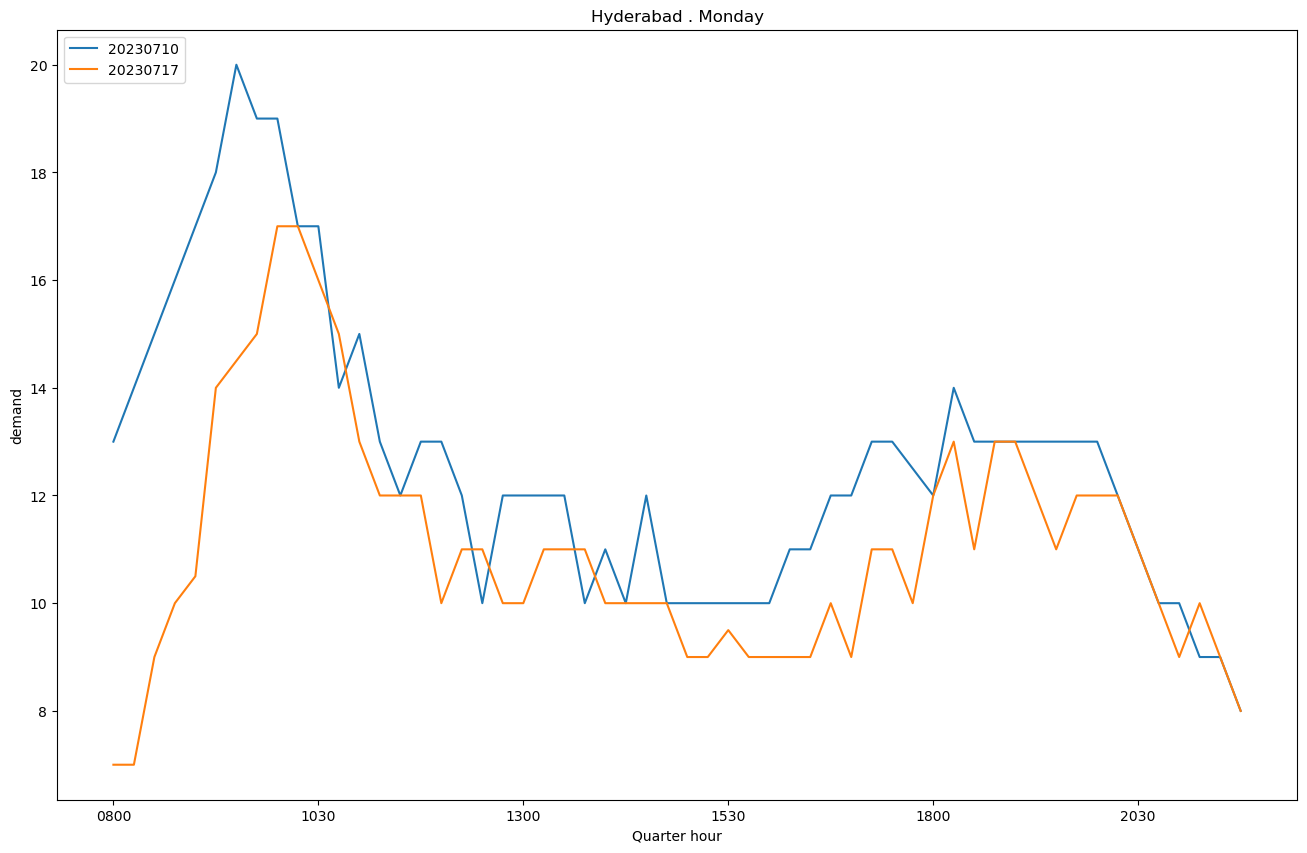

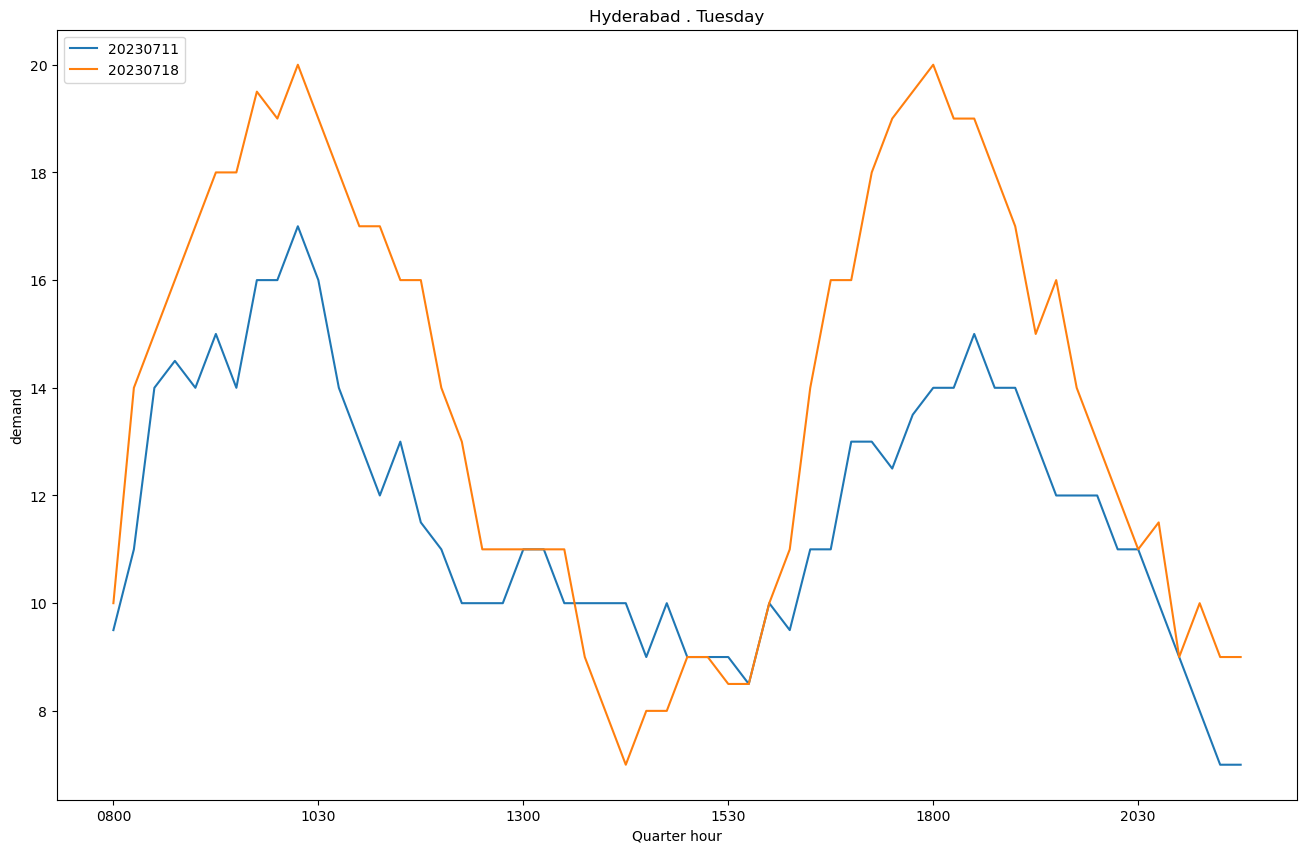

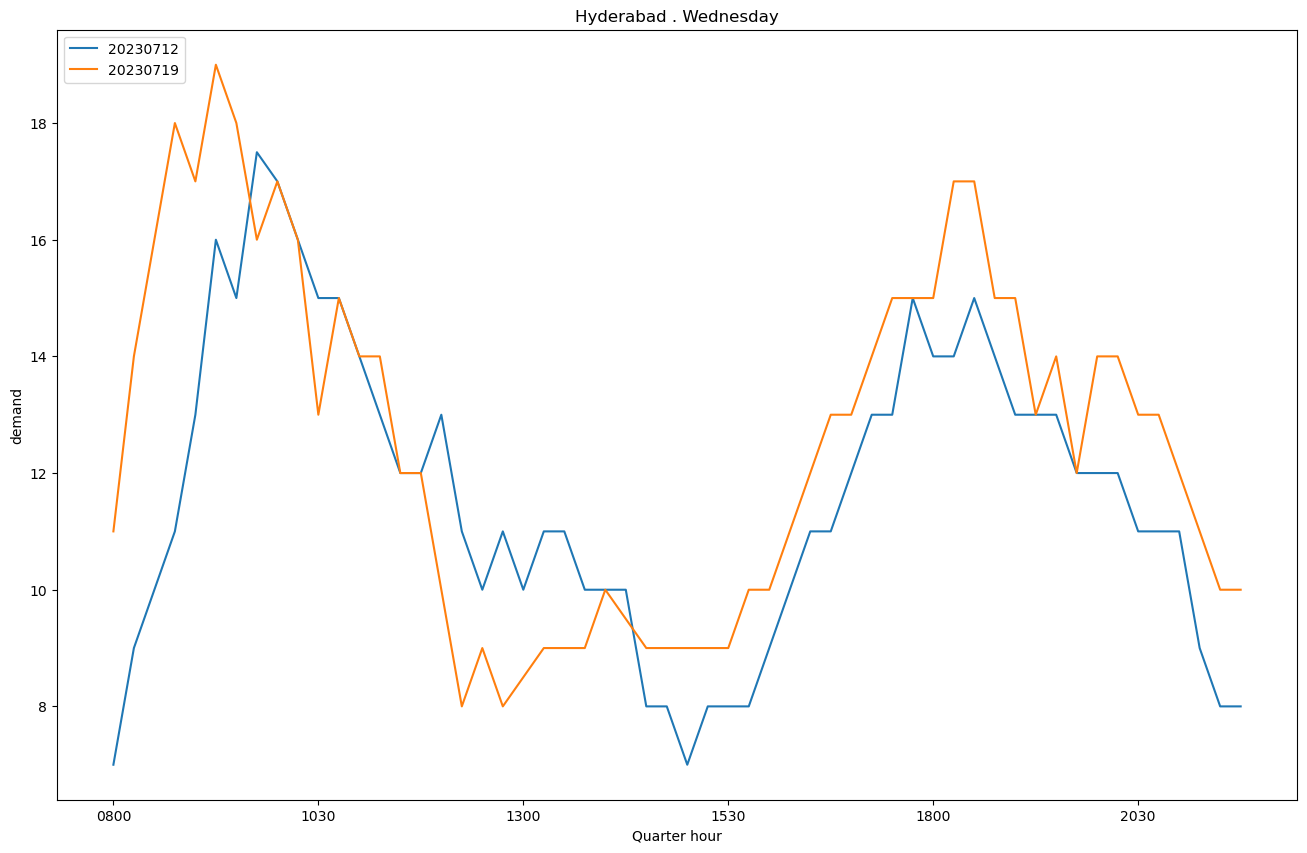

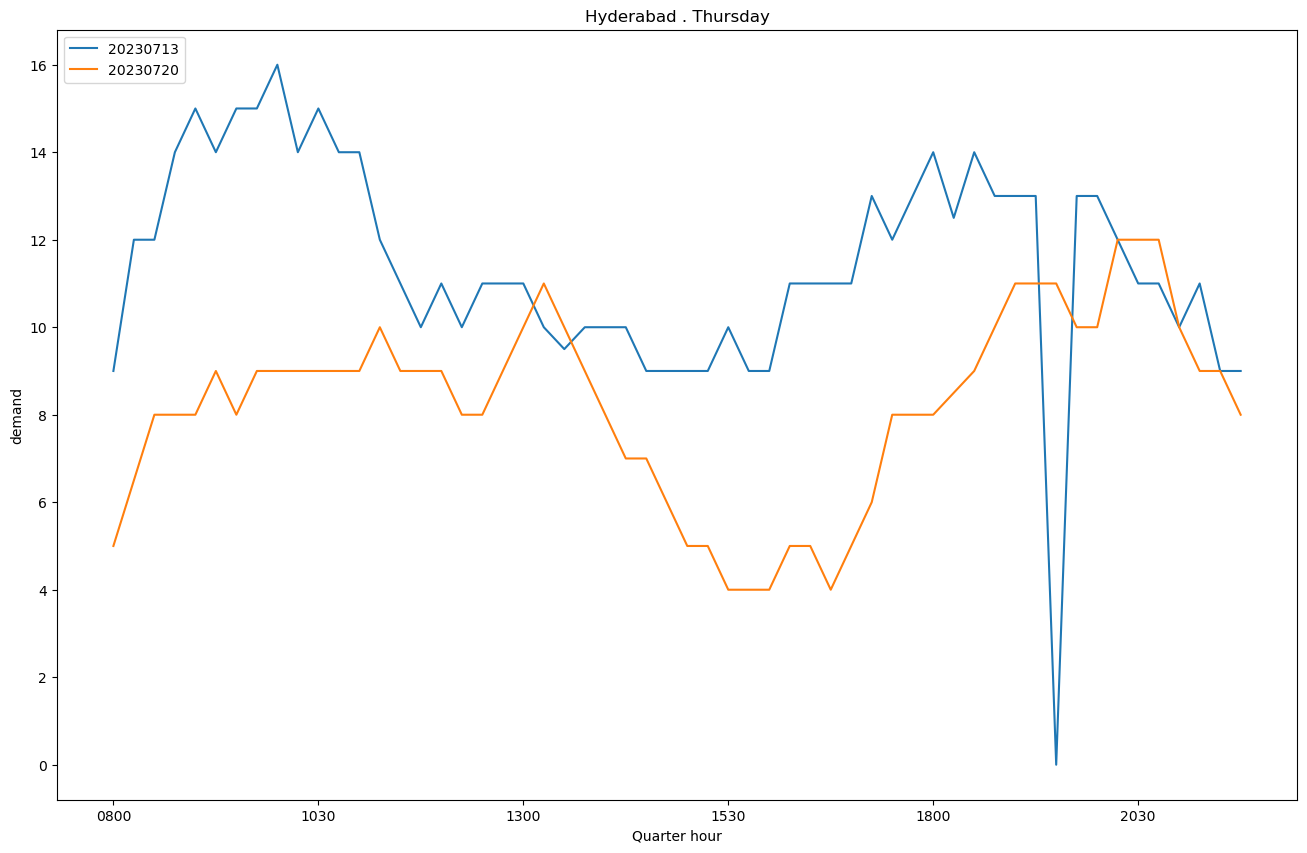

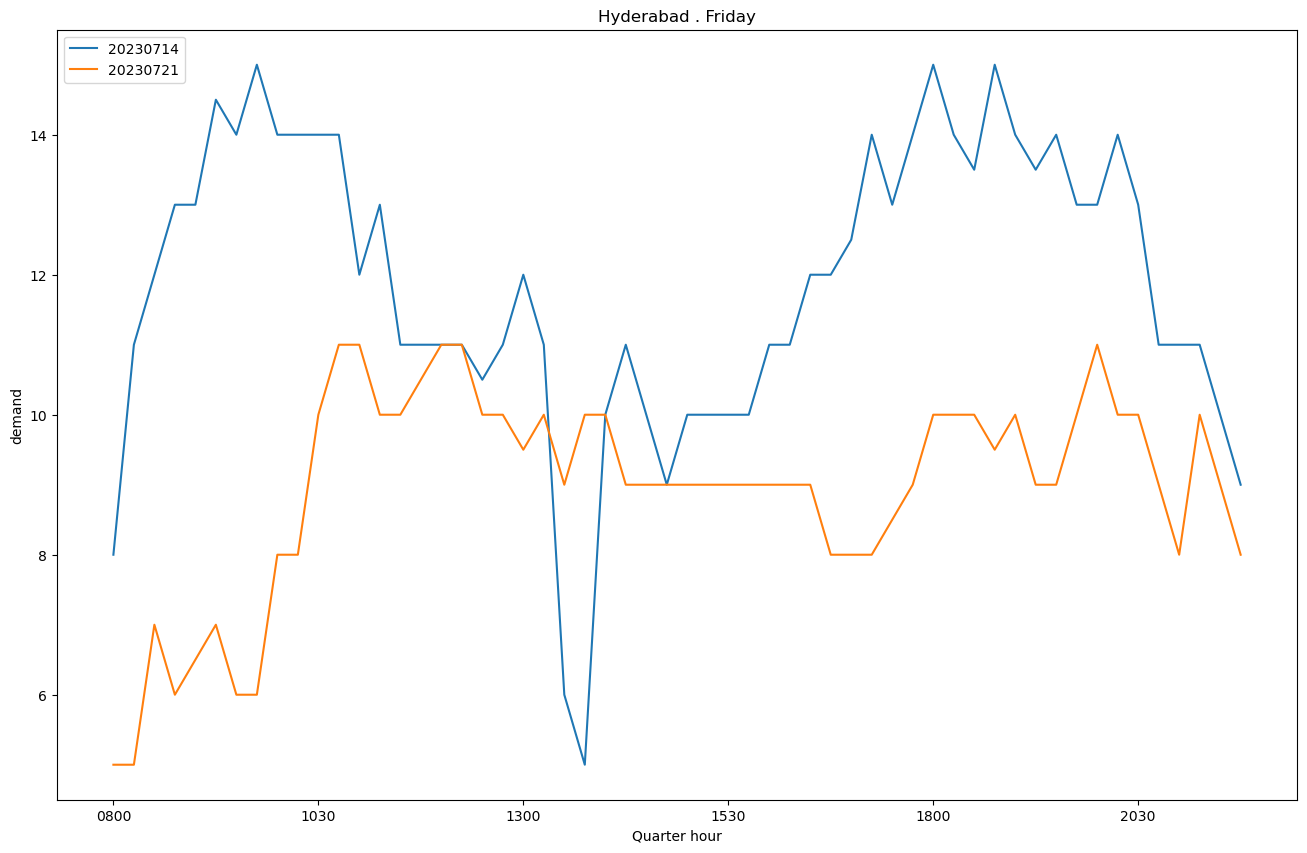

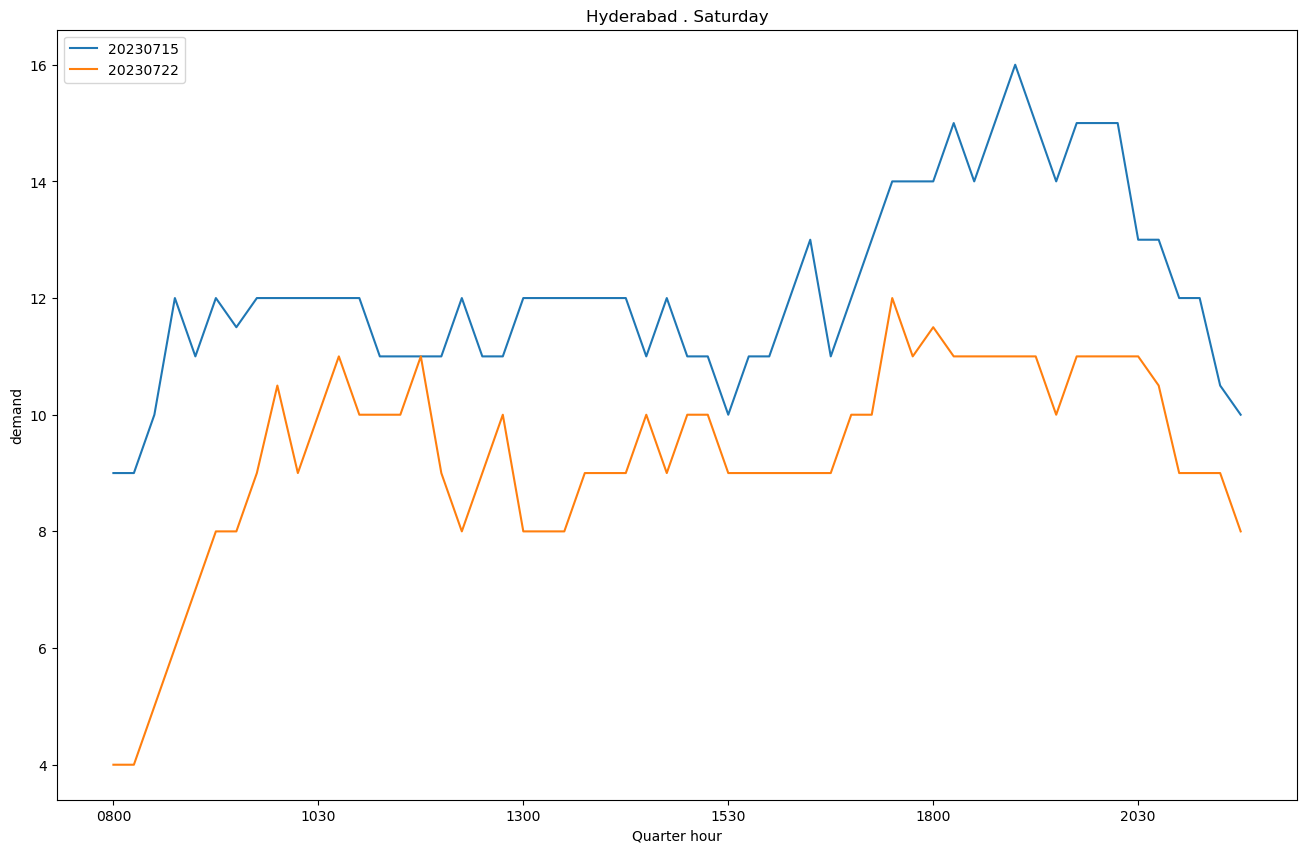

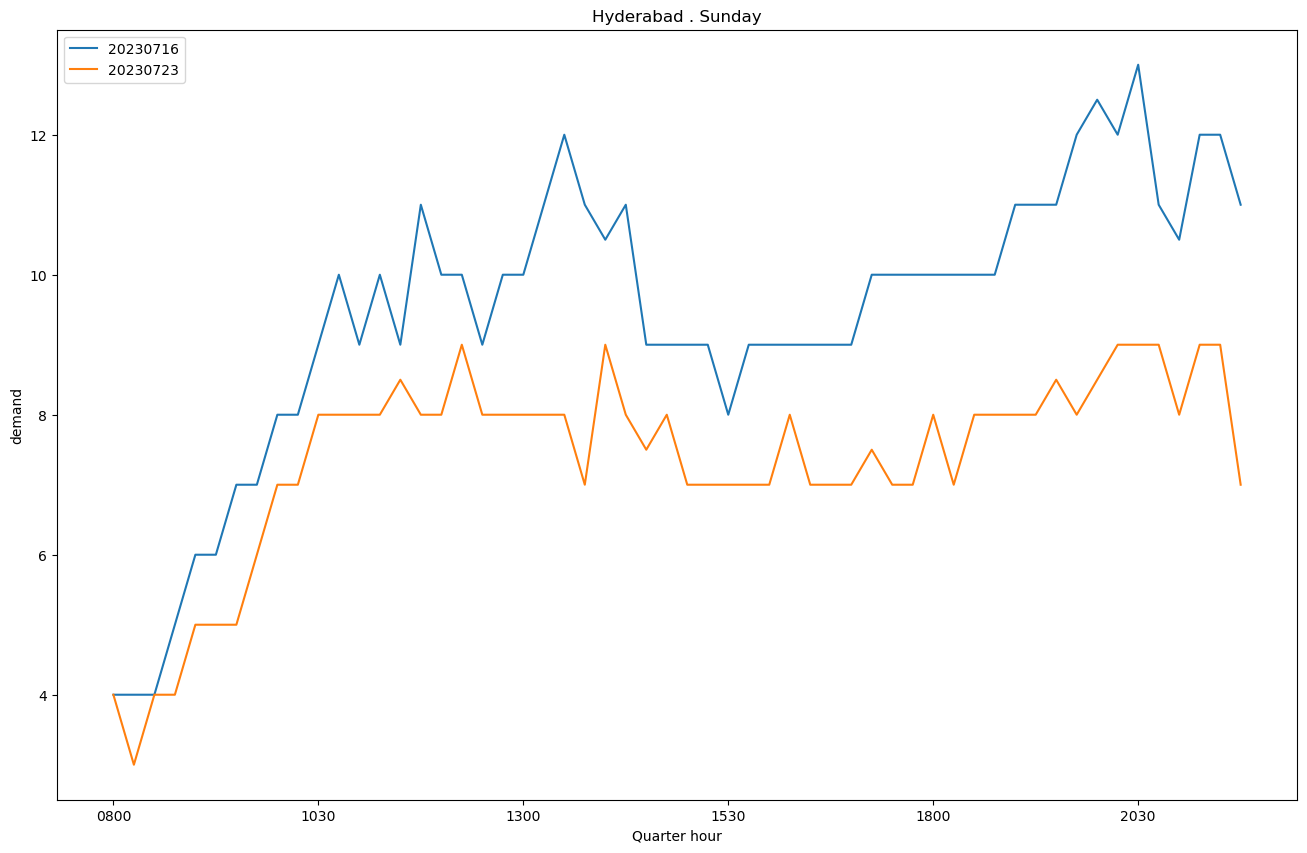

In [252]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    demand_each_wp = demand_counts[demand_counts['week_period'] == each_week_period]

    ax = demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('demand');

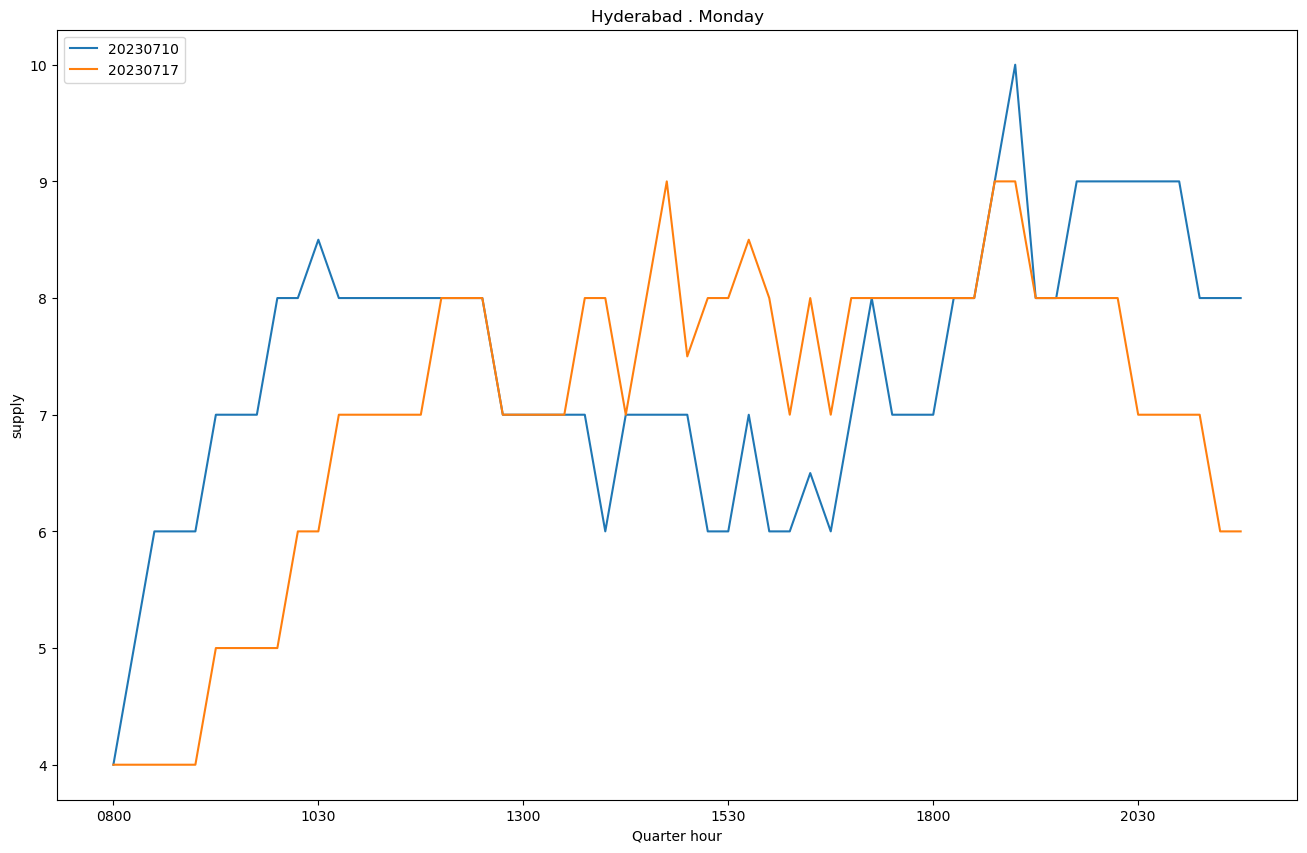

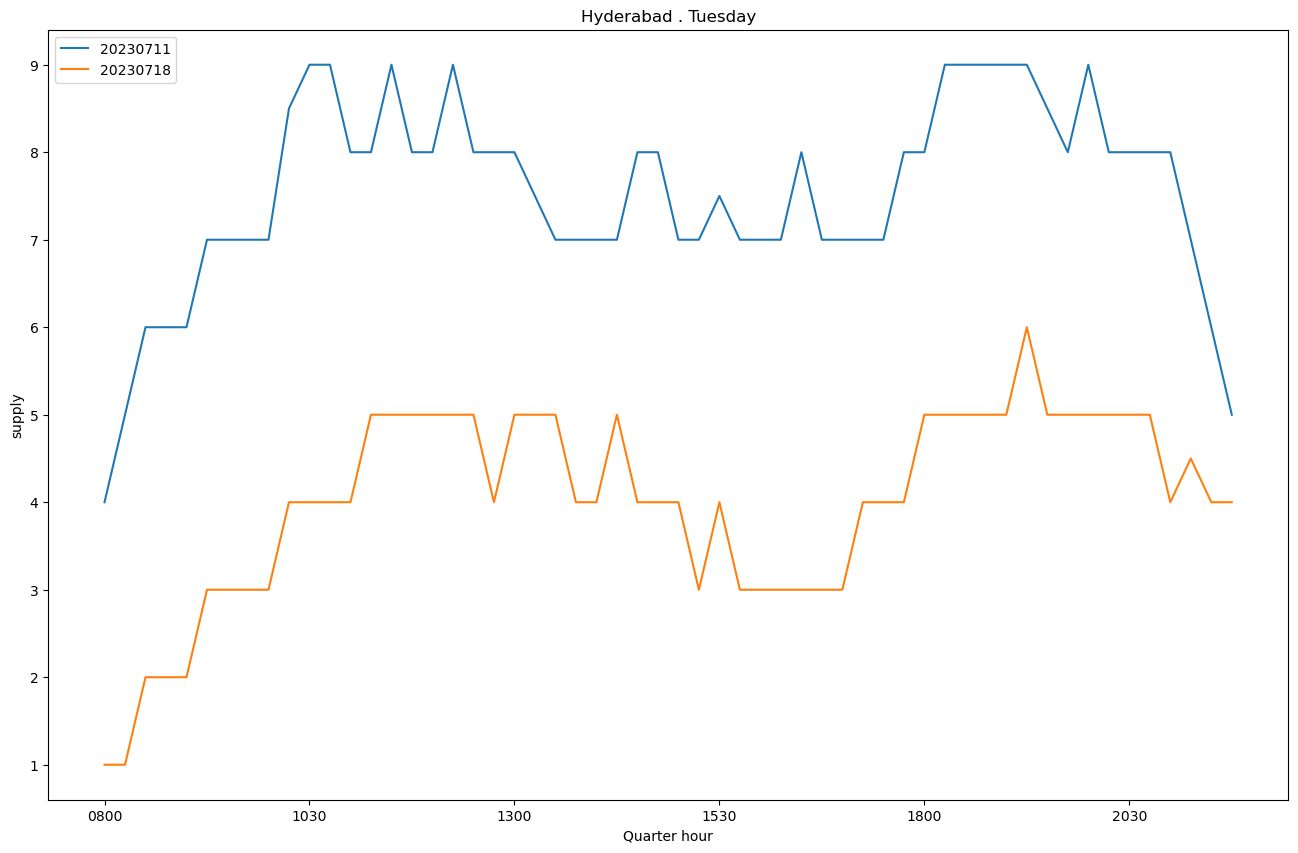

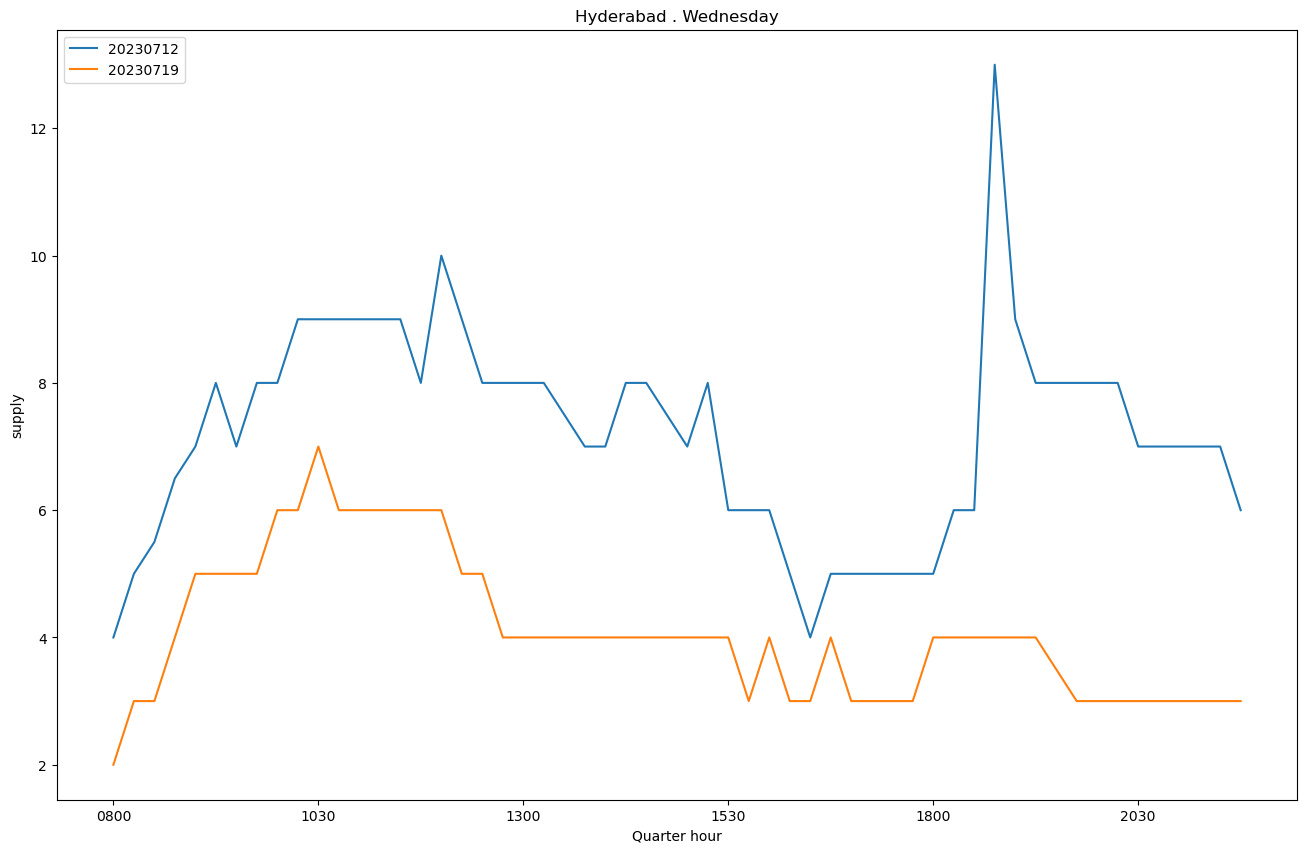

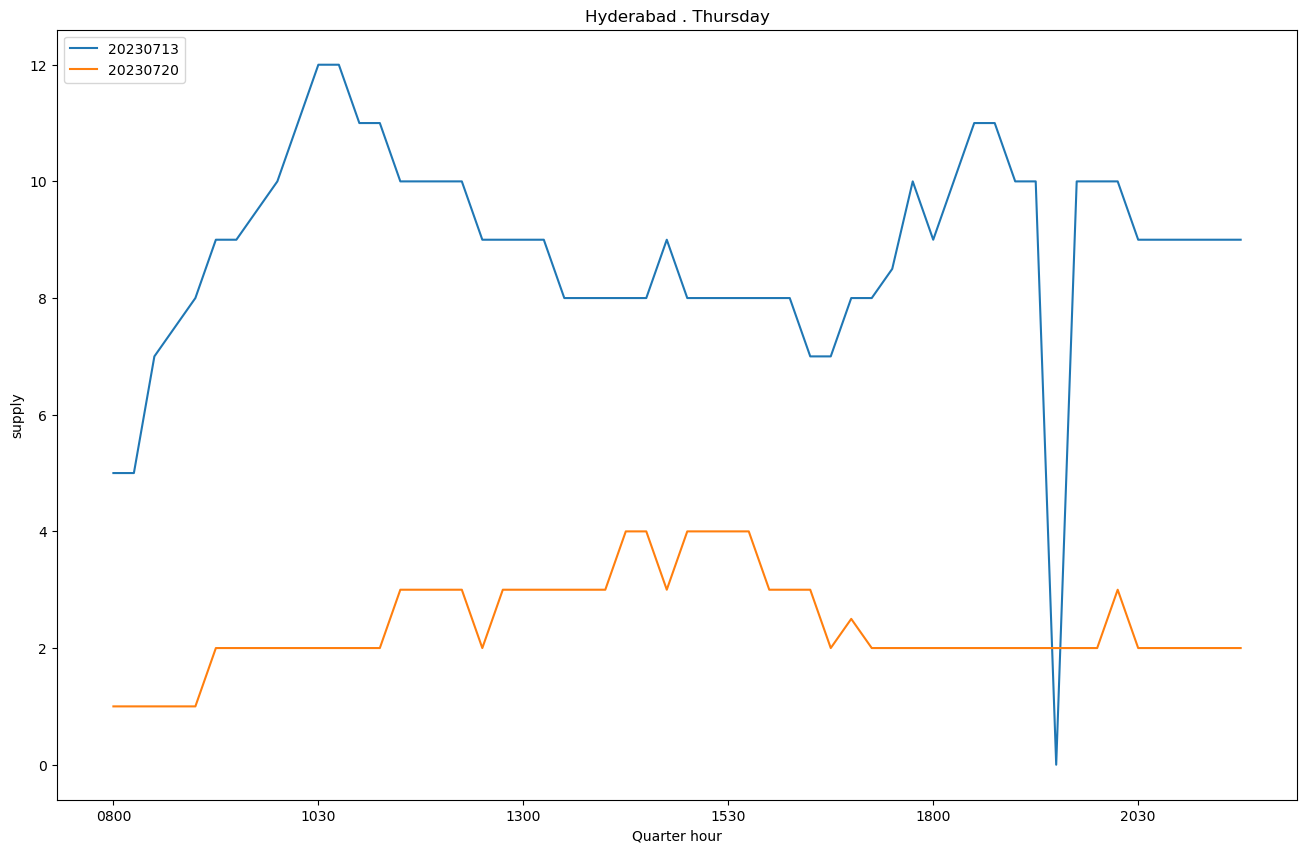

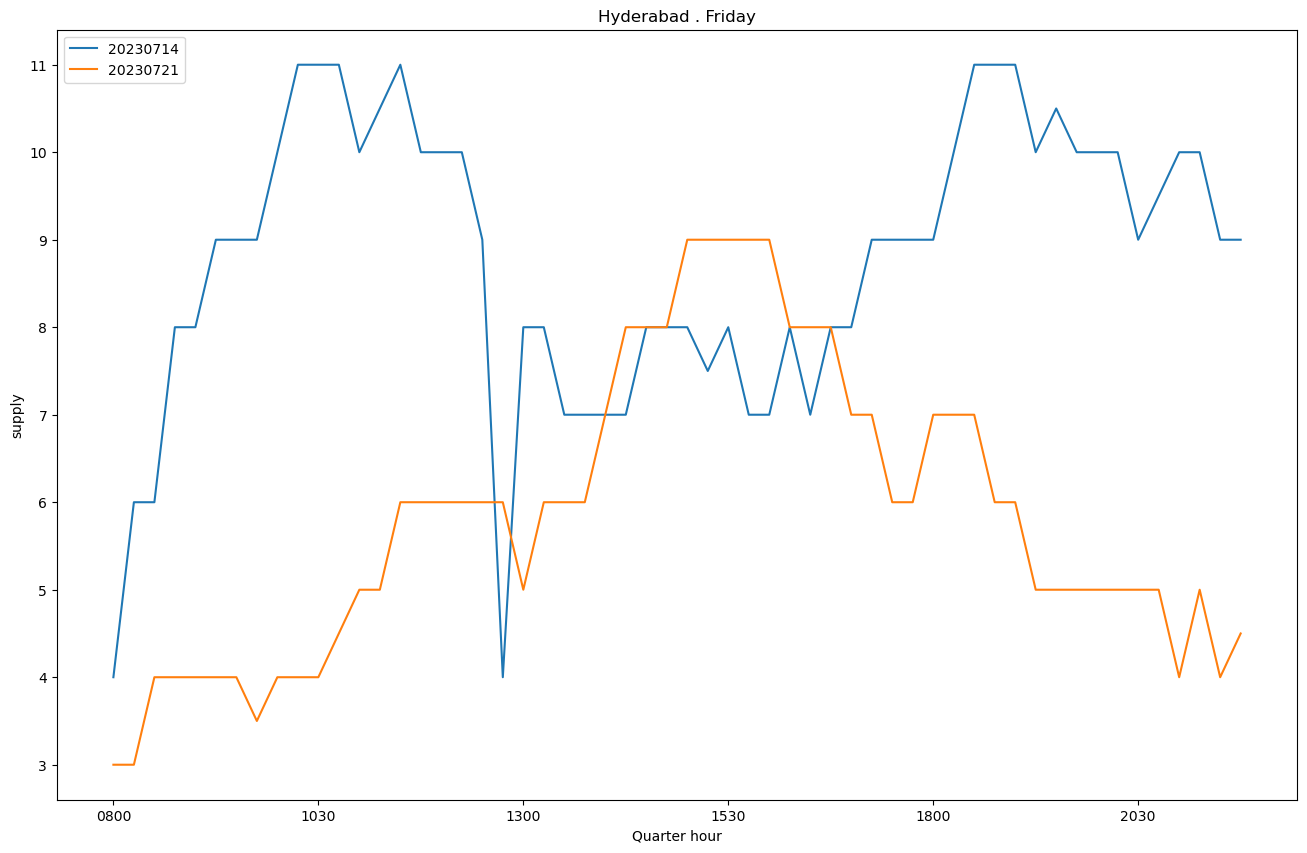

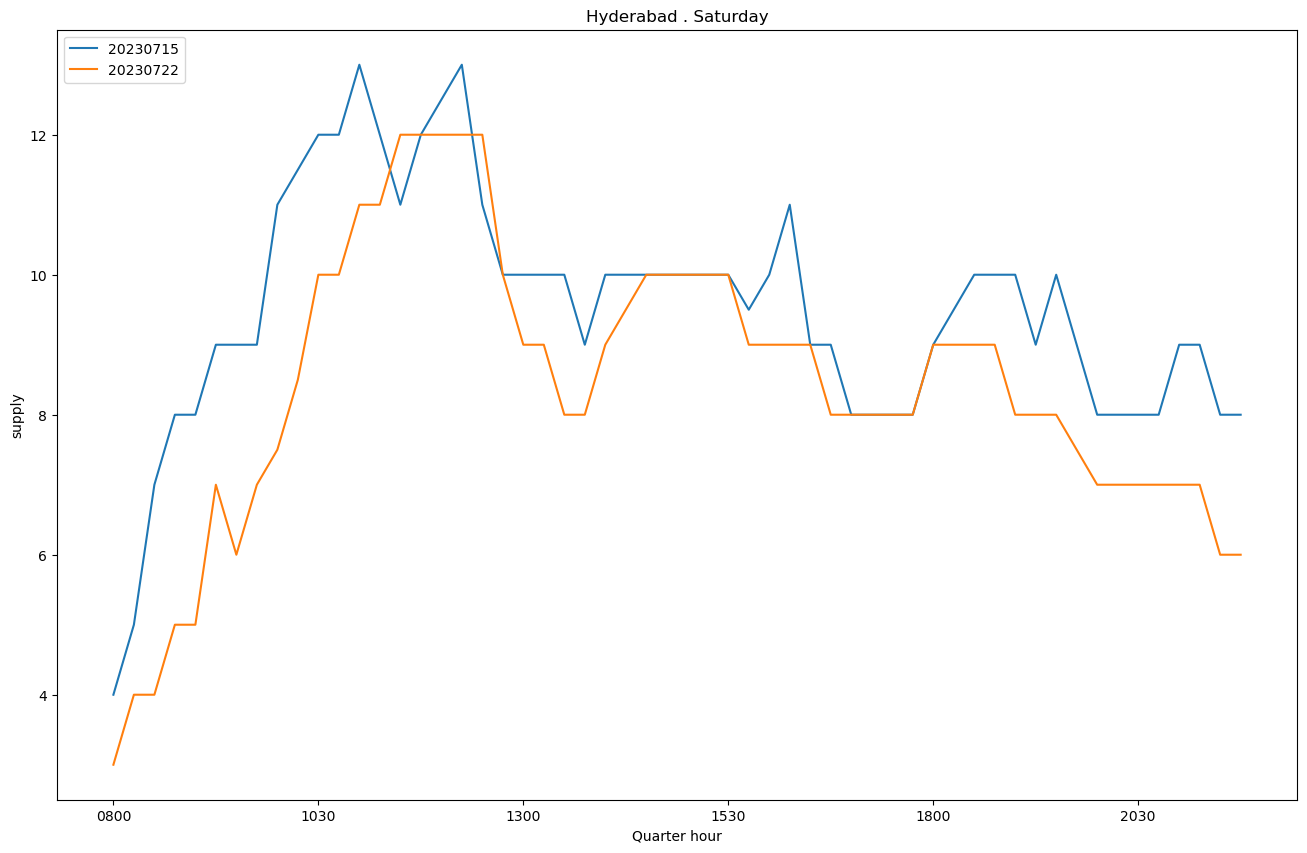

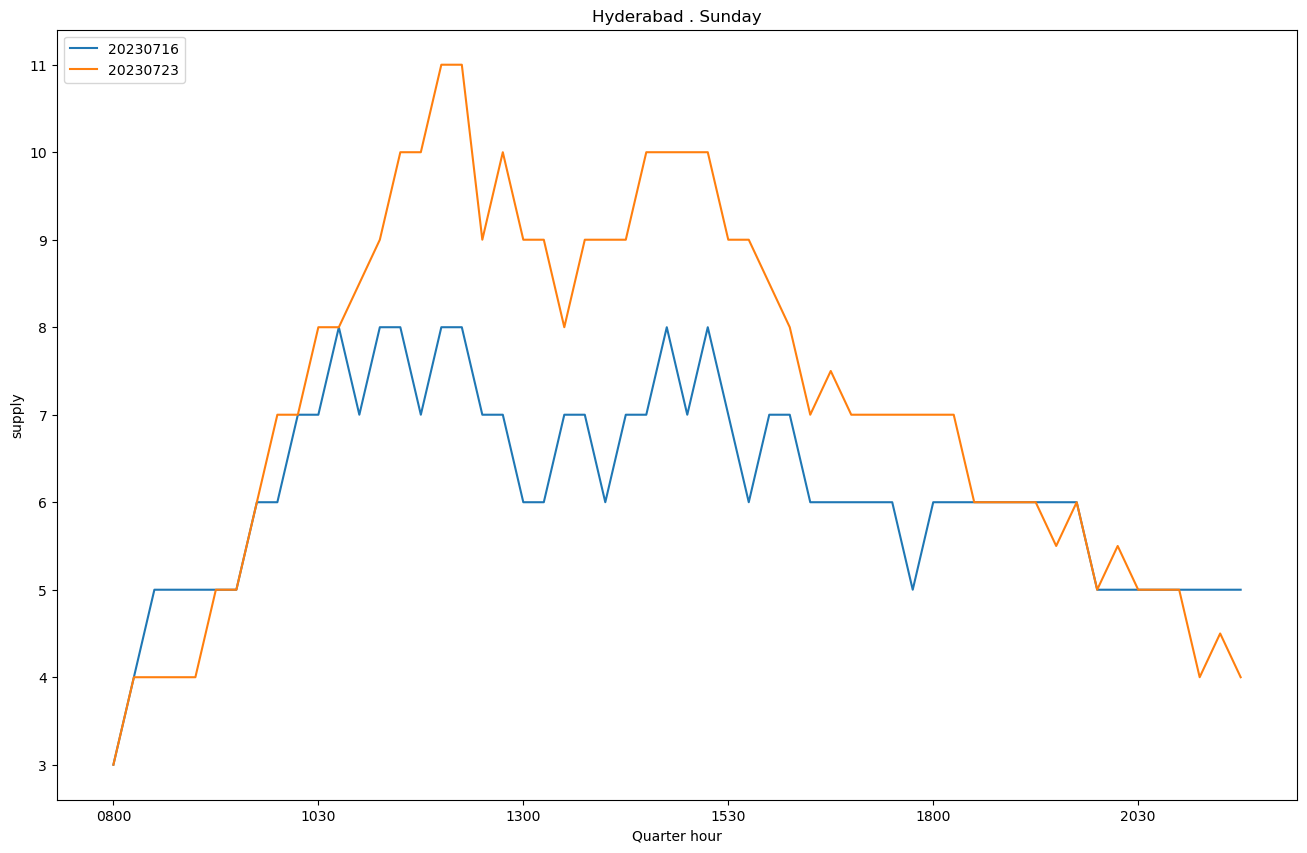

In [253]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    supply_each_wp = supply_counts[supply_counts['week_period'] == each_week_period]

    ax = supply_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='supply').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('supply');

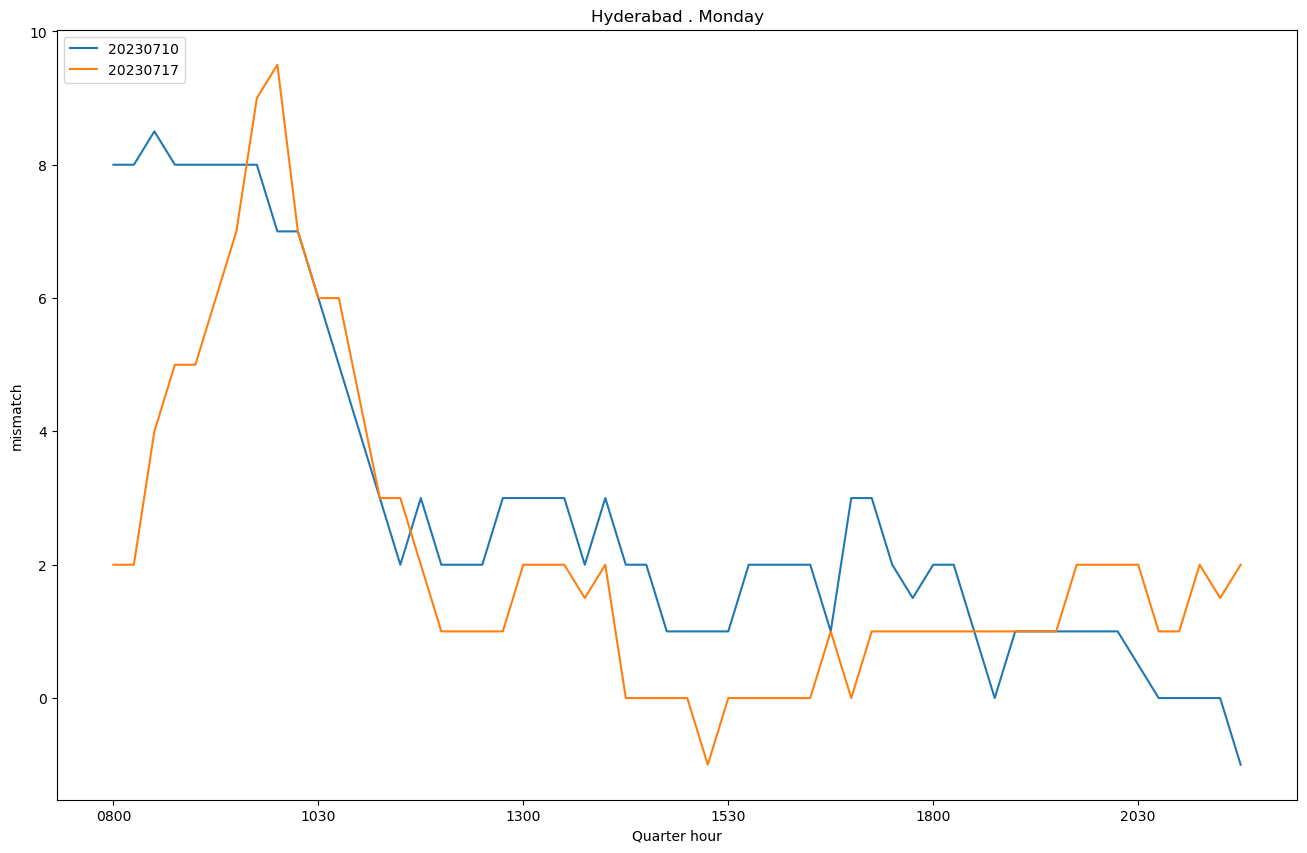

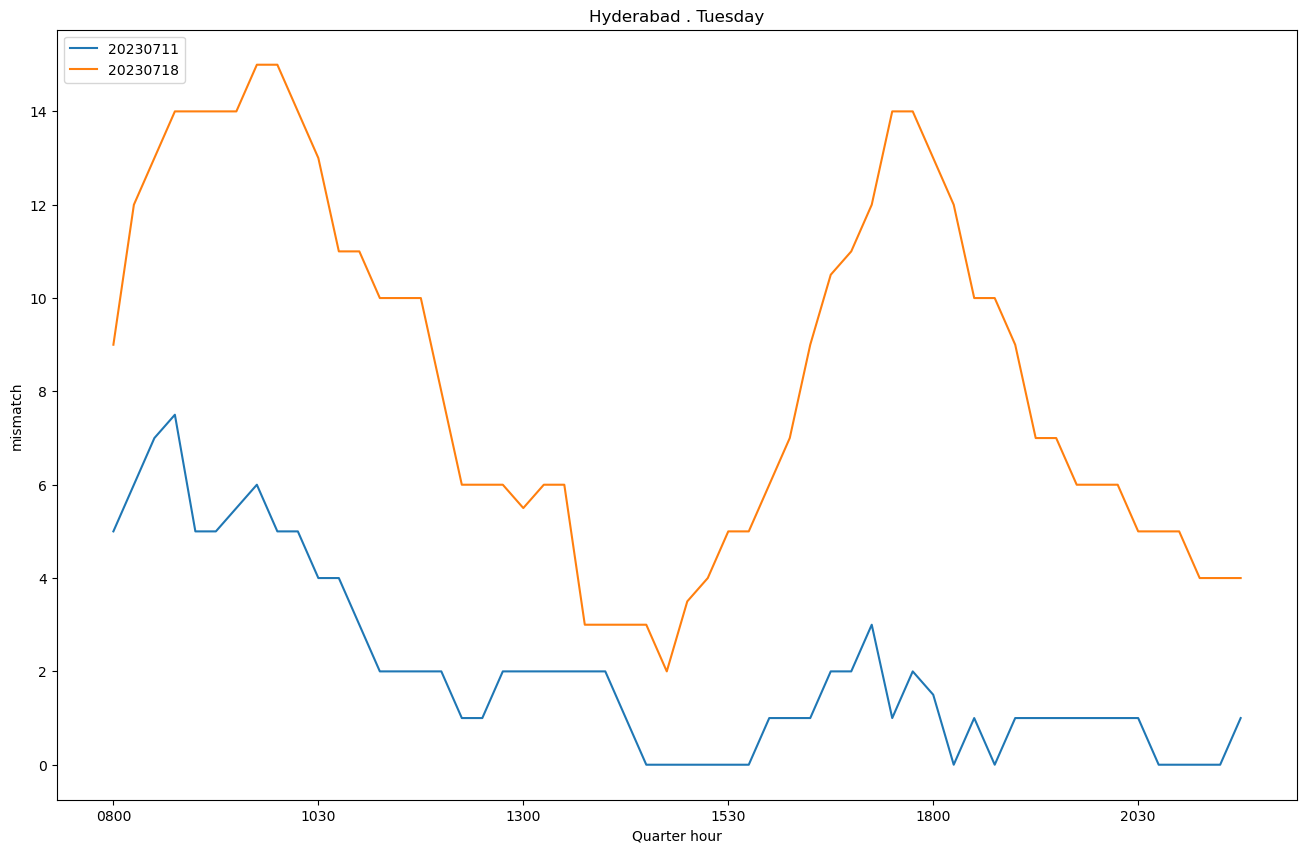

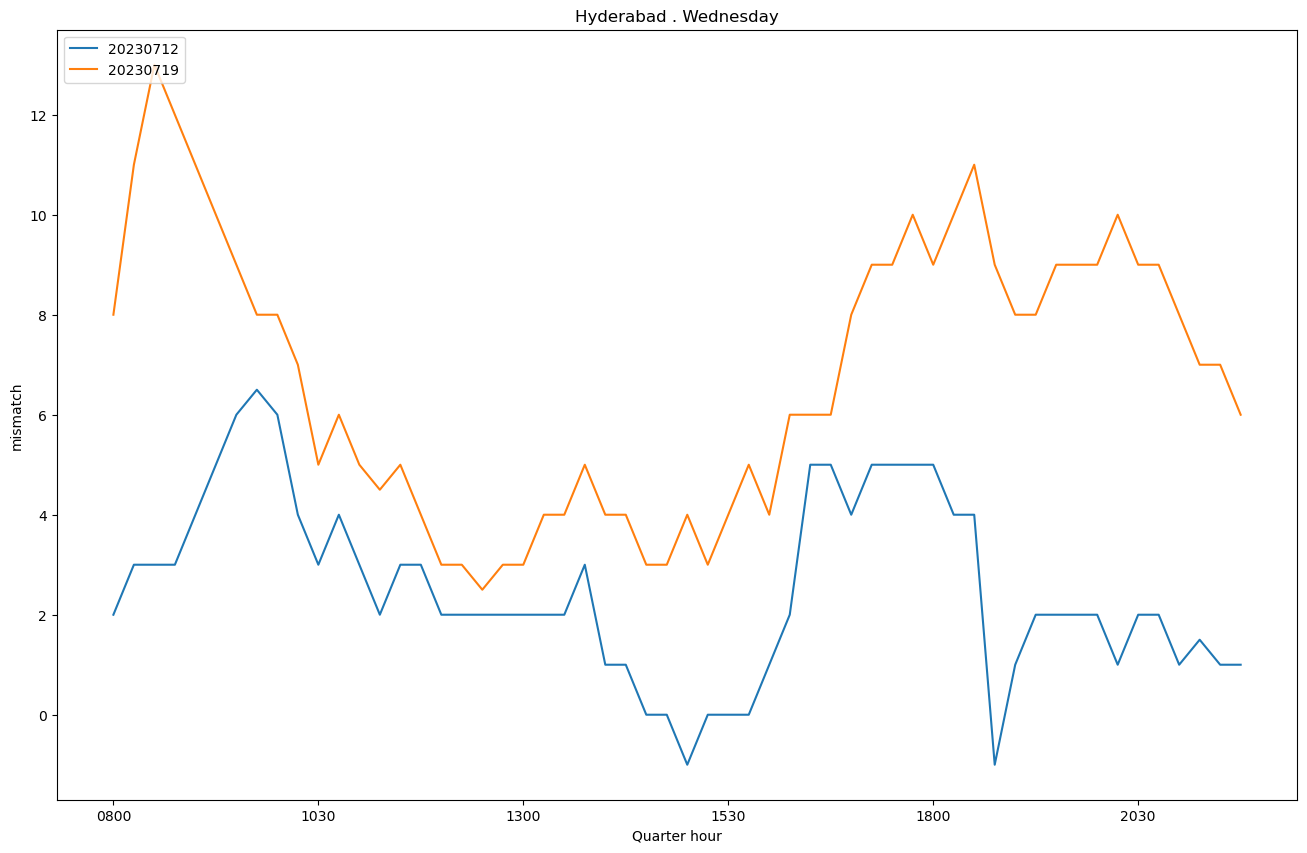

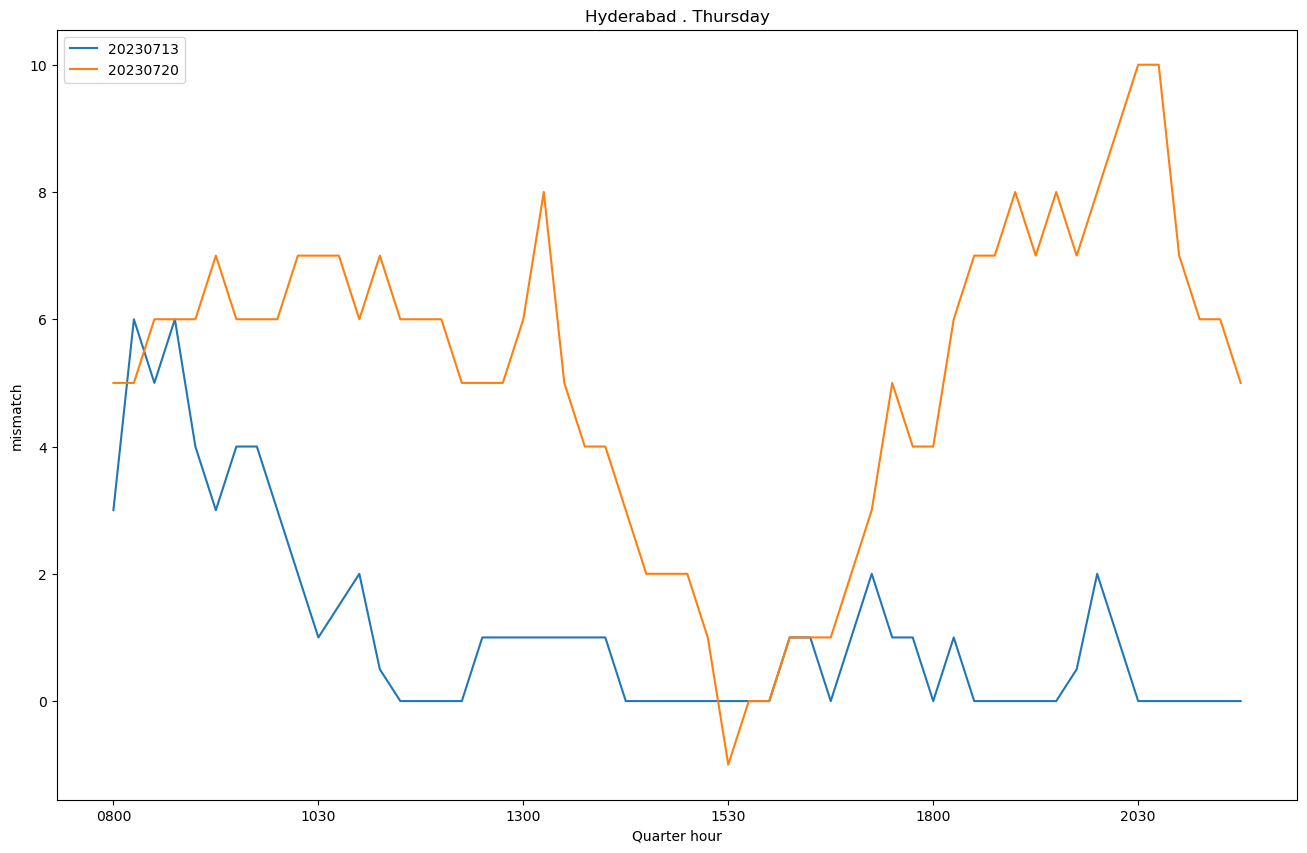

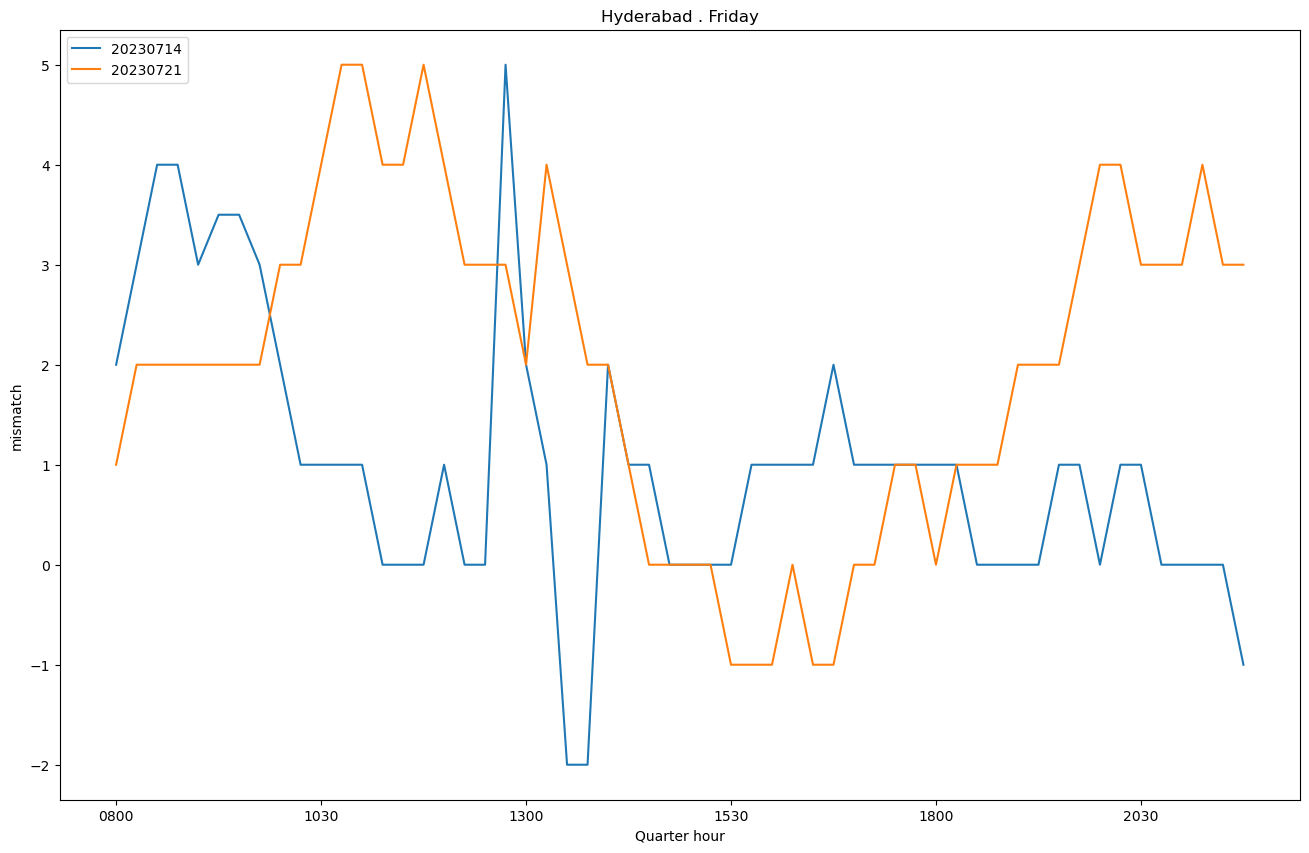

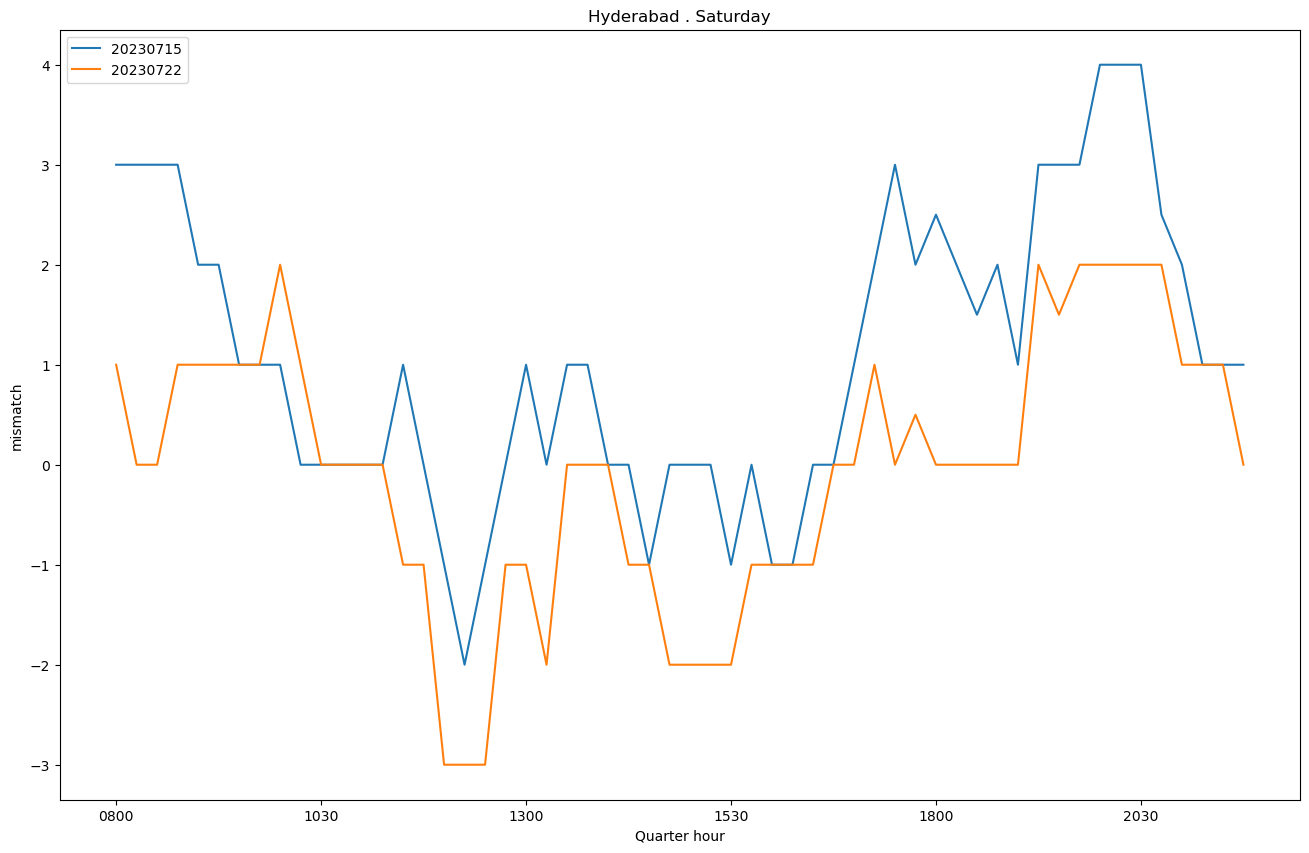

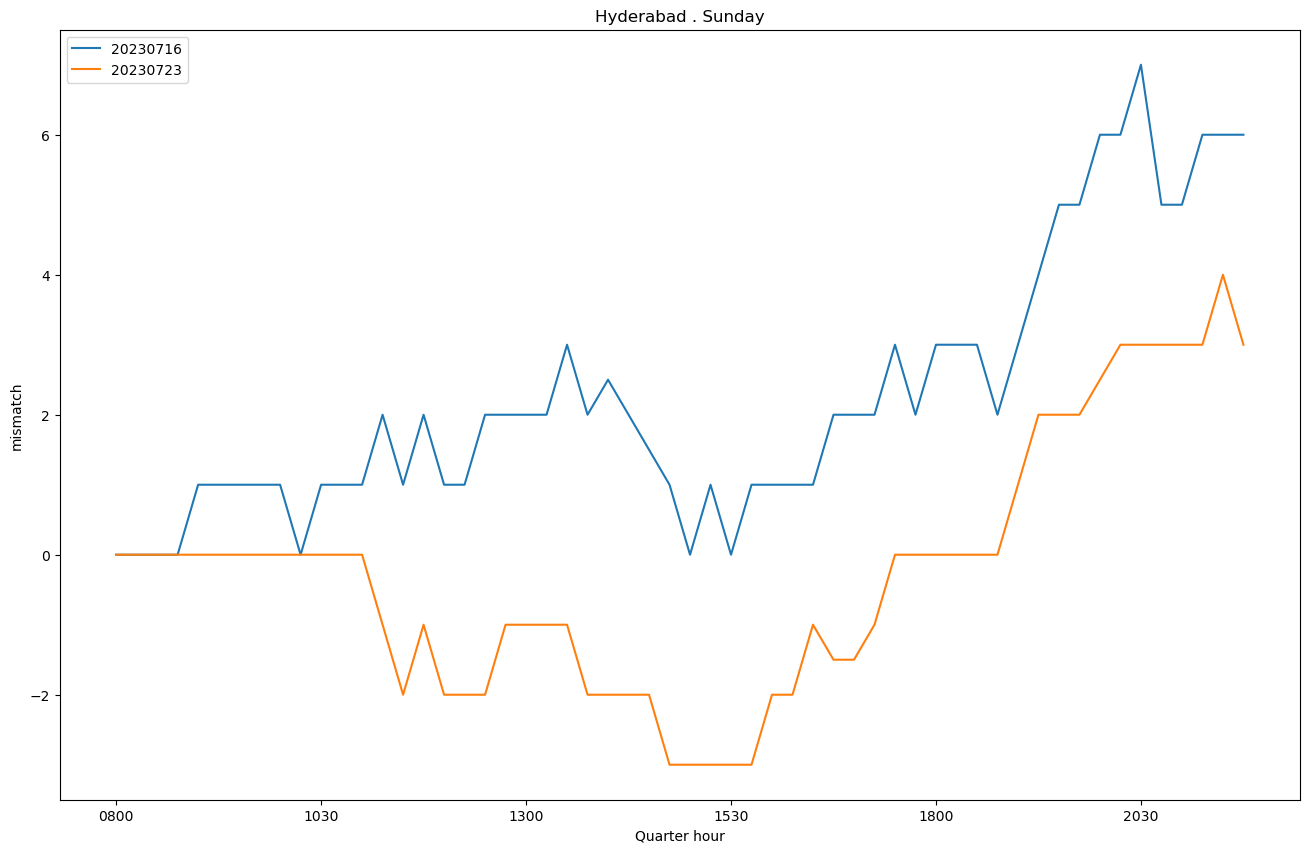

In [254]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    mismatch_each_wp = mismatch_counts[mismatch_counts['week_period'] == each_week_period]

    ax = mismatch_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='mismatch').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('mismatch');

### At city and time period level

In [255]:
# Demand view at city and time period level for Link orders.
deamnd_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='demand') \
    .reset_index()

print(deamnd_counts_tp.shape)
deamnd_counts_tp.head()

(42, 3)


service_detail_id  yyyymmdd   time_period  574013f14fdf4798208bba26
0                  20230710     afternoon                      11.0
1                  20230710  evening_peak                      12.0
2                  20230710  morning_peak                      15.0
3                  20230711     afternoon                      10.0
4                  20230711  evening_peak                      11.0

In [256]:
# Supply view at city level and time_period for Link orders.
supply_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='supply') \
    .reset_index()

print(supply_counts_tp.shape)
supply_counts_tp.head()

(42, 3)


service_detail_id  yyyymmdd   time_period  574013f14fdf4798208bba26
0                  20230710     afternoon                       7.0
1                  20230710  evening_peak                       8.0
2                  20230710  morning_peak                       7.0
3                  20230711     afternoon                       7.0
4                  20230711  evening_peak                       8.0

In [257]:
# Mismatch view at city and time_period level for Link orders.
mismatch_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='mismatch') \
    .reset_index()

print(mismatch_counts_tp.shape)
mismatch_counts_tp.head()

(42, 3)


service_detail_id  yyyymmdd   time_period  574013f14fdf4798208bba26
0                  20230710     afternoon                       2.0
1                  20230710  evening_peak                       1.0
2                  20230710  morning_peak                       6.0
3                  20230711     afternoon                       1.0
4                  20230711  evening_peak                       1.0

### Check for cluster temporal combinations for which dcf_data has mismatch positive, 
* what is the supply
* what is the demand 

In [258]:
# clusters_post_idle_captain_threshold_filter = ['Gachibowli', 'Nanakramguda 2', 'Hitech City',
#        'Wipro Nanakramguda Circle', 'Wipro Gachibowli Campus',
#        'Manikonda', 'shilparamam', 'Kukatpally 3', 'Shamshabad',
#        'Banjara Hills', 'Bahadurguda', 'Quthbullapur', 'Saroor Nagar',
#        'Bodduppal', 'Hitech City 2', 'Mansoorabad', 'Miyapur 2',
#        'Hafeezpet', 'Hayath Nagar', 'Jeedimetla', 'Kukatpally',
#        'Kothaguda 2', 'BHEL']


clusters_post_idle_captain_threshold_filter = cluster_temporal_combinations_selected.pickup_cluster.unique().tolist()


dcf_data.head()

service_detail_id   orderdate quarter_hour  \
1  574013f14fdf4798208bba26  2023-07-10         0800   
3  574013f14fdf4798208bba26  2023-07-10         0815   
5  574013f14fdf4798208bba26  2023-07-10         0815   
7  574013f14fdf4798208bba26  2023-07-10         0815   
9  574013f14fdf4798208bba26  2023-07-10         0830   

              pickup_cluster  gross_orders  net_orders  mean_distance  demand  \
1  Wipro Nanakramguda Circle            10           8       5.376625     1.0   
3                Bahadurguda            19          19       6.914500    17.0   
5                  Balanagar            50          37       7.056701    66.0   
7   Telecom Nagar Gachibowli            14          11       5.594000     0.0   
9                  Balanagar            55          35       5.581947    54.0   

   supply   time_period  ...       city  yyyymmdd  fe_count  rr_count  \
1    78.0  morning_peak  ...  Hyderabad  20230710        22        12   
3    10.0  morning_peak  ...  Hyderabad  20230710        85        20   
5    12.0  morning_peak  ...  Hyderabad  20230710       227        54   
7     0.0  morning_peak  ...  Hyderabad  20230710        45        14   
9    16.0  morning_peak  ...  Hyderabad  20230710       252        69   

   net_count  FE2RR   G2N  FE2Net  week_period mismatch  
1          8   54.5  66.7    36.4       Monday    -77.0  
3         19   23.5  95.0    22.4       Monday      7.0  
5         37   23.8  68.5    16.3       Monday     54.0  
7         11   31.1  78.6    24.4       Monday      0.0  
9         35   27.4  50.7    13.9       Monday     38.0  

[5 rows x 21 columns]

In [259]:
dcf_data_filtered_on_supply = dcf_data[dcf_data['pickup_cluster'].isin(clusters_post_idle_captain_threshold_filter)]

dcf_data_filtered_on_supply.head()

service_detail_id   orderdate quarter_hour  \
1   574013f14fdf4798208bba26  2023-07-10         0800   
3   574013f14fdf4798208bba26  2023-07-10         0815   
25  574013f14fdf4798208bba26  2023-07-10         1000   
31  574013f14fdf4798208bba26  2023-07-10         1015   
38  574013f14fdf4798208bba26  2023-07-10         1045   

               pickup_cluster  gross_orders  net_orders  mean_distance  \
1   Wipro Nanakramguda Circle            10           8       5.376625   
3                 Bahadurguda            19          19       6.914500   
25                shilparamam            38          34       4.744024   
31                Hitech City           388         301       3.882611   
38                Bahadurguda            20          19       5.505569   

    demand  supply   time_period  ...       city  yyyymmdd  fe_count  \
1      1.0    78.0  morning_peak  ...  Hyderabad  20230710        22   
3     17.0    10.0  morning_peak  ...  Hyderabad  20230710        85   
25    41.0    37.0  morning_peak  ...  Hyderabad  20230710       157   
31   364.0   210.0  morning_peak  ...  Hyderabad  20230710      1596   
38    25.0    31.0  morning_peak  ...  Hyderabad  20230710        89   

    rr_count  net_count  FE2RR   G2N  FE2Net  week_period mismatch  
1         12          8   54.5  66.7    36.4       Monday    -77.0  
3         20         19   23.5  95.0    22.4       Monday      7.0  
25        41         34   26.1  82.9    21.7       Monday      4.0  
31       436        301   27.3  69.0    18.9       Monday    154.0  
38        20         19   22.5  95.0    21.3       Monday     -6.0  

[5 rows x 21 columns]

In [260]:
dcf_data_filtered_on_supply.quarter_hour.unique()

array(['0800', '0815', '1000', '1015', '1045', '1115', '1145', '1230',
       '1245', '1330', '1445', '1500', '1515', '1600', '1630', '1645',
       '1730', '1815', '1830', '1845', '1900', '1915', '1930', '1945',
       '2000', '2015', '2030', '2045', '2115', '0830', '0930', '0945',
       '1100', '1130', '1200', '1215', '1530', '1745', '1800', '0915',
       '1030', '1315', '1415', '1615', '1715', '0845', '1400', '1430',
       '1345', '1700', '1300', '1545', '2100', '2130', '2145', '0900'],
      dtype=object)

In [261]:
## morning peak vs evening peak vs afternoon peak of dcf_data post supply filter

cluster_name = clusters_post_idle_captain_threshold_filter[0]

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply[
    dcf_data_filtered_on_supply['pickup_cluster'] == cluster_name]

dcf_data_filtered_on_supply_one_cluster.head()

service_detail_id   orderdate quarter_hour pickup_cluster  \
90    574013f14fdf4798208bba26  2023-07-10         1600     Gachibowli   
416   574013f14fdf4798208bba26  2023-07-12         1615     Gachibowli   
472   574013f14fdf4798208bba26  2023-07-12         2030     Gachibowli   
1985  574013f14fdf4798208bba26  2023-07-23         1645     Gachibowli   
2082  574013f14fdf4798208bba26  2023-07-10         0800     Gachibowli   

      gross_orders  net_orders  mean_distance  demand  supply   time_period  \
90              30          25       6.214811    23.0    12.0     afternoon   
416             41          23       5.093807    24.0    18.0     afternoon   
472             37          21       4.966398    34.0    10.0  evening_peak   
1985            15           9       4.472400    14.0    11.0     afternoon   
2082            21          16       3.668344    13.0   338.0  morning_peak   

      ...       city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  \
90    ...  Hyderabad  20230710       181        33         25   18.2  75.8   
416   ...  Hyderabad  20230712       307        41         23   13.4  56.1   
472   ...  Hyderabad  20230712       248        44         21   17.7  47.7   
1985  ...  Hyderabad  20230723       154        17          9   11.0  52.9   
2082  ...  Hyderabad  20230710        74        21         16   28.4  76.2   

      FE2Net  week_period mismatch  
90      13.8       Monday     11.0  
416      7.5    Wednesday      6.0  
472      8.5    Wednesday     24.0  
1985     5.8       Sunday      3.0  
2082    21.6       Monday   -325.0  

[5 rows x 21 columns]

In [262]:
dcf_data_filtered_on_supply_one_cluster['quarter_hour'] = dcf_data_filtered_on_supply_one_cluster[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply_one_cluster[
    (dcf_data_filtered_on_supply_one_cluster['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply_one_cluster['quarter_hour'] <= 2100)]

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/1904698678.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [263]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply_one_cluster, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                            \
quarter_hour                  1100    1115    1130    1145  1200  1215  1230   
pickup_cluster week_period                                                     
Gachibowli     Friday       1055.0   937.0   755.5   827.0  60.0  76.0  65.0   
               Monday       1042.0  1283.5  1197.0  1316.5  80.0  68.5  64.5   
               Saturday      763.5   514.0   542.0   710.0  49.0  39.5  33.5   
               Sunday        362.0   335.0   439.0   392.0  22.0  27.5  19.5   
               Thursday      942.0   745.0   704.0   861.0  45.5  37.5  37.0   
               Tuesday       892.0   753.5   717.0  1009.0  67.0  59.5  49.0   
               Wednesday    1085.5   790.0   915.0  1101.5  63.5  49.0  41.0   

                                              ...                          \
quarter_hour                1245  1300  1315  ...  1845  1900  1915  1930   
pickup_cluster week_period                    ...                           
Gachibowli     Friday       52.0  71.0  41.0  ...  21.0  21.5  16.0  21.0   
               Monday       61.5  33.5  34.0  ...  19.5  23.5  15.0  18.5   
               Saturday     41.0  49.5  32.5  ...  23.5  21.0  20.0  19.0   
               Sunday       24.5  27.5  16.0  ...  15.5  15.0  14.0  12.5   
               Thursday     42.0  25.0  20.0  ...  13.5  13.5  11.5   2.0   
               Tuesday      53.0  46.0  29.0  ...  14.0  13.0  12.5  13.0   
               Wednesday    52.0  37.0  32.0  ...  20.0  12.0   9.5   9.5   

                                                                
quarter_hour                1945  2000  2015  2030  2045  2100  
pickup_cluster week_period                                      
Gachibowli     Friday       16.5  17.5  19.0  12.0  13.0  15.0  
               Monday       21.5  24.5  19.0  14.0  18.5  18.0  
               Saturday     22.5  27.5  21.5  13.0  14.0  17.5  
               Sunday       15.5  15.5  13.0  10.5  10.5  12.0  
               Thursday     10.5  15.0  12.0  11.0  12.5  12.0  
               Tuesday      15.5  21.5  20.0  12.5  12.0  13.5  
               Wednesday    13.5  17.5  15.0   9.0  13.5  13.5  

[7 rows x 41 columns]

In [264]:
dcf_data_filtered_on_supply['quarter_hour'] = dcf_data_filtered_on_supply[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply = dcf_data_filtered_on_supply[
    (dcf_data_filtered_on_supply['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply['quarter_hour'] <= 2100)]

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/2215548235.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [265]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                            \
quarter_hour                 1100  1115  1130  1145  1200  1215  1230  1245   
pickup_cluster week_period                                                    
BHEL           Friday         9.5   9.0  11.5  12.0  18.0  35.0  30.0  20.0   
               Monday         9.0  12.5  14.0  13.0  17.5  22.0  12.5  18.0   
               Saturday      20.0  22.5  20.5  22.0  28.5  37.0  31.0  24.0   
               Sunday        13.5  15.5  20.5  24.0  35.0  31.5  39.0  25.5   
               Thursday       7.5   8.5  10.0  10.5  12.5  16.5   9.5  12.0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
shilparamam    Saturday      55.5  63.0  67.5  50.0  59.5  64.0  47.0  41.5   
               Sunday        47.5  46.0  48.5  43.0  56.0  48.5  49.5  42.5   
               Thursday      32.0  29.0  38.5  33.5  31.5  25.5  22.0  30.5   
               Tuesday       36.5  41.0  42.0  29.5  35.0  37.5  30.5  31.5   
               Wednesday     41.0  40.0  44.0  42.5  36.0  38.0  32.0  33.0   

                                        ...                                \
quarter_hour                1300  1315  ...  1845  1900  1915  1930  1945   
pickup_cluster week_period              ...                                 
BHEL           Friday       19.0  33.5  ...  31.0  33.5  29.0  30.0  20.0   
               Monday       16.5  22.0  ...  39.0  35.5  36.5  31.5  28.0   
               Saturday     31.0  34.5  ...  45.0  37.5  31.0  30.0  28.5   
               Sunday       26.0  29.0  ...  25.0  20.0  18.0  17.5  16.0   
               Thursday     13.5  16.5  ...  28.0  24.0  20.0   2.5  17.5   
...                          ...   ...  ...   ...   ...   ...   ...   ...   
shilparamam    Saturday     42.5  35.0  ...  43.0  42.5  40.0  42.0  43.0   
               Sunday       44.5  36.0  ...  27.5  32.0  31.5  26.0  26.0   
               Thursday     21.0  24.5  ...  29.0  32.5  25.0   6.0  26.5   
               Tuesday      23.5  26.0  ...  33.0  33.5  35.5  37.0  34.0   
               Wednesday    29.0  24.5  ...  36.0  35.0  33.5  33.0  32.5   

                                                          
quarter_hour                2000  2015  2030  2045  2100  
pickup_cluster week_period                                
BHEL           Friday       23.5  23.0  25.5  24.0  27.0  
               Monday       24.5  26.0  27.5  28.5  30.0  
               Saturday     25.0  25.0  28.5  27.5  27.0  
               Sunday       16.5  14.5  14.0  16.5  12.5  
               Thursday     14.0  15.0  22.0  15.0  16.5  
...                          ...   ...   ...   ...   ...  
shilparamam    Saturday     36.5  35.5  22.0  28.5  29.5  
               Sunday       19.0  18.5  14.0  18.5  17.5  
               Thursday     24.0  27.5  24.0  20.0  19.5  
               Tuesday      33.5  35.5  30.0  27.0  31.5  
               Wednesday    24.5  30.5  28.0  21.0  21.0  

[161 rows x 41 columns]

In [266]:
dcf_data.head()

service_detail_id   orderdate quarter_hour  \
1  574013f14fdf4798208bba26  2023-07-10         0800   
3  574013f14fdf4798208bba26  2023-07-10         0815   
5  574013f14fdf4798208bba26  2023-07-10         0815   
7  574013f14fdf4798208bba26  2023-07-10         0815   
9  574013f14fdf4798208bba26  2023-07-10         0830   

              pickup_cluster  gross_orders  net_orders  mean_distance  demand  \
1  Wipro Nanakramguda Circle            10           8       5.376625     1.0   
3                Bahadurguda            19          19       6.914500    17.0   
5                  Balanagar            50          37       7.056701    66.0   
7   Telecom Nagar Gachibowli            14          11       5.594000     0.0   
9                  Balanagar            55          35       5.581947    54.0   

   supply   time_period  ...       city  yyyymmdd  fe_count  rr_count  \
1    78.0  morning_peak  ...  Hyderabad  20230710        22        12   
3    10.0  morning_peak  ...  Hyderabad  20230710        85        20   
5    12.0  morning_peak  ...  Hyderabad  20230710       227        54   
7     0.0  morning_peak  ...  Hyderabad  20230710        45        14   
9    16.0  morning_peak  ...  Hyderabad  20230710       252        69   

   net_count  FE2RR   G2N  FE2Net  week_period mismatch  
1          8   54.5  66.7    36.4       Monday    -77.0  
3         19   23.5  95.0    22.4       Monday      7.0  
5         37   23.8  68.5    16.3       Monday     54.0  
7         11   31.1  78.6    24.4       Monday      0.0  
9         35   27.4  50.7    13.9       Monday     38.0  

[5 rows x 21 columns]

In [267]:
dcf_data.demand.median()

10.0

In [268]:
dcf_data['hour'] = dcf_data['quarter_hour'].apply(lambda x: str(x[0:2]))
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data_stats_hour_level = dcf_data.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period','hour']).agg(
    demand = pd.NamedAgg('demand','sum'), 
    supply = pd.NamedAgg('supply','sum'),
    mismatch = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','hour','time_period'])

dcf_data_stats_hour_level['mismtach_pred'] = dcf_data_stats_hour_level['demand'] - dcf_data_stats_hour_level['supply']

dcf_data_stats_hour_level.head(20)

city pickup_cluster         service_detail_id week_period  \
10  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
11  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
12  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
13  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
0   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
2   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
3   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
4   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
5   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
6   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
7   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
8   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
9   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
24  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
25  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
26  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
27  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
14  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
15  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   

     time_period hour  demand  supply  mismatch  fe_count  rr_count  \
10  morning_peak   08   200.0    66.0      15.0       995       225   
11  morning_peak   09   192.0   135.0       7.0      2578       198   
12  morning_peak   10   214.0   146.0       8.5      1667       221   
13  morning_peak   11   179.0   141.0       6.5      1023       201   
0      afternoon   12   192.0   153.0       6.0       996       198   
1      afternoon   13   137.0   152.0      -1.0       959       163   
2      afternoon   14   159.0   174.0      -2.0       791       159   
3      afternoon   15   118.0   169.0      -6.5       801       123   
4      afternoon   16   121.0   179.0      -8.5       893       136   
5   evening_peak   17   133.0   190.0      -8.0      1139       126   
6   evening_peak   18   127.0   226.0     -11.0       976       129   
7   evening_peak   19   136.0   174.0      -4.5       828       163   
8   evening_peak   20   172.0   158.0      -2.0       682       157   
9   evening_peak   21   111.0   127.0      -0.5       451       100   
24  morning_peak   08   280.0    51.0      25.0      1447       366   
25  morning_peak   09   330.0   100.0      26.5      2149       414   
26  morning_peak   10   279.0   116.0      20.0      1695       285   
27  morning_peak   11   247.0   137.0      12.0      1408       215   
14     afternoon   12   196.0   157.0       3.0      1157       193   
15     afternoon   13   181.0   139.0       6.0       952       202   

    net_count  mismtach_pred  
10        145          134.0  
11        113           57.0  
12        136           68.0  
13        127           38.0  
0         132           39.0  
1         112          -15.0  
2         118          -15.0  
3          95          -51.0  
4         102          -58.0  
5          87          -57.0  
6          97          -99.0  
7         113          -38.0  
8         109           14.0  
9          72          -16.0  
24        152          229.0  
25        191          230.0  
26        186          163.0  
27        163          110.0  
14        147           39.0  
15        154           42.0

In [269]:
dcf_data_stats_hour_level['excess_supply_ratio'] = dcf_data_stats_hour_level[
    'supply']/dcf_data_stats_hour_level['demand']

dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'
dcf_data_stats_hour_level.head()

city pickup_cluster         service_detail_id week_period  \
10  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
11  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
12  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
13  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
0   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   

     time_period hour  demand  supply  mismatch  fe_count  rr_count  \
10  morning_peak   08   200.0    66.0      15.0       995       225   
11  morning_peak   09   192.0   135.0       7.0      2578       198   
12  morning_peak   10   214.0   146.0       8.5      1667       221   
13  morning_peak   11   179.0   141.0       6.5      1023       201   
0      afternoon   12   192.0   153.0       6.0       996       198   

    net_count  mismtach_pred  excess_supply_ratio is_excess_supply  
10        145          134.0             0.330000               no  
11        113           57.0             0.703125               no  
12        136           68.0             0.682243               no  
13        127           38.0             0.787709               no  
0         132           39.0             0.796875               no

In [270]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_hour_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply', 'fe_count', 'rr_count','net_count'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period','hour']
                                          )
dcf_data_stats_hour_level_pivot

demand                                           \
time_period                afternoon                             evening_peak   
hour                              12     13     14     15     16           17   
pickup_cluster week_period                                                      
AOC Centre     Friday          192.0  137.0  159.0  118.0  121.0        133.0   
               Monday          196.0  181.0  153.0  132.0  175.0        183.0   
               Saturday        162.0  164.0  132.0  136.0  157.0        191.0   
               Sunday          148.0  189.0  175.0  155.0  154.0        180.0   
               Thursday        179.0  169.0  124.0   96.0   95.0        118.0   
...                              ...    ...    ...    ...    ...          ...   
shilparamam    Saturday        161.0  171.0  143.0  124.0  170.0        192.0   
               Sunday          156.0  156.0  151.0  135.0  141.0        136.0   
               Thursday        130.0  164.0  134.0  104.0   87.0        135.0   
               Tuesday         150.0  170.0  107.0  124.0  160.0        207.0   
               Wednesday       159.0  157.0  119.0  120.0  159.0        169.0   

                                                        ...    supply  \
time_period                                             ... afternoon   
hour                           18     19     20     21  ...        16   
pickup_cluster week_period                              ...             
AOC Centre     Friday       127.0  136.0  172.0  111.0  ...     179.0   
               Monday       196.0  190.0  163.0  157.0  ...     176.0   
               Saturday     179.0  192.0  170.0  153.0  ...     305.0   
               Sunday       182.0  235.0  193.0  188.0  ...     145.0   
               Thursday     127.0  114.0  137.0   82.0  ...     130.0   
...                           ...    ...    ...    ...  ...       ...   
shilparamam    Saturday     185.0  202.0  169.0  121.0  ...     310.0   
               Sunday       152.0  149.0  138.0  147.0  ...     305.0   
               Thursday     152.0  133.0  141.0  128.0  ...     194.0   
               Tuesday      209.0  176.0  148.0  103.0  ...     200.0   
               Wednesday    175.0  162.0  137.0  127.0  ...     174.0   

                                                                     \
time_period                evening_peak                               
hour                                 17     18     19     20     21   
pickup_cluster week_period                                            
AOC Centre     Friday             190.0  226.0  174.0  158.0  127.0   
               Monday             189.0  219.0  216.0  172.0  151.0   
               Saturday           229.0  251.0  217.0  185.0  162.0   
               Sunday             171.0  146.0  135.0  126.0   93.0   
               Thursday           161.0  198.0  140.0  138.0  116.0   
...                                 ...    ...    ...    ...    ...   
shilparamam    Saturday           315.0  398.0  335.0  245.0  226.0   
               Sunday             239.0  249.0  231.0  140.0  155.0   
               Thursday           177.0  250.0  180.0  191.0  150.0   
               Tuesday            215.0  297.0  280.0  252.0  204.0   
               Wednesday          169.0  237.0  268.0  208.0  155.0   

                                                              
time_period                morning_peak                       
hour                                 08     09     10     11  
pickup_cluster week_period                                    
AOC Centre     Friday              66.0  135.0  146.0  141.0  
               Monday              51.0  100.0  116.0  137.0  
               Saturday            75.0  118.0  168.0  200.0  
               Sunday              73.0   88.0  140.0  191.0  
               Thursday            50.0   93.0  118.0  136.0  
...                                 ...    ...    ...    ...  
shilparamam    Saturda

In [271]:
dcf_data_stats_hour_level.groupby(
    ['pickup_cluster','week_period','time_period','hour']).is_excess_supply.value_counts()

pickup_cluster  week_period  time_period   hour  is_excess_supply
AOC Centre      Friday       afternoon     12    no                  1
                                           13    yes                 1
                                           14    yes                 1
                                           15    yes                 1
                                           16    yes                 1
                                                                    ..
shilparamam     Wednesday    evening_peak  21    yes                 1
                             morning_peak  08    no                  1
                                           09    no                  1
                                           10    yes                 1
                                           11    yes                 1
Name: is_excess_supply, Length: 20278, dtype: int64

In [272]:
check_for_excess_idle_captains = dcf_data_stats_hour_level[dcf_data_stats_hour_level['pickup_cluster'].isin(
    clusters_post_idle_captain_threshold_filter)]

In [273]:
check_for_excess_idle_captains = check_for_excess_idle_captains.dropna()

In [274]:
check_for_excess_idle_captains.head()

city pickup_cluster         service_detail_id week_period  \
1284  Hyderabad           BHEL  574013f14fdf4798208bba26      Friday   
1285  Hyderabad           BHEL  574013f14fdf4798208bba26      Friday   
1286  Hyderabad           BHEL  574013f14fdf4798208bba26      Friday   
1287  Hyderabad           BHEL  574013f14fdf4798208bba26      Friday   
1274  Hyderabad           BHEL  574013f14fdf4798208bba26      Friday   

       time_period hour  demand  supply  mismatch  fe_count  rr_count  \
1284  morning_peak   08   168.0    77.0       8.5       901       168   
1285  morning_peak   09   151.0    77.0       7.5      1639       194   
1286  morning_peak   10   183.0    61.0      11.0      1531       197   
1287  morning_peak   11   175.0    84.0      10.5      1062       206   
1274     afternoon   12   163.0   206.0      -1.5       984       165   

      net_count  mismtach_pred  excess_supply_ratio is_excess_supply  
1284         99           91.0             0.458333               no  
1285         93           74.0             0.509934               no  
1286        102          122.0             0.333333               no  
1287        107           91.0             0.480000               no  
1274         97          -43.0             1.263804              yes

In [275]:
dcf_data_stats_tp_level = dcf_data_stats_hour_level.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period']).agg(
    demand = pd.NamedAgg('demand','median'), 
    supply = pd.NamedAgg('supply','median'),
    mismatch_qr_level = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum'),
    fe_count_med = pd.NamedAgg('fe_count','median'), 
    rr_count_med = pd.NamedAgg('rr_count','median'), 
    net_count_med = pd.NamedAgg('net_count','median')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','time_period'])

dcf_data_stats_tp_level['mismtach_pred_tp'] = dcf_data_stats_tp_level['demand'] - dcf_data_stats_tp_level['supply']

dcf_data_stats_tp_level.head(20)

city pickup_cluster         service_detail_id week_period  \
0   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
2   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
3   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
4   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
5   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
6   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
7   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
8   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
9   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
10  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
11  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
12  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
13  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
14  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
15  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   
16  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   
17  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   
18  Hyderabad     AOC Centre  574013f14fdf4798208bba26   Wednesday   
19  Hyderabad     AOC Centre  574013f14fdf4798208bba26   Wednesday   

     time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0      afternoon   137.0   169.0              -2.00      4440       779   
1   evening_peak   133.0   174.0              -4.50      4076       675   
2   morning_peak   196.0   138.0               7.75      6263       845   
3      afternoon   175.0   171.0               0.50      5174       873   
4   evening_peak   183.0   189.0              -2.00      4864       918   
5   morning_peak   279.5   108.0              22.50      6699      1280   
6      afternoon   157.0   305.0             -20.50      5446       774   
7   evening_peak   179.0   217.0              -2.50      4821       877   
8   morning_peak   200.5   143.0               5.75      3690       811   
9      afternoon   155.0   186.0              -0.50      6671       871   
10  evening_peak   188.0   135.0               7.50      8049      1019   
11  morning_peak   134.5   114.0               2.50      3982       566   
12     afternoon   124.0   180.0              -3.50      5848       682   
13  evening_peak   118.0   140.0              -2.00      4743       629   
14  morning_peak   218.0   105.5              14.75     12482      1002   
15     afternoon   181.0   134.0               5.00      5768       851   
16  evening_peak   169.0   177.0               0.50      4489       845   
17  morning_peak   295.0    96.0              23.75      9628      1368   
18     afternoon   156.0   117.0               5.00      7413       794   
19  evening_peak   153.0   130.0               3.50      5034       781   

    net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  
0         559         893.0         159.0          112.0             -32.0  
1         478         828.0         129.0           97.0             -41.0  
2         521        1345.0         211.0          131.5              58.0  
3         661        1050.0         185.0          142.0               4.0  
4         671        1069.0         186.0          139.0              -6.0  
5         692        1571.0         325.5          174.5             171.5  
6         577        1081.0         157.0          118.0            -148.0  
7         625        1028.0         182.0          136.0             -38.0  
8         593         952.0         203.0          147.0              57.5  
9         588        1419.0         169.0          116.0             -31.0  
10        523        1744.0         191.0          105.0              53.0  
11        418         969.5         13

In [276]:
dcf_data_stats_tp_level['excess_supply_ratio'] = dcf_data_stats_tp_level[
    'supply']/dcf_data_stats_tp_level['demand']

dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'

dcf_data_stats_tp_level = dcf_data_stats_tp_level.dropna()
dcf_data_stats_tp_level.head()

city pickup_cluster         service_detail_id week_period  \
0  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
2  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
3  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
4  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   

    time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0     afternoon   137.0   169.0              -2.00      4440       779   
1  evening_peak   133.0   174.0              -4.50      4076       675   
2  morning_peak   196.0   138.0               7.75      6263       845   
3     afternoon   175.0   171.0               0.50      5174       873   
4  evening_peak   183.0   189.0              -2.00      4864       918   

   net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0        559         893.0         159.0          112.0             -32.0   
1        478         828.0         129.0           97.0             -41.0   
2        521        1345.0         211.0          131.5              58.0   
3        661        1050.0         185.0          142.0               4.0   
4        671        1069.0         186.0          139.0              -6.0   

   excess_supply_ratio is_excess_supply  
0             1.233577              yes  
1             1.308271              yes  
2             0.704082               no  
3             0.977143               no  
4             1.032787              yes

In [277]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','week_period','time_period']).is_excess_supply.value_counts()

pickup_cluster  week_period  time_period   is_excess_supply
AOC Centre      Friday       afternoon     yes                 1
                             evening_peak  yes                 1
                             morning_peak  no                  1
                Monday       afternoon     no                  1
                             evening_peak  yes                 1
                                                              ..
shilparamam     Tuesday      evening_peak  yes                 1
                             morning_peak  no                  1
                Wednesday    afternoon     yes                 1
                             evening_peak  yes                 1
                             morning_peak  yes                 1
Name: is_excess_supply, Length: 4365, dtype: int64

In [278]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','time_period']).is_excess_supply.value_counts()

pickup_cluster  time_period   is_excess_supply
AOC Centre      afternoon     yes                 4
                              no                  3
                evening_peak  yes                 5
                              no                  2
                morning_peak  no                  7
                                                 ..
sainikpuri      morning_peak  yes                 3
shilparamam     afternoon     yes                 7
                evening_peak  yes                 7
                morning_peak  yes                 6
                              no                  1
Name: is_excess_supply, Length: 872, dtype: int64

In [279]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_tp_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period']
                                          )
dcf_data_stats_tp_level_pivot

demand                              supply  \
time_period                afternoon evening_peak morning_peak afternoon   
pickup_cluster week_period                                                 
AOC Centre     Friday          145.4        135.8       196.25     165.4   
               Monday          167.4        177.8       284.00     163.0   
               Saturday        150.2        177.0       191.50     316.6   
               Sunday          164.2        195.6       130.25     183.0   
               Thursday        132.6        115.6       215.00     184.8   
...                              ...          ...          ...       ...   
shilparamam    Saturday        153.8        173.8       179.50     327.0   
               Sunday          147.8        144.4       132.00     339.2   
               Thursday        123.8        137.8       217.25     199.8   
               Tuesday         142.2        168.6       284.75     206.4   
               Wednesday       142.8        154.0       252.75     203.6   

                                                      
time_period                evening_peak morning_peak  
pickup_cluster week_period                            
AOC Centre     Friday             175.0       122.00  
               Monday             189.4       101.00  
               Saturday           208.8       140.25  
               Sunday             134.2       123.00  
               Thursday           150.6        99.25  
...                                 ...          ...  
shilparamam    Saturday           303.8       380.00  
               Sunday             202.8       271.25  
               Thursday           189.6       234.00  
               Tuesday            249.6       270.50  
               Wednesday          207.4       293.00  

[1483 rows x 6 columns]

In [280]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_pivot.reset_index()

dcf_data_stats_tp_level_flattened.head()

pickup_cluster week_period    demand                            \
time_period                            afternoon evening_peak morning_peak   
0               AOC Centre      Friday     145.4        135.8       196.25   
1               AOC Centre      Monday     167.4        177.8       284.00   
2               AOC Centre    Saturday     150.2        177.0       191.50   
3               AOC Centre      Sunday     164.2        195.6       130.25   
4               AOC Centre    Thursday     132.6        115.6       215.00   

               supply                            
time_period afternoon evening_peak morning_peak  
0               165.4        175.0       122.00  
1               163.0        189.4       101.00  
2               316.6        208.8       140.25  
3               183.0        134.2       123.00  
4               184.8        150.6        99.25

In [281]:
dcf_data_stats_tp_level_flattened.columns

MultiIndex([('pickup_cluster',             ''),
            (   'week_period',             ''),
            (        'demand',    'afternoon'),
            (        'demand', 'evening_peak'),
            (        'demand', 'morning_peak'),
            (        'supply',    'afternoon'),
            (        'supply', 'evening_peak'),
            (        'supply', 'morning_peak')],
           names=[None, 'time_period'])

In [282]:
## flatten the column names

dcf_data_stats_tp_level_flattened.columns = ['_'.join(col) for col in dcf_data_stats_tp_level_flattened.columns.values]

In [283]:
dcf_data_stats_tp_level_flattened.head()

pickup_cluster_ week_period_  demand_afternoon  demand_evening_peak  \
0      AOC Centre       Friday             145.4                135.8   
1      AOC Centre       Monday             167.4                177.8   
2      AOC Centre     Saturday             150.2                177.0   
3      AOC Centre       Sunday             164.2                195.6   
4      AOC Centre     Thursday             132.6                115.6   

   demand_morning_peak  supply_afternoon  supply_evening_peak  \
0               196.25             165.4                175.0   
1               284.00             163.0                189.4   
2               191.50             316.6                208.8   
3               130.25             183.0                134.2   
4               215.00             184.8                150.6   

   supply_morning_peak  
0               122.00  
1               101.00  
2               140.25  
3               123.00  
4                99.25

In [284]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_flattened.dropna()

In [285]:
dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] = dcf_data_stats_tp_level_flattened[
    'supply_afternoon']/dcf_data_stats_tp_level_flattened['demand_afternoon']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] = dcf_data_stats_tp_level_flattened[
    'supply_evening_peak']/dcf_data_stats_tp_level_flattened['demand_evening_peak']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_mp'] = dcf_data_stats_tp_level_flattened[
    'supply_morning_peak']/dcf_data_stats_tp_level_flattened['demand_morning_peak']

dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) , 'is_excess_supply_after'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] <= 1.0) , 'is_excess_supply_after'] = 'no'


dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] > 1.0) , 'is_excess_supply_ep'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] <= 1.0) , 'is_excess_supply_ep'] = 'no'

In [286]:
dcf_data_stats_tp_level_flattened.head()

pickup_cluster_ week_period_  demand_afternoon  demand_evening_peak  \
0      AOC Centre       Friday             145.4                135.8   
1      AOC Centre       Monday             167.4                177.8   
2      AOC Centre     Saturday             150.2                177.0   
3      AOC Centre       Sunday             164.2                195.6   
4      AOC Centre     Thursday             132.6                115.6   

   demand_morning_peak  supply_afternoon  supply_evening_peak  \
0               196.25             165.4                175.0   
1               284.00             163.0                189.4   
2               191.50             316.6                208.8   
3               130.25             183.0                134.2   
4               215.00             184.8                150.6   

   supply_morning_peak  excess_supply_ratio_afternoon  excess_supply_ratio_ep  \
0               122.00                       1.137552                1.288660   
1               101.00                       0.973716                1.065242   
2               140.25                       2.107856                1.179661   
3               123.00                       1.114495                0.686094   
4                99.25                       1.393665                1.302768   

   excess_supply_ratio_mp is_excess_supply_after is_excess_supply_ep  
0                0.621656                    yes                 yes  
1                0.355634                     no                 yes  
2                0.732376                    yes                 yes  
3                0.944338                    yes                  no  
4                0.461628                    yes                 yes

In [287]:
dcf_data_stats_tp_level_flattened['is_excess_supply_after'].value_counts()

no     907
yes    554
Name: is_excess_supply_after, dtype: int64

In [288]:
dcf_data_stats_tp_level_flattened['is_excess_supply_ep'].value_counts()

no     1062
yes     403
Name: is_excess_supply_ep, dtype: int64

In [289]:
## How many clusters have excess supply afternoon and not in evening peak?

total_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].nunique()

total_uniq_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].pickup_cluster_.unique()

excess_supply_afternoon_dat = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)]


print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.shape[0]))
print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.pickup_cluster_.nunique()))

print("--------------------------------------------------------------------")

print("Clusters having excess supply in afternoon but not evening peak")

print("--------------------------------------------------------------------")

print("Total cluster week period Combinations")
print("-------------------------------------------")
print(total_cluster_wp_combinations)
print("")
print("Total unique clusters Combinations",len(total_uniq_cluster_wp_combinations))
print("")
print("List of unique clusters week period combinations")
print("")
print(total_uniq_cluster_wp_combinations)


Total cluster week period Combinations 1470
Total cluster week period Combinations 211
--------------------------------------------------------------------
Clusters having excess supply in afternoon but not evening peak
--------------------------------------------------------------------
Total cluster week period Combinations
-------------------------------------------
pickup_cluster_                   96
week_period_                       7
demand_afternoon                 199
demand_evening_peak              209
demand_morning_peak              204
supply_afternoon                 212
supply_evening_peak              192
supply_morning_peak              208
excess_supply_ratio_afternoon    224
excess_supply_ratio_ep           225
excess_supply_ratio_mp           224
is_excess_supply_after             1
is_excess_supply_ep                1
dtype: int64

Total unique clusters Combinations 96

List of unique clusters week period combinations

['AOC Centre' 'Alwal' 'Alwal 2' 'Ambar Chreu

In [290]:

dcf_data_stats_tp_level_flattened[dcf_data_stats_tp_level_flattened['pickup_cluster_'] == total_uniq_cluster_wp_combinations[0]]

pickup_cluster_ week_period_  demand_afternoon  demand_evening_peak  \
0      AOC Centre       Friday             145.4                135.8   
1      AOC Centre       Monday             167.4                177.8   
2      AOC Centre     Saturday             150.2                177.0   
3      AOC Centre       Sunday             164.2                195.6   
4      AOC Centre     Thursday             132.6                115.6   
5      AOC Centre      Tuesday             159.8                158.6   
6      AOC Centre    Wednesday             148.8                154.6   

   demand_morning_peak  supply_afternoon  supply_evening_peak  \
0               196.25             165.4                175.0   
1               284.00             163.0                189.4   
2               191.50             316.6                208.8   
3               130.25             183.0                134.2   
4               215.00             184.8                150.6   
5               280.25             131.6                162.8   
6               303.25             119.0                135.2   

   supply_morning_peak  excess_supply_ratio_afternoon  excess_supply_ratio_ep  \
0               122.00                       1.137552                1.288660   
1               101.00                       0.973716                1.065242   
2               140.25                       2.107856                1.179661   
3               123.00                       1.114495                0.686094   
4                99.25                       1.393665                1.302768   
5                91.00                       0.823529                1.026482   
6               113.50                       0.799731                0.874515   

   excess_supply_ratio_mp is_excess_supply_after is_excess_supply_ep  
0                0.621656                    yes                 yes  
1                0.355634                     no                 yes  
2                0.732376                    yes                 yes  
3                0.944338                    yes                  no  
4                0.461628                    yes                 yes  
5                0.324710                     no                 yes  
6                0.374279                     no                  no

In [292]:
dcf_data_stats_tp_level.head()

city pickup_cluster         service_detail_id week_period  \
0  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
2  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
3  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
4  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   

    time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0     afternoon   137.0   169.0              -2.00      4440       779   
1  evening_peak   133.0   174.0              -4.50      4076       675   
2  morning_peak   196.0   138.0               7.75      6263       845   
3     afternoon   175.0   171.0               0.50      5174       873   
4  evening_peak   183.0   189.0              -2.00      4864       918   

   net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0        559         893.0         159.0          112.0             -32.0   
1        478         828.0         129.0           97.0             -41.0   
2        521        1345.0         211.0          131.5              58.0   
3        661        1050.0         185.0          142.0               4.0   
4        671        1069.0         186.0          139.0              -6.0   

   excess_supply_ratio is_excess_supply  
0             1.233577              yes  
1             1.308271              yes  
2             0.704082               no  
3             0.977143               no  
4             1.032787              yes

In [293]:
dcf_data_stats_tp_level.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/dcf_data_stats_tp_level_{}_{}_{}_{}.csv'.format(city, service, start_date, end_date))

In [294]:
dcf_data_stats_tp_level['unique_name'] = dcf_data_stats_tp_level[
    'pickup_cluster'] + '_' + dcf_data_stats_tp_level['week_period']

excess_supply_afternoon_dat['unique_name'] = excess_supply_afternoon_dat[
    'pickup_cluster_'] + '_' + excess_supply_afternoon_dat['week_period_']

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/4234026693.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [295]:
funnel_coverage_calc_data = dcf_data_stats_tp_level[dcf_data_stats_tp_level['unique_name'].isin(
    excess_supply_afternoon_dat['unique_name'].unique().tolist())]

funnel_coverage_calc_data.head()


city pickup_cluster         service_detail_id week_period  \
9   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
10  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
11  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
48  Hyderabad          Alwal  574013f14fdf4798208bba26    Saturday   
49  Hyderabad          Alwal  574013f14fdf4798208bba26    Saturday   

     time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
9      afternoon   155.0   186.0               -0.5      6671       871   
10  evening_peak   188.0   135.0                7.5      8049      1019   
11  morning_peak   134.5   114.0                2.5      3982       566   
48     afternoon   166.0   167.0               -2.0      7161       878   
49  evening_peak   206.0   168.0                8.5      5546      1067   

    net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
9         588        1419.0         169.0          116.0             -31.0   
10        523        1744.0         191.0          105.0              53.0   
11        418         969.5         139.0          104.0              20.5   
48        620        1400.0         171.0          120.0              -1.0   
49        702        1173.0         223.0          153.0              38.0   

    excess_supply_ratio is_excess_supply        unique_name  
9              1.200000              yes  AOC Centre_Sunday  
10             0.718085               no  AOC Centre_Sunday  
11             0.847584               no  AOC Centre_Sunday  
48             1.006024              yes     Alwal_Saturday  
49             0.815534               no     Alwal_Saturday

In [296]:
funnel_coverage_calc_data['fe2rr'] = 100*funnel_coverage_calc_data['rr_count']/funnel_coverage_calc_data['fe_count']
funnel_coverage_calc_data['g2n'] = 100*funnel_coverage_calc_data['net_count']/funnel_coverage_calc_data['rr_count']
funnel_coverage_calc_data['fe2rr_med'] = 100*funnel_coverage_calc_data['rr_count_med']/funnel_coverage_calc_data[
    'fe_count_med']
funnel_coverage_calc_data['g2n_med'] = 100*funnel_coverage_calc_data['net_count_med']/funnel_coverage_calc_data[
    'rr_count_med']

## equating net count = supply (idealistic scenario)
funnel_coverage_calc_data['full_utiliz_g2n_med'] = 100*funnel_coverage_calc_data[
    'supply']/funnel_coverage_calc_data[
    'rr_count_med']

funnel_coverage_calc_data.loc[funnel_coverage_calc_data['full_utiliz_g2n_med'] > 100.0, 'full_utiliz_g2n_med'] = 100.0


/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/59351786.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/59351786.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/59351786.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [297]:
funnel_coverage_calc_data.head()

city pickup_cluster         service_detail_id week_period  \
9   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
10  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
11  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
48  Hyderabad          Alwal  574013f14fdf4798208bba26    Saturday   
49  Hyderabad          Alwal  574013f14fdf4798208bba26    Saturday   

     time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  ...  \
9      afternoon   155.0   186.0               -0.5      6671       871  ...   
10  evening_peak   188.0   135.0                7.5      8049      1019  ...   
11  morning_peak   134.5   114.0                2.5      3982       566  ...   
48     afternoon   166.0   167.0               -2.0      7161       878  ...   
49  evening_peak   206.0   168.0                8.5      5546      1067  ...   

    net_count_med  mismtach_pred_tp  excess_supply_ratio  is_excess_supply  \
9           116.0             -31.0             1.200000               yes   
10          105.0              53.0             0.718085                no   
11          104.0              20.5             0.847584                no   
48          120.0              -1.0             1.006024               yes   
49          153.0              38.0             0.815534                no   

          unique_name      fe2rr        g2n  fe2rr_med    g2n_med  \
9   AOC Centre_Sunday  13.056513  67.508611  11.909796  68.639053   
10  AOC Centre_Sunday  12.659958  51.324828  10.951835  54.973822   
11  AOC Centre_Sunday  14.213963  73.851590  14.337287  74.820144   
48     Alwal_Saturday  12.260857  70.615034  12.214286  70.175439   
49     Alwal_Saturday  19.239091  65.791940  19.011083  68.609865   

    full_utiliz_g2n_med  
9            100.000000  
10            70.680628  
11            82.014388  
48            97.660819  
49            75.336323  

[5 rows x 23 columns]

In [298]:
funnel_coverage_calc_data.is_excess_supply.value_counts()

no     358
yes    317
Name: is_excess_supply, dtype: int64

In [299]:
excess_supply_all_sessions = funnel_coverage_calc_data[funnel_coverage_calc_data['is_excess_supply'] == 'yes']

fe_countribution = 100*excess_supply_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*excess_supply_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*excess_supply_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply", excess_supply_all_sessions.shape[0])
print("")

print("% contribution by these clusters for all sessions")
print("-------------------------------------------------")

print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply 317

% contribution by these clusters for all sessions
-------------------------------------------------
FE Contribution % 6.842826625870871
RR Contribution % 6.750086640949313
Net Contribution % 8.108512998141155


## Actual session wise fe contribution

In [300]:
excess_supply_all_sessions = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_all_sessions.shape[0]

1322

### All sessions

In [301]:
funnel_coverage_calc_data_all_sessions = excess_supply_all_sessions[
    excess_supply_all_sessions['time_period'] != 'rest']

fe_countribution = 100*funnel_coverage_calc_data_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during all sessions", 
      funnel_coverage_calc_data_all_sessions.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during all sessions 1322

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 25.493106361679676
RR Contribution % 24.809465580464092
Net Contribution % 29.273612937075388


### Evening peak

In [302]:
excess_supply_ep = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'evening_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_ep.shape[0]

394

In [303]:
funnel_coverage_calc_data_ep = excess_supply_ep[excess_supply_ep['time_period'] == 'evening_peak']

fe_countribution = 100*funnel_coverage_calc_data_ep['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_ep['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_ep['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during evening peak", 
      funnel_coverage_calc_data_ep.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during evening peak 394

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 7.653870120372812
RR Contribution % 7.372085421165816
Net Contribution % 8.15063427113067


### Afternoon

In [304]:
excess_supply_after = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'afternoon') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_after.shape[0]

566

In [305]:
funnel_coverage_calc_data_after = excess_supply_after[excess_supply_after['time_period'] == 'afternoon']

fe_countribution = 100*funnel_coverage_calc_data_after['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_after['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_after['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during afternoon", 
      funnel_coverage_calc_data_after.shape[0])
print("")

print("% contribution by these clusters during afternoon")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during afternoon 566

% contribution by these clusters during afternoon
-------------------------------------------------
FE Contribution % 12.610321073760009
RR Contribution % 11.437967350360866
Net Contribution % 13.954569486328724


In [306]:
excess_supply_after.pickup_cluster.unique()

array(['AOC Centre', 'Alwal', 'Alwal 2', 'Ambar Chreuvu', 'Amberpet',
       'Ameenpur', 'Attapur 2', 'BHEL', 'BJR Nagar', 'BJR Nagar 2',
       'Bachupally', 'Bahadurguda', 'Balaji Nagar', 'Balanagar',
       'Balanagar 2', 'Bandlaguda Jagir', 'Bio Diversity Park Gachibowli',
       'Bodduppal', 'Botanical Garden Gachibowli', 'Bowrampet',
       'Dayanand Nagar Railway Station', 'Dilsukhnagar',
       'Doctors Colony Madhapur', 'Durgam Cheruvu', 'ECIL',
       'ESI Hospital Metro', 'Erragadda', 'Erragadda Sunday Market',
       'Fox Sagar Lake', 'Gachibowli', 'Gajularamaram', 'Gandi Maisamma',
       'Gandipet', 'Gowlidoddy', 'Habsiguda', 'Hafeezpet', 'Hayath Nagar',
       'Hitech City', 'Hitech City 2', 'Hussian Sagar',
       'ISB Nanakramguda', 'Jeedimetla', 'Jeedimetla Industrial Estate',
       'Jubilee Hills', 'Jubilee Hills KBR National Park',
       'Kakatiya Hills', 'Kavuri Hills', 'Kondapur', 'Kothaguda',
       'Kothaguda 2', 'Kothaguda X Road', 'Kowkoor', 'Kukatpally',
  

In [307]:
excess_supply_all_sessions[excess_supply_all_sessions['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

city pickup_cluster         service_detail_id week_period  \
0   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
4   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
6   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
7   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
9   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
12  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
13  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
16  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   

     time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0      afternoon   137.0   169.0               -2.0      4440       779   
1   evening_peak   133.0   174.0               -4.5      4076       675   
4   evening_peak   183.0   189.0               -2.0      4864       918   
6      afternoon   157.0   305.0              -20.5      5446       774   
7   evening_peak   179.0   217.0               -2.5      4821       877   
9      afternoon   155.0   186.0               -0.5      6671       871   
12     afternoon   124.0   180.0               -3.5      5848       682   
13  evening_peak   118.0   140.0               -2.0      4743       629   
16  evening_peak   169.0   177.0                0.5      4489       845   

    net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0         559         893.0         159.0          112.0             -32.0   
1         478         828.0         129.0           97.0             -41.0   
4         671        1069.0         186.0          139.0              -6.0   
6         577        1081.0         157.0          118.0            -148.0   
7         625        1028.0         182.0          136.0             -38.0   
9         588        1419.0         169.0          116.0             -31.0   
12        399        1185.0         123.0           77.0             -56.0   
13        374        1144.0         124.0           81.0             -22.0   
16        450         970.0         187.0          100.0              -8.0   

    excess_supply_ratio is_excess_supply          unique_name  
0              1.233577              yes    AOC Centre_Friday  
1              1.308271              yes    AOC Centre_Friday  
4              1.032787              yes    AOC Centre_Monday  
6              1.942675              yes  AOC Centre_Saturday  
7              1.212291              yes  AOC Centre_Saturday  
9              1.200000              yes    AOC Centre_Sunday  
12             1.451613              yes  AOC Centre_Thursday  
13             1.186441              yes  AOC Centre_Thursday  
16             1.047337              yes   AOC Centre_Tuesday

### Morning peak

In [308]:
excess_supply_mp = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'morning_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_mp.shape[0]

362

In [309]:
funnel_coverage_calc_data_mp = excess_supply_mp[excess_supply_mp['time_period'] == 'morning_peak']

fe_countribution = 100*funnel_coverage_calc_data_mp['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_mp['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_mp['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during morning peak", 
      funnel_coverage_calc_data_mp.shape[0])
print("")

print("% contribution by these clusters during morning peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during morning peak 362

% contribution by these clusters during morning peak
-------------------------------------------------
FE Contribution % 5.228915167546858
RR Contribution % 5.999412808937411
Net Contribution % 7.168409179615991


In [310]:
364+569+396

1329

----

## Final segments where we need to perform the experiment

In [311]:
cluster_temporal_stats_with_idle_captain_threshold.head()

time_period pickup_cluster week_period  total_fe_count  total_rr_count  \
0   afternoon     AOC Centre      Friday            4440             779   
1   afternoon     AOC Centre    Saturday            5446             774   
2   afternoon     AOC Centre      Sunday            6671             871   
3   afternoon     AOC Centre    Thursday            5848             682   
4   afternoon     AOC Centre     Tuesday            5768             851   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               559    17.541094  71.666667               55.327221   
1               577    14.209657  74.451613               55.327221   
2               588    13.054556  67.431193               55.327221   
3               399    11.660113  58.418741               55.327221   
4               487    14.751257  57.159624               55.327221   

  higher_g2n_threshold_0.9  ... conversion_category_0.15_0.85  \
0                74.922684  ...                          high   
1                74.922684  ...                        medium   
2                74.922684  ...                        medium   
3                74.922684  ...                        medium   
4                74.922684  ...                        medium   

  fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
0                    medium           high-medium   
1                    medium         medium-medium   
2                    medium         medium-medium   
3                    medium         medium-medium   
4                    medium         medium-medium   

  conversion_category_0.12_0.87 fulfil_category_0.12_0.87  \
0                          high                    medium   
1                        medium                    medium   
2                        medium                    medium   
3                        medium                    medium   
4                        medium                    medium   

  cf_category_0.12_0.87 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
0           high-medium                        high                  medium   
1         medium-medium                      medium                  medium   
2         medium-medium                      medium                  medium   
3         medium-medium                      medium                  medium   
4         medium-medium                      medium                  medium   

  cf_category_0.1_0.9 idle_captain_threshold  
0         high-medium             387.123482  
1       medium-medium             387.123482  
2       medium-medium             387.123482  
3       medium-medium             387.123482  
4       medium-medium             387.123482  

[5 rows x 44 columns]

In [312]:
cluster_temporal_stats_lh = cluster_temporal_stats_with_idle_captain_threshold[
    cluster_temporal_stats_with_idle_captain_threshold['cf_category_0.25_0.75'] == 'low-high']

cluster_temporal_stats_lh.head()

time_period pickup_cluster week_period  total_fe_count  total_rr_count  \
73    afternoon  Ashok Nagar 2      Sunday            1317             215   
79    afternoon        Attapur    Saturday             636              68   
80    afternoon        Attapur      Sunday             807              69   
114   afternoon     Bachupally    Saturday            1052              88   
129   afternoon   Balaji Nagar      Sunday            2413             228   

     total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
73                163    16.312595  75.462963               39.461603   
79                 44    10.675039  63.768116               45.732323   
80                 45     8.539604  64.285714               45.732323   
114                47     8.357075  52.808989               37.622378   
129               147     9.444905  64.192140               45.016173   

    higher_g2n_threshold_0.9  ... conversion_category_0.15_0.85  \
73                 72.467064  ...                        medium   
79                 63.975155  ...                        medium   
80                 63.975155  ...                           low   
114                52.961989  ...                        medium   
129                63.837775  ...                           low   

    fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
73                       high           medium-high   
79                     medium         medium-medium   
80                       high              low-high   
114                    medium         medium-medium   
129                      high              low-high   

    conversion_category_0.12_0.87 fulfil_category_0.12_0.87  \
73                         medium                      high   
79                         medium                    medium   
80                            low                      high   
114                        medium                    medium   
129                           low                      high   

    cf_category_0.12_0.87 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
73            medium-high                      medium                    high   
79          medium-medium                      medium                  medium   
80               low-high                         low                    high   
114         medium-medium                      medium                  medium   
129              low-high                         low                    high   

    cf_category_0.1_0.9 idle_captain_threshold  
73          medium-high             387.123482  
79        medium-medium             387.123482  
80             low-high             387.123482  
114       medium-medium             387.123482  
129            low-high             387.123482  

[5 rows x 44 columns]

In [313]:
cluster_temporal_stats_lh_filtered = cluster_temporal_stats_lh[['pickup_cluster','week_period','time_period',
                           'cf_category_0.25_0.75','idle_captain_threshold','total_fe_count',
                           'total_rr_count','total_net_orders','fe_rr_ratio','g2n_ratio']]

cluster_temporal_stats_lh_filtered.head()

pickup_cluster week_period time_period cf_category_0.25_0.75  \
73   Ashok Nagar 2      Sunday   afternoon              low-high   
79         Attapur    Saturday   afternoon              low-high   
80         Attapur      Sunday   afternoon              low-high   
114     Bachupally    Saturday   afternoon              low-high   
129   Balaji Nagar      Sunday   afternoon              low-high   

     idle_captain_threshold  total_fe_count  total_rr_count  total_net_orders  \
73               387.123482            1317             215               163   
79               387.123482             636              68                44   
80               387.123482             807              69                45   
114              387.123482            1052              88                47   
129              387.123482            2413             228               147   

     fe_rr_ratio  g2n_ratio  
73     16.312595  75.462963  
79     10.675039  63.768116  
80      8.539604  64.285714  
114     8.357075  52.808989  
129     9.444905  64.192140

In [314]:
dcf_data_stats_tp_level.head()

city pickup_cluster         service_detail_id week_period  \
0  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
2  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
3  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
4  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   

    time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0     afternoon   137.0   169.0              -2.00      4440       779   
1  evening_peak   133.0   174.0              -4.50      4076       675   
2  morning_peak   196.0   138.0               7.75      6263       845   
3     afternoon   175.0   171.0               0.50      5174       873   
4  evening_peak   183.0   189.0              -2.00      4864       918   

   net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0        559         893.0         159.0          112.0             -32.0   
1        478         828.0         129.0           97.0             -41.0   
2        521        1345.0         211.0          131.5              58.0   
3        661        1050.0         185.0          142.0               4.0   
4        671        1069.0         186.0          139.0              -6.0   

   excess_supply_ratio is_excess_supply        unique_name  
0             1.233577              yes  AOC Centre_Friday  
1             1.308271              yes  AOC Centre_Friday  
2             0.704082               no  AOC Centre_Friday  
3             0.977143               no  AOC Centre_Monday  
4             1.032787              yes  AOC Centre_Monday

In [315]:
dcf_data_stats_tp_level[dcf_data_stats_tp_level['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

city pickup_cluster         service_detail_id week_period  \
0   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
1   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
2   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Friday   
3   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
4   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
5   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Monday   
6   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
7   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
8   Hyderabad     AOC Centre  574013f14fdf4798208bba26    Saturday   
9   Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
10  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
11  Hyderabad     AOC Centre  574013f14fdf4798208bba26      Sunday   
12  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
13  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
14  Hyderabad     AOC Centre  574013f14fdf4798208bba26    Thursday   
15  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   
16  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   
17  Hyderabad     AOC Centre  574013f14fdf4798208bba26     Tuesday   
18  Hyderabad     AOC Centre  574013f14fdf4798208bba26   Wednesday   
19  Hyderabad     AOC Centre  574013f14fdf4798208bba26   Wednesday   
20  Hyderabad     AOC Centre  574013f14fdf4798208bba26   Wednesday   

     time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0      afternoon   137.0   169.0              -2.00      4440       779   
1   evening_peak   133.0   174.0              -4.50      4076       675   
2   morning_peak   196.0   138.0               7.75      6263       845   
3      afternoon   175.0   171.0               0.50      5174       873   
4   evening_peak   183.0   189.0              -2.00      4864       918   
5   morning_peak   279.5   108.0              22.50      6699      1280   
6      afternoon   157.0   305.0             -20.50      5446       774   
7   evening_peak   179.0   217.0              -2.50      4821       877   
8   morning_peak   200.5   143.0               5.75      3690       811   
9      afternoon   155.0   186.0              -0.50      6671       871   
10  evening_peak   188.0   135.0               7.50      8049      1019   
11  morning_peak   134.5   114.0               2.50      3982       566   
12     afternoon   124.0   180.0              -3.50      5848       682   
13  evening_peak   118.0   140.0              -2.00      4743       629   
14  morning_peak   218.0   105.5              14.75     12482      1002   
15     afternoon   181.0   134.0               5.00      5768       851   
16  evening_peak   169.0   177.0               0.50      4489       845   
17  morning_peak   295.0    96.0              23.75      9628      1368   
18     afternoon   156.0   117.0               5.00      7413       794   
19  evening_peak   153.0   130.0               3.50      5034       781   
20  morning_peak   309.0   123.0              26.00      8414      1331   

    net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0         559         893.0         159.0          112.0             -32.0   
1         478         828.0         129.0           97.0             -41.0   
2         521        1345.0         211.0          131.5              58.0   
3         661        1050.0         185.0          142.0               4.0   
4         671        1069.0         186.0          139.0              -6.0   
5         692        1571.0         325.5          174.5             171.5   
6         577        1081.0         157.0          118.0            -148.0   
7         625        1028.0         182.0          136.0             -38.0   
8         593         952.0         203.0          147.0              57.5   
9         588        1419.0         1

In [316]:
dcf_data_stats_tp_level_excess_supply_filter = dcf_data_stats_tp_level[
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes']

lh_cluster_temporal_with_excess_supply = pd.merge(
    cluster_temporal_stats_lh_filtered, dcf_data_stats_tp_level_excess_supply_filter, on = [
    'pickup_cluster','week_period','time_period'], how = 'inner').drop(
    columns = ['fe_count','rr_count','net_count'])



lh_cluster_temporal_with_excess_supply.head()

pickup_cluster week_period time_period cf_category_0.25_0.75  \
0     Bachupally    Saturday   afternoon              low-high   
1   Balaji Nagar      Sunday   afternoon              low-high   
2           NGRI      Sunday   afternoon              low-high   
3  Nandana Vanam    Saturday   afternoon              low-high   
4       Pocharam    Thursday   afternoon              low-high   

   idle_captain_threshold  total_fe_count  total_rr_count  total_net_orders  \
0              387.123482            1052              88                47   
1              387.123482            2413             228               147   
2              387.123482            1061             130               109   
3              387.123482             804             104                75   
4              387.123482            2085             174                88   

   fe_rr_ratio  g2n_ratio  ... demand supply  mismatch_qr_level  fe_count_med  \
0     8.357075  52.808989  ...   11.0   44.0               -4.0         179.0   
1     9.444905  64.192140  ...   41.0  136.0              -11.5         441.0   
2    12.241055  83.206107  ...   24.0  135.0              -13.5         213.0   
3    12.919255  71.428571  ...   20.0   50.0               -3.5         153.0   
4     8.341323  50.285714  ...   22.0   71.0               -6.0         419.0   

   rr_count_med  net_count_med  mismtach_pred_tp  excess_supply_ratio  \
0          17.0           10.0             -33.0             4.000000   
1          42.0           26.0             -95.0             3.317073   
2          25.0           21.0            -111.0             5.625000   
3          20.0           15.0             -30.0             2.500000   
4          36.0           19.0             -49.0             3.227273   

   is_excess_supply             unique_name  
0               yes     Bachupally_Saturday  
1               yes     Balaji Nagar_Sunday  
2               yes             NGRI_Sunday  
3               yes  Nandana Vanam_Saturday  
4               yes       Pocharam_Thursday  

[5 rows x 22 columns]

In [317]:
lh_cluster_temporal_with_excess_supply.shape[0], lh_cluster_temporal_with_excess_supply.pickup_cluster.nunique()

(58, 53)

In [318]:
# PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

In [319]:
lh_cluster_temporal_with_excess_supply.to_csv( #PATH_TO_ROOT_DIR + 
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_Hyderabad_Link_20230710_20230723.csv')

## Question arises:
### Why we should focus on afternoon on creating demand
#### <font color = 'green'> > Need to validate if afternoon has more stability in terms of excess supply than evening peak, we should first focus on afternoon then evening peak. </font>

## Coefficient of Variation
* Why it is needed? -> to get to know the relative dispersion and which time period (sample mean to chose) using G2N as the estimate

In [320]:
lh_cluster_temporal_after = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'afternoon']

lh_cluster_temporal_ep = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'evening_peak']

std_error_fe2rr_after = lh_cluster_temporal_after['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])
std_error_g2n_after = lh_cluster_temporal_after['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])

cv_fe2rr_after = 100*std_error_fe2rr_after/lh_cluster_temporal_after['fe_rr_ratio'].mean()
cv_g2n_after = 100*std_error_g2n_after/lh_cluster_temporal_after['g2n_ratio'].mean()

std_error_fe2rr_ep = lh_cluster_temporal_ep['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])
std_error_g2n_ep = lh_cluster_temporal_ep['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])

cv_fe2rr_ep = 100*std_error_fe2rr_ep/lh_cluster_temporal_ep['fe_rr_ratio'].mean()
cv_g2n_ep = 100*std_error_g2n_ep/lh_cluster_temporal_ep['g2n_ratio'].mean()

print('| Descriptive Statistics of FE2RR, G2N during afternoon')
print("------------------------------------------------------")
print(lh_cluster_temporal_after[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % afternoon ",cv_fe2rr_after)
print("G2N estimate CV % afternoon ",cv_g2n_after)
print("")
print('| Descriptive Statistics of FE2RR, G2N during evening_peak')
print("---------------------------------------------------------")
print(lh_cluster_temporal_ep[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % evening peak ",cv_fe2rr_ep)
print("G2N estimate CV % evening peak ",cv_g2n_ep)

| Descriptive Statistics of FE2RR, G2N during afternoon
------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count    12.000000  12.000000
mean     11.600848  65.129476
std       4.215511  12.042825
min       8.341323  48.611111
25%       9.107444  52.178170
50%       9.806107  67.620049
75%      13.044898  75.136861
max      23.376623  83.206107

G2N estimate CV % afternoon  5.337773732145282

| Descriptive Statistics of FE2RR, G2N during evening_peak
---------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count     9.000000   9.000000
mean     12.413268  56.408860
std       2.085428  12.319582
min      10.000000  43.243243
25%      10.363212  45.454545
50%      11.689692  56.250000
75%      13.811189  61.006289
max      15.251175  79.669031

G2N estimate CV % evening peak  7.279933198334396


## Conclusion
> Since the fulfilment G2N CV % for afternoon is less than the G2N CV % of evening peak(more precise in terms of variability), we should focus on generating demand during the afternoon. 

## Calculating the price descrease
Question: 
    How much % of uplift should be there if we reduce the rate card amount by x %

In [397]:
price_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
        -- COALESCE(rr_tbl.rr_count,0) AS rr_count,
        -- COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge,
        SUM(fe_count) AS fe_count,
        COUNT(distinct order_id) AS rr_count
        -- SUM(COALESCE(COUNT(distinct order_id),0)) AS rr_count
        -- SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0)) AS net_count,
        -- 100.0*SUM(COALESCE(COUNT(distinct order_id),0))/SUM(fe_count) AS FE2RR,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(COALESCE(COUNT(distinct order_id),0)) AS G2N,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service = service,
    city = city)

In [398]:
print(price_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Hyderabad'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
     

In [400]:
price_data = pd.read_sql(price_query, conn)

price_data.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/1028575757.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



city  yyyymmdd   orderdate pickup_cluster quarter_hour  \
0  Hyderabad  20230710  2023-07-10                        0000   
1  Hyderabad  20230710  2023-07-10                        0015   
2  Hyderabad  20230710  2023-07-10                        0030   
3  Hyderabad  20230710  2023-07-10                        0045   
4  Hyderabad  20230710  2023-07-10                        0100   

   mean_rate_card_amount  mean_subtotal  mean_distance_final_distance  \
0              76.744286      81.571429                      5.787857   
1              77.112857      81.857143                      5.456286   
2             106.566667     113.000000                      8.195667   
3              65.510000      70.000000                      4.889000   
4              47.970000      51.000000                      2.570750   

   mean_final_amount  mean_surge  mean_rate_card_amount_with_surge  fe_count  \
0          81.571429         0.0                         76.744286       455   
1          81.857143         0.0                         77.112857       707   
2         113.000000         0.0                        106.566667       243   
3          70.000000         0.0                         65.510000        65   
4          46.000000         0.0                         47.970000       228   

   rr_count  
0         7  
1         7  
2         3  
3         1  
4         4

In [20]:
# PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

In [401]:
price_data.to_csv(#PATH_TO_ROOT_DIR +
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/price_decrease_using_rate_card/price_data_{}_{}_{}_{}.csv' \
                  .format(city, service, start_date, end_date))

In [402]:
price_decrease_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(discount) as mean_discount,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(price_decrease_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Hyderabad'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
     

In [403]:
price_decrease_dat = pd.read_sql(price_decrease_query, conn)

price_decrease_dat.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/66784790.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



city  yyyymmdd   orderdate pickup_cluster quarter_hour  \
0  Hyderabad  20230710  2023-07-10                        0000   
1  Hyderabad  20230710  2023-07-10                        0015   
2  Hyderabad  20230710  2023-07-10                        0030   
3  Hyderabad  20230710  2023-07-10                        0045   
4  Hyderabad  20230710  2023-07-10                        0100   

   mean_rate_card_amount  mean_subtotal  mean_distance_final_distance  \
0              76.744286      81.571429                      5.787857   
1              77.112857      81.857143                      5.456286   
2             106.566667     113.000000                      8.195667   
3              65.510000      70.000000                      4.889000   
4              47.970000      51.000000                      2.570750   

   mean_final_amount  mean_surge  mean_discount  \
0          81.571429         0.0            0.0   
1          81.857143         0.0            0.0   
2         113.000000         0.0            0.0   
3          70.000000         0.0            0.0   
4          46.000000         0.0            5.0   

   mean_rate_card_amount_with_surge  
0                         76.744286  
1                         77.112857  
2                        106.566667  
3                         65.510000  
4                         47.970000

In [404]:
price_decrease_dat.to_csv(#PATH_TO_ROOT_DIR +
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/price_decrease_using_rate_card/price_data_{}_{}_{}_{}.csv' \
    .format(city,service,start_date,end_date))

In [405]:
price_decrease_dat['discount_factor'] = round(100 * price_decrease_dat['mean_discount'] / price_decrease_dat['mean_subtotal'],
                                                  2)

### Query to fetch the raw fare estimates data

In [406]:
fare_estimates_raw_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_hex_8 = drp_cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    -- group by 1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster AS pickup_cluster,
        drp_cls.cluster AS drop_cluster,
        quarter_hour,
        order_id,
        estimate_id as fare_estimate_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge,
        1 as gross_converted
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex pic_cls
        ON 
            ols.pickup_location_hex_8 = pic_cls.hex_id
    LEFT JOIN 
        datasets.city_cluster_hex drp_cls
        ON 
            ols.drop_location_hex_8 = drp_cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.drop_cluster,
        fe_tbl.quarter_hour,
        fe_tbl.fare_estimate_id,
        fe_tbl.user_id,
        fe_tbl.dynamic_surge,
        fe_tbl.dynamic_fare,
        fe_tbl.dynamic_surge_value,
        fe_tbl.dynamic_fare_value,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge,
        COALESCE(rr_tbl.gross_converted, 0) as gross_converted
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
        AND fe_tbl.fare_estimate_id = rr_tbl.fare_estimate_id
)

SELECT * FROM fe_merged ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(fare_estimates_raw_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_

In [360]:
fare_estimates_raw = pd.read_sql(fare_estimates_raw_query, conn)

fare_estimates_raw.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/704957839.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



city  yyyymmdd   orderdate pickup_cluster drop_cluster quarter_hour  \
0  Hyderabad  20230717  2023-07-17                                     0745   
1  Hyderabad  20230717  2023-07-17                                     1400   
2  Hyderabad  20230717  2023-07-17                                     1230   
3  Hyderabad  20230717  2023-07-17                                     1515   
4  Hyderabad  20230717  2023-07-17                                     1515   

           fare_estimate_id                   user_id  dynamic_surge  \
0  64b4a45b9f1c34dc338f6d53  620e78af57d2b2373eb2045b            0.0   
1  64b4ff7e0c7c86322648bbe0  61c14a6224916c7adb3a3d3e            0.0   
2  64b4e711a12f565558a1d94f  5de60f3539cbc02e90969b11            0.0   
3  64b50f89b5c8c87f66d26773  5c21b58ad9bacb2f6f9e76e6            0.0   
4  64b510d99f1c34b01392b29c  61b97e72b26e0e09c7a4caaf            0.0   

   dynamic_fare  ...  order_id  order_status rate_card_amount subtotal  \
0           0.0  ...      None          None              NaN      NaN   
1           0.0  ...      None          None              NaN      NaN   
2           0.0  ...      None          None              NaN      NaN   
3           0.0  ...      None          None              NaN      NaN   
4           0.0  ...      None          None              NaN      NaN   

   distance_final_distance  amount  discount  surge  \
0                      NaN     NaN       NaN    NaN   
1                      NaN     NaN       NaN    NaN   
2                      NaN     NaN       NaN    NaN   
3                      NaN     NaN       NaN    NaN   
4                      NaN     NaN       NaN    NaN   

   rate_card_amount_with_surge  gross_converted  
0                          NaN                0  
1                          NaN                0  
2                          NaN                0  
3                          NaN                0  
4                          NaN                0  

[5 rows x 22 columns]

In [367]:
fare_estimates_raw.to_csv('/Users/rapido/local-datasets/non-peak-demand/raw/fare_estimates_raw_{}_{}_{}_{}.csv'\
                         .format(city,service,start_date,end_date))

In [407]:
fare_estimates_raw = pd.read_csv('/Users/rapido/local-datasets/non-peak-demand/raw/fare_estimates_raw_{}_{}_{}_{}.csv'\
                         .format(city,service,start_date,end_date))
fare_estimates_raw.head()

Unnamed: 0       city  yyyymmdd   orderdate pickup_cluster drop_cluster  \
0           0  Hyderabad  20230710  2023-07-10            NaN          NaN   
1           1  Hyderabad  20230710  2023-07-10            NaN          NaN   
2           2  Hyderabad  20230710  2023-07-10            NaN          NaN   
3           3  Hyderabad  20230710  2023-07-10            NaN          NaN   
4           4  Hyderabad  20230710  2023-07-10            NaN          NaN   

   quarter_hour          fare_estimate_id                   user_id  \
0          1915  64ac0dd378ae64532c26ba1c  6149472ae8f2235181ab67ba   
1           815  64ab735376627a5a60637a9b  6381fa0b2b20284d32cb3241   
2          1030  64ab90fb78ae645bdc22d59c  63f73b734c5181b715a19e9e   
3          2215  64ac3604c50f874fd5eafac9  61ea8db0936141e5c6616ea0   
4          1630  64abe55786cf835629a7c150  6319a927304c3026d6aababc   

   dynamic_surge  ...       order_status  rate_card_amount  subtotal  \
0            0.0  ...                NaN               NaN       NaN   
1            0.0  ...                NaN               NaN       NaN   
2            4.5  ...  customerCancelled              30.0      36.0   
3            0.0  ...                NaN               NaN       NaN   
4            0.0  ...                NaN               NaN       NaN   

  distance_final_distance amount  discount  surge  \
0                     NaN    NaN       NaN    NaN   
1                     NaN    NaN       NaN    NaN   
2                    0.46   36.0       0.0    4.5   
3                     NaN    NaN       NaN    NaN   
4                     NaN    NaN       NaN    NaN   

   rate_card_amount_with_surge  gross_converted  discount_factor  
0                          NaN                0              NaN  
1                          NaN                0              NaN  
2                         34.5                1              0.0  
3                          NaN                0              NaN  
4                          NaN                0              NaN  

[5 rows x 24 columns]

In [408]:
fare_estimates_raw['discount_factor'] = round(100 * fare_estimates_raw['discount'] / fare_estimates_raw['subtotal'],
                                                  2)

In [409]:
cleaned_fe = fare_estimates_raw.dropna(subset=['user_id'])

cleaned_fe = cleaned_fe[cleaned_fe['dynamic_fare'].notnull()].copy()
cleaned_fe.loc[:, 'dynamic_fare'] = cleaned_fe['dynamic_fare'].replace(-999, 0).astype(int)
cleaned_fe = cleaned_fe[cleaned_fe['dynamic_surge'].notnull()].copy()
cleaned_fe.loc[:, 'dynamic_surge'] = cleaned_fe['dynamic_surge'].replace(-999, 0).astype(int)


surge_threshold_quantile = cleaned_fe['dynamic_surge_value'].quantile(0.999)
dynamic_fare_threshold_quantile = cleaned_fe['dynamic_fare_value'].quantile(0.999)

cleaned_fe_wo_outliers = cleaned_fe[cleaned_fe['dynamic_surge_value'] <= surge_threshold_quantile]
cleaned_fe_wo_outliers = cleaned_fe_wo_outliers[
    cleaned_fe_wo_outliers['dynamic_fare_value'] <= dynamic_fare_threshold_quantile]

customer_wise_stats = cleaned_fe_wo_outliers.groupby('user_id').agg(
    ride_count=pd.NamedAgg('subtotal', 'count'),
    total_surge_amount=pd.NamedAgg('surge', 'sum')
).reset_index().sort_values('ride_count', ascending=False)

customer_ride_count_threshold = customer_wise_stats['ride_count'].quantile(0.999)
valid_customers = customer_wise_stats[customer_wise_stats['ride_count'] <= customer_ride_count_threshold]

cleaned_fe_wo_outliers_all = cleaned_fe_wo_outliers[
    cleaned_fe_wo_outliers['user_id'].isin(valid_customers['user_id'])].copy()

cleaned_fe_wo_outliers_all.to_csv( #PATH_TO_ROOT_DIR + 
    '''/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/price_decrease_using_rate_card/cleaned_fare_estimates_wo_outliers_{}_{}_{}_{}_cleaned.csv''' \
    .format(city,service,start_date,end_date), index=False)

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/4104526146.py:4: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_36676/4104526146.py:6: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [410]:
fare_estimates_raw.to_csv( #PATH_TO_ROOT_DIR +
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/price_decrease_using_rate_card/fare_estimates_raw_{}_{}_{}_{}.csv'\
    .format(city, service,start_date,end_date))

In [411]:
# def get_cluster_hex_mapping(city):
#     print('Downloading Cluster Hex Mapping')

#     cluster_hex_query = """

#         SELECT
#             cluster,
#             hex_id,
#             executiondate
#         FROM 
#             datasets.city_cluster_hex
#         WHERE
#             city = '{city}'
#             AND resolution = 8

#         """.format(
#         city=city)

#     cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
#     max_date = cluster_hex_mapping['executiondate'].max()
#     cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
#     cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

#     return cluster_hex_mapping

### Pre-processing of data before fitting to model

In [412]:
# cleaned_fe_wo_outliers_all.groupby([])

In [413]:
fare_estimates_with_cluster = cleaned_fe_wo_outliers_all.copy()

In [414]:
cleaned_fe_wo_outliers_all.gross_converted.value_counts()

0    2619485
1     194113
Name: gross_converted, dtype: int64

In [415]:
cleaned_fe_wo_outliers_all.isna().sum()

Unnamed: 0                           0
city                                 0
yyyymmdd                             0
orderdate                            0
pickup_cluster                    1682
drop_cluster                     11076
quarter_hour                         0
fare_estimate_id                     0
user_id                              0
dynamic_surge                        0
dynamic_fare                         0
dynamic_surge_value                  0
dynamic_fare_value                   0
order_id                       2619485
order_status                   2619485
rate_card_amount               2619485
subtotal                       2619485
distance_final_distance        2619485
amount                         2619485
discount                       2619485
surge                          2619485
rate_card_amount_with_surge    2619485
gross_converted                      0
discount_factor                2619485
dtype: int64

In [416]:
fare_estimates_with_cluster['quarter_hour'] = fare_estimates_with_cluster['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

fare_estimates_with_cluster['day_name'] = fare_estimates_with_cluster['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

fare_estimates_with_cluster['time_period'] = fare_estimates_with_cluster['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

fare_estimates_with_cluster['week_period'] = fare_estimates_with_cluster['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

fare_estimates_with_cluster['route'] = (
        fare_estimates_with_cluster['pickup_cluster'] + '-' + fare_estimates_with_cluster['drop_cluster'])

fare_estimates_with_cluster = fare_estimates_with_cluster.dropna().reset_index(drop=True)

fare_estimates_with_cluster = fare_estimates_with_cluster[
    ['fare_estimate_id', 'user_id', 'yyyymmdd','orderdate',
     'quarter_hour', 'week_period', 'time_period',
     'pickup_cluster', 'drop_cluster', 'route', 'rate_card_amount','rate_card_amount_with_surge',
     'subtotal', 'amount', 'discount', 'discount_factor',
     'surge','gross_converted']]

### Filter the fe level surge and discount for the LH groups forming non-peak demand

In [417]:
lh_cluster_temporal_with_excess_supply = pd.read_csv( #PATH_TO_ROOT_DIR + 
    '/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_Hyderabad_Link_20230710_20230723.csv', index_col = 0)

In [418]:
lh_cluster_temporal_with_excess_supply.head()

pickup_cluster week_period time_period cf_category_0.25_0.75  \
0     Bachupally    Saturday   afternoon              low-high   
1   Balaji Nagar      Sunday   afternoon              low-high   
2           NGRI      Sunday   afternoon              low-high   
3  Nandana Vanam    Saturday   afternoon              low-high   
4       Pocharam    Thursday   afternoon              low-high   

   idle_captain_threshold  total_fe_count  total_rr_count  total_net_orders  \
0              387.123482            1052              88                47   
1              387.123482            2413             228               147   
2              387.123482            1061             130               109   
3              387.123482             804             104                75   
4              387.123482            2085             174                88   

   fe_rr_ratio  g2n_ratio  ... demand supply  mismatch_qr_level  fe_count_med  \
0     8.357075  52.808989  ...   11.0   44.0               -4.0         179.0   
1     9.444905  64.192140  ...   41.0  136.0              -11.5         441.0   
2    12.241055  83.206107  ...   24.0  135.0              -13.5         213.0   
3    12.919255  71.428571  ...   20.0   50.0               -3.5         153.0   
4     8.341323  50.285714  ...   22.0   71.0               -6.0         419.0   

   rr_count_med  net_count_med  mismtach_pred_tp  excess_supply_ratio  \
0          17.0           10.0             -33.0             4.000000   
1          42.0           26.0             -95.0             3.317073   
2          25.0           21.0            -111.0             5.625000   
3          20.0           15.0             -30.0             2.500000   
4          36.0           19.0             -49.0             3.227273   

   is_excess_supply             unique_name  
0               yes     Bachupally_Saturday  
1               yes     Balaji Nagar_Sunday  
2               yes             NGRI_Sunday  
3               yes  Nandana Vanam_Saturday  
4               yes       Pocharam_Thursday  

[5 rows x 22 columns]

In [419]:
fare_estimates_with_cluster.shape

(193200, 18)

In [420]:
lh_cluster_temporal_with_excess_supply['cluster_week_time'] = lh_cluster_temporal_with_excess_supply[
    'pickup_cluster'] + '-' + lh_cluster_temporal_with_excess_supply[
    'week_period'] + '-' + lh_cluster_temporal_with_excess_supply['time_period']

fare_estimates_with_cluster['cluster_week_time'] = fare_estimates_with_cluster[
    'pickup_cluster'] + '-' + fare_estimates_with_cluster['week_period'] + '-' + fare_estimates_with_cluster[
    'time_period']

fare_estimates_filtered_lh = fare_estimates_with_cluster[
    fare_estimates_with_cluster['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

In [421]:
fare_estimates_filtered_lh.shape, fare_estimates_with_cluster.shape, lh_cluster_temporal_with_excess_supply.shape

((246, 19), (193200, 19), (58, 23))

In [422]:
fare_estimates_filtered_lh.head()

fare_estimate_id                   user_id  yyyymmdd  \
5190  64ba16581d58dc777d12fdc2  6387459cd87ef676fb55e537  20230721   
5191  64ba14ecdaa7ef6c3273e46f  632ee75d6b55d67000d6720d  20230721   
5215  64ba11405d42154ac21aac07  6285cdabfe0c2065c7b29343  20230721   
5217  64ba11afaa567c76b9d5ac4c  5d0c2c485a41ab44a44fefc3  20230721   
5222  64ba06dec051e3395db077c4  63441531bb102f0b5b5d815f  20230721   

       orderdate quarter_hour week_period   time_period pickup_cluster  \
5190  2023-07-21         1045      Friday  morning_peak           ECIL   
5191  2023-07-21         1045      Friday  morning_peak           ECIL   
5215  2023-07-21         1030      Friday  morning_peak           ECIL   
5217  2023-07-21         1030      Friday  morning_peak           ECIL   
5222  2023-07-21         0945      Friday  morning_peak           ECIL   

       drop_cluster               route  rate_card_amount  \
5190     AOC Centre     ECIL-AOC Centre             42.80   
5191     AOC Centre     ECIL-AOC Centre             30.00   
5215  Ashok Nagar 2  ECIL-Ashok Nagar 2            170.71   
5217    BJR Nagar 2    ECIL-BJR Nagar 2             30.00   
5222    BJR Nagar 2    ECIL-BJR Nagar 2             43.51   

      rate_card_amount_with_surge  subtotal  amount  discount  \
5190                        51.82      66.0    56.0      10.0   
5191                        36.00      38.0    38.0       0.0   
5215                       211.60     258.0   248.0      10.0   
5217                        36.00      48.0    38.0      10.0   
5222                        52.67      67.0    57.0      10.0   

      discount_factor  surge  gross_converted         cluster_week_time  
5190            15.15  19.02                1  ECIL-Friday-morning_peak  
5191             0.00   6.00                1  ECIL-Friday-morning_peak  
5215             3.88  50.89                1  ECIL-Friday-morning_peak  
5217            20.83  16.00                1  ECIL-Friday-morning_peak  
5222            14.93  19.16                1  ECIL-Friday-morning_peak

### Calculate price variation with rate card as fixed price

In [423]:
shortlisted_routes_fare_estimates = fare_estimates_filtered_lh.copy()

## so the logic here is amount = subtotal - discount, if we wish to know how much price we are varying and 
#how much customer is willing to pay we will do (subtotal - discount) - (subtotal - surge - rate_card_amount)

## subtotal - discount - subtotal + surge + rate_card_amount = rate_card_amount_with_surge - discount = price diff customer is paying

price_diff_wrt_rate_card = shortlisted_routes_fare_estimates['amount'] - (
    shortlisted_routes_fare_estimates['subtotal'] - shortlisted_routes_fare_estimates[
        'rate_card_amount_with_surge'])

print("Price difference wr.t. rate card amount after discount from subtotal ", price_diff_wrt_rate_card)

shortlisted_routes_fare_estimates['price_variation'] = round(
    100 * price_diff_wrt_rate_card / shortlisted_routes_fare_estimates['subtotal'], 2)

shortlisted_routes_fare_estimates.head(20)

Price difference wr.t. rate card amount after discount from subtotal  5190       41.82
5191       36.00
5215      201.60
5217       26.00
5222       42.67
           ...  
191496     39.23
191502     29.00
191503     26.00
191504     29.00
191535    329.79
Length: 246, dtype: float64


fare_estimate_id                   user_id  yyyymmdd  \
5190  64ba16581d58dc777d12fdc2  6387459cd87ef676fb55e537  20230721   
5191  64ba14ecdaa7ef6c3273e46f  632ee75d6b55d67000d6720d  20230721   
5215  64ba11405d42154ac21aac07  6285cdabfe0c2065c7b29343  20230721   
5217  64ba11afaa567c76b9d5ac4c  5d0c2c485a41ab44a44fefc3  20230721   
5222  64ba06dec051e3395db077c4  63441531bb102f0b5b5d815f  20230721   
5226  64ba13c01d58dcbae012ee1b  649599fc5fff0b6575a980d0  20230721   
5227  64ba0fb7aa567c41bdd5990a  5d0c2c485a41ab44a44fefc3  20230721   
5228  64ba0c2673eefd0cbdb03c69  5d87205aaf794421566effff  20230721   
5230  64ba021b9a22613488609a98  629832102f9afc1e8fb6c3f2  20230721   
5231  64b9febd27199666cfbce41f  59f4c266dedb9104eec52ce2  20230721   
5238  64ba1c369c638116705893df  63425754cac6462f0f2ef5d2  20230721   
5249  64b9fb41e6dc41af4ed1fffc  60fc25baa0ea0d4e48738d43  20230721   
5256  64ba1eb82719961e50be24b7  6415359679fa8999990c92af  20230721   
5259  64ba192306293499b5e9e918  63cbf420e58e9c82eb2d6a45  20230721   
5261  64ba0b36e6dc41e802d28a54  63b46a2f3be8e4120f025e42  20230721   
5264  64ba1357aebe1a120e234ec5  6477455e04ca44724a97ec5e  20230721   
5265  64ba0977a71cfc5e9e0e431a  5d359dc3f8fc6575c08a426e  20230721   
5268  64ba125b27199609bbbdbe2e  6474681c4e408356e390c956  20230721   
5271  64ba08e3cf88ebcc4e84e10c  627d14789a2aabcdb75c2d8b  20230721   
5272  64ba14b0632515cfb513b267  629f1f4b5fddf5ea40dc9fa7  20230721   

       orderdate quarter_hour week_period   time_period pickup_cluster  \
5190  2023-07-21         1045      Friday  morning_peak           ECIL   
5191  2023-07-21         1045      Friday  morning_peak           ECIL   
5215  2023-07-21         1030      Friday  morning_peak           ECIL   
5217  2023-07-21         1030      Friday  morning_peak           ECIL   
5222  2023-07-21         0945      Friday  morning_peak           ECIL   
5226  2023-07-21         1030      Friday  morning_peak           ECIL   
5227  2023-07-21         1015      Friday  morning_peak           ECIL   
5228  2023-07-21         1000      Friday  morning_peak           ECIL   
5230  2023-07-21         0915      Friday  morning_peak           ECIL   
5231  2023-07-21         0900      Friday  morning_peak           ECIL   
5238  2023-07-21         1115      Friday  morning_peak           ECIL   
5249  2023-07-21         0845      Friday  morning_peak           ECIL   
5256  2023-07-21         1115      Friday  morning_peak           ECIL   
5259  2023-07-21         1100      Friday  morning_peak           ECIL   
5261  2023-07-21         1000      Friday  morning_peak           ECIL   
5264  2023-07-21         1030      Friday  morning_peak           ECIL   
5265  2023-07-21         0945      Friday  morning_peak           ECIL   
5268  2023-07-21         1030      Friday  morning_peak           ECIL   
5271  2023-07-21         0945      Friday  morning_peak           ECIL   
5272  2023-07-21         1045      Friday  morning_peak           ECIL   

       drop_cluster               route  rate_card_amount  \
5190     AOC Centre     ECIL-AOC Centre             42.80   
5191     AOC Centre     ECIL-AOC Centre             30.00   
5215  Ashok Nagar 2  ECIL-Ashok Nagar 2            170.71   
5217    BJR Nagar 2    ECIL-BJR Nagar 2             30.00   
5222    BJR Nagar 2    ECIL-BJR Nagar 2             43.51   
5226    BJR Nagar 2    ECIL-BJR Nagar 2             41.83   
5227    BJR Nagar 2    ECIL-BJR Nagar 2             30.00   
5228    BJR Nagar 2    ECIL-BJR Nagar 2             30.00   
5230    BJR Nagar 2    ECIL-BJR Nagar 2             34.12   
5231    BJR Nagar 2    ECIL-BJR Nagar 2             60.83   
5238   Balaji Nagar   ECIL-Balaji Nagar             62.21   
5249      Bodduppal      ECIL-Bodduppal             66.57   
5256           ECIL           ECIL-ECIL             30.00   
5259           ECIL           ECIL-ECIL             80.98   
5261           ECIL           ECIL-ECIL             30.00   
5264        

In [424]:
shortlisted_routes_fare_estimates.gross_converted.value_counts()

1    246
Name: gross_converted, dtype: int64

## Get the fe data 
for fe2rr, g2n and fe2net

In [425]:
price_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  \
0  Hyderabad  20230710  2023-07-10                        0000   
1  Hyderabad  20230710  2023-07-10                        0015   
2  Hyderabad  20230710  2023-07-10                        0030   
3  Hyderabad  20230710  2023-07-10                        0045   
4  Hyderabad  20230710  2023-07-10                        0100   

   mean_rate_card_amount  mean_subtotal  mean_distance_final_distance  \
0              76.744286      81.571429                      5.787857   
1              77.112857      81.857143                      5.456286   
2             106.566667     113.000000                      8.195667   
3              65.510000      70.000000                      4.889000   
4              47.970000      51.000000                      2.570750   

   mean_final_amount  mean_surge  mean_rate_card_amount_with_surge  fe_count  \
0          81.571429         0.0                         76.744286       455   
1          81.857143         0.0                         77.112857       707   
2         113.000000         0.0                        106.566667       243   
3          70.000000         0.0                         65.510000        65   
4          46.000000         0.0                         47.970000       228   

   rr_count  
0         7  
1         7  
2         3  
3         1  
4         4

In [426]:
price_data['quarter_hour'] = price_data['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

price_data['day_name'] = price_data['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

price_data['time_period'] = price_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

price_data['week_period'] = price_data['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

price_data['cluster_week_time'] = price_data[
    'pickup_cluster'] + '-' + price_data['week_period'] + '-' + price_data[
    'time_period']

fe2rr_lh = price_data[
    price_data['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

fe2rr_lh.head()

city  yyyymmdd   orderdate    pickup_cluster quarter_hour  \
1971  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1700   
1972  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1715   
1973  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1730   
1974  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1745   
1975  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1800   

      mean_rate_card_amount  mean_subtotal  mean_distance_final_distance  \
1971              88.460909      98.818182                      8.024545   
1972              48.607143      52.000000                      4.075000   
1973              88.917500      96.916667                      8.398333   
1974              51.316667      61.185185                      4.740370   
1975             102.073333     114.733333                      9.362267   

      mean_final_amount  mean_surge  mean_rate_card_amount_with_surge  \
1971          98.818182         0.0                         88.460909   
1972          52.000000         0.0                         48.607143   
1973          94.250000         0.0                         88.917500   
1974          55.185185         0.0                         51.316667   
1975         114.200000         0.0                        102.073333   

      fe_count  rr_count day_name   time_period week_period  \
1971       902        11   Monday  evening_peak      Monday   
1972       490         7   Monday  evening_peak      Monday   
1973      1260        12   Monday  evening_peak      Monday   
1974      3024        27   Monday  evening_peak      Monday   
1975      1935        15   Monday  evening_peak      Monday   

                         cluster_week_time  
1971  Bandlaguda Jagir-Monday-evening_peak  
1972  Bandlaguda Jagir-Monday-evening_peak  
1973  Bandlaguda Jagir-Monday-evening_peak  
1974  Bandlaguda Jagir-Monday-evening_peak  
1975  Bandlaguda Jagir-Monday-evening_peak

In [427]:
fe2rr_lh.shape, price_data.shape, lh_cluster_temporal_with_excess_supply.shape

((1895, 17), (240049, 17), (58, 23))

In [428]:
fe_rr_avg = fe2rr_lh.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')).reset_index()

fe_rr_avg['fe_rr_ratio'] = (100 * fe_rr_avg['gross_converted']) / fe_rr_avg['total_num_fe']

In [429]:
fe_rr_avg.head()

pickup_cluster week_period   time_period  total_num_fe  gross_converted  \
0          Abids      Sunday  morning_peak          4194              151   
1  Ashok Nagar 2      Sunday  morning_peak          1695               94   
2     Bachupally    Saturday     afternoon          2734               88   
3     Bachupally    Saturday  evening_peak          1510               79   
4    Bahadurguda      Sunday  morning_peak         29047              422   

   fe_rr_ratio  
0     3.600381  
1     5.545723  
2     3.218727  
3     5.231788  
4     1.452818

In [430]:
pv_data.price_variation_bucket.unique()

NameError: name 'pv_data' is not defined

In [431]:
fe2rr_lh.head()

city  yyyymmdd   orderdate    pickup_cluster quarter_hour  \
1971  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1700   
1972  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1715   
1973  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1730   
1974  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1745   
1975  Hyderabad  20230710  2023-07-10  Bandlaguda Jagir         1800   

      mean_rate_card_amount  mean_subtotal  mean_distance_final_distance  \
1971              88.460909      98.818182                      8.024545   
1972              48.607143      52.000000                      4.075000   
1973              88.917500      96.916667                      8.398333   
1974              51.316667      61.185185                      4.740370   
1975             102.073333     114.733333                      9.362267   

      mean_final_amount  mean_surge  mean_rate_card_amount_with_surge  \
1971          98.818182         0.0                         88.460909   
1972          52.000000         0.0                         48.607143   
1973          94.250000         0.0                         88.917500   
1974          55.185185         0.0                         51.316667   
1975         114.200000         0.0                        102.073333   

      fe_count  rr_count day_name   time_period week_period  \
1971       902        11   Monday  evening_peak      Monday   
1972       490         7   Monday  evening_peak      Monday   
1973      1260        12   Monday  evening_peak      Monday   
1974      3024        27   Monday  evening_peak      Monday   
1975      1935        15   Monday  evening_peak      Monday   

                         cluster_week_time  
1971  Bandlaguda Jagir-Monday-evening_peak  
1972  Bandlaguda Jagir-Monday-evening_peak  
1973  Bandlaguda Jagir-Monday-evening_peak  
1974  Bandlaguda Jagir-Monday-evening_peak  
1975  Bandlaguda Jagir-Monday-evening_peak

In [432]:
pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fare_estimate_id', 'count'),
    gross_converted=pd.NamedAgg('gross_converted', 'count')
).reset_index().sort_values(['total_num_fe'])

shortlisted_routes_fare_estimates.head()

NameError: name 'category_data' is not defined

In [433]:
merged_fe2rr_rc_data = pd.merge(shortlisted_routes_fare_estimates, fe2rr_lh, on = ['yyyymmdd','orderdate','pickup_cluster',
                                                            'quarter_hour', 'time_period', 
                                                            'week_period','cluster_week_time'], how = 'left')

merged_fe2rr_rc_data.head()

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [434]:
merged_fe2rr_rc_data.shape, shortlisted_routes_fare_estimates.shape, fe2rr_lh.shape

NameError: name 'merged_fe2rr_rc_data' is not defined

In [ ]:
pv_data['fe_rr_ratio'].describe()

In [ ]:
required_fe_rr_uplift = 4

In [ ]:
max_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).max()
max_price_variation = max_price_variation + (5 - max_price_variation % 5)
min_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).min()
min_price_variation = min_price_variation - (5 - abs(min_price_variation) % 5)

bin_price_variation = list(range(min_price_variation, max_price_variation + 1, 5))
bin_price_variation_label = list(range(min_price_variation, max_price_variation, 5))
shortlisted_routes_fare_estimates['price_variation_bucket'] = pd.cut(shortlisted_routes_fare_estimates[
                                                                         'price_variation'],
                                                                     bins=bin_price_variation,
                                                                     include_lowest=True,
                                                                     labels=bin_price_variation_label).astype(int)

rate_card_avg = shortlisted_routes_fare_estimates.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    mean_rate_card_avg=pd.NamedAgg('price_variation', 'mean')).reset_index()

print(rate_card_avg)

#avg_ferr_calc = shortlisted_routes_fare_estimates[shortlisted_routes_fare_estimates['price_variation'] == 0]


#all_categories = shortlisted_routes_fare_estimates[['week_period','time_period']].unique()


rc_price_decrease = pd.DataFrame(columns=[
    'rc_price_decrease_pct', 'fe_rr_uplift'])

category_data = merged_fe2rr_rc_data.copy()

print(category_data)

pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')
).reset_index().sort_values(['total_num_fe'])

pv_data['fe_rr_ratio'] = (
        (100 * pv_data['gross_converted']) / pv_data['total_num_fe']
)

pv_data = pv_data[(pv_data['fe_rr_ratio'] != 0) & (
        pv_data['fe_rr_ratio'] != 100) & (
    pv_data['price_variation_bucket'] >= -50) & (pv_data['price_variation_bucket'] <= 50)].reset_index(drop=True)

print('Input data to the model...')

print(pv_data.shape)

pv_data = pv_data.sort_values(['price_variation_bucket']).reset_index(drop=True)
rate_card_mean = rate_card_avg['mean_rate_card_avg']
fe_rr_mean = fe_rr_avg['fe_rr_ratio']

X = pv_data['price_variation_bucket'].values
Y = pv_data['fe_rr_ratio'].values
m = len(X)
X = X.reshape((m, 1))

reg = LinearRegression()
reg = reg.fit(X, Y)
Y_pred = reg.predict(X)

X1 = [[0], [-2], [-4], [-6], [-8], [-10], [-12], [-13], [-14], [-16], [-18]]
Y1_pred = reg.predict(X1)
Y1_recommend = Y1_pred - Y1_pred[0]

get_index = list(Y1_recommend <= (required_fe_rr_uplift + 1))
max_index = 0
for idx, val in enumerate(get_index):
    if val == True:
        max_index = idx

rc_price_decrease = rc_price_decrease.append({
    'discount_percent': abs(X1[max_index][0]),
    'fe_rr_uplift': round(Y1_recommend[max_index], 2)},
    ignore_index=True)

mse_model = mse(Y, Y_pred)
rmse = np.sqrt(mse_model)
r2_score = reg.score(X, Y)

print(
    '--------------------------------------------------------------------------------------------------------')
plt.rcParams['figure.figsize'] = [10, 6]
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='blue', linewidth=3)
plt.title(city + ' - LH Pickup Clusters', fontsize=25)
plt.xlabel('Price Variation Bucket', fontsize=15)
plt.ylabel('FE-RR (%)', fontsize=15)
print('RMSE: ' + str(rmse))
print('R2_Score: ' + str(r2_score))
print('')
print('Avg FE-RR (%): ' + str(fe_rr_mean))
print('')
print('Rate Card Price Decrease Discount(%): ' + str(X1))
print('')
print('FE-RR(%): ' + str(Y1_pred))
print('')
print('Delta FE-RR(%): ' + str(Y1_recommend))
print(
    '--------------------------------------------------------------------------------------------------------')

plt.show()

-----